#Primer Proyecto de Aplicaciones Computacionales
##Grupo 3
###Nombres:

*   Damian Ospina - 2201296
*   Jeicor Florez - 2231328
*   Daniel Morales - 2200812
*   David Pinzón - 2221623





En este proyecto se ponen en practica diferentes métodos de interpolación de datos para una ecuación de estado, analizando primero la dependencia de la presión (P) respecto a la densidad de masa (rho) y la densidad de masa Bariónica (n_B). Estas cantidades se utilizaron con las unidades:



*   P: presión en dyn/cm^2 (den/centímetros cuadrados)
*   rho: densidad de masa en g/cm^3 (gramo / centímetros cúbicos)
*   n_B: densidad bariónica fm^{-3} (fentómetros cúbicos inversos)



Esquema de Colores para el team:

*   Interpolación de Lagrange: color='blue'
*   Interpolación de SC natural: color='green'
*   Interpolación de SC not-a-knot: color='red'
*   Interpolación de PCHIP: color='purple'



##Importamos las Librerias

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
import seaborn as sns
from scipy.interpolate import lagrange, CubicSpline, PchipInterpolator
from scipy.integrate import trapezoid
from scipy.integrate import simpson

In [288]:
!wget 'https://drive.google.com/uc?export=download&id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH' -O 'sly4.dat'

--2025-10-22 17:22:16--  https://drive.google.com/uc?export=download&id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH
Resolving drive.google.com (drive.google.com)... 142.251.111.100, 142.251.111.138, 142.251.111.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.111.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH&export=download [following]
--2025-10-22 17:22:16--  https://drive.usercontent.google.com/download?id=1EvyNP77bIhjHHGFOSaY0FDbG2l4JYvlH&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.115.132, 2607:f8b0:4004:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.115.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6040 (5.9K) [application/octet-stream]
Saving to: ‘sly4.dat’

sly4.dat            100%[===================>]   5.90K  --.-KB/s   

In [289]:
datos = "sly4.dat"
cols = ['index', 'n_B[fm^{-3}]', 'rho[g/cm^3]','P[dyn/cm^2]'] # nombres de las columnas
dataframe = pd.read_csv(datos, sep='\\s+', skiprows=6, names=cols, usecols=[1,2,3])

# **Primera Parte**

##Análisis del Conjunto de Datos


In [290]:
print("Número de filas:", len(dataframe))
dataframe.head(10)

Número de filas: 152


n_B[fm^{-3}]  rho[g/cm^3]   P[dyn/cm^2]
0  2.720000e-14         45.1  1.700000e+14
1  1.270000e-13        212.0  5.820000e+15
2  6.930000e-13       1150.0  1.900000e+17
3  6.295000e-12      10440.0  9.744000e+18
4  1.581000e-11      26220.0  4.968000e+19
5  3.972000e-11      65870.0  2.431000e+20
6  9.976000e-11     165400.0  1.151000e+21
7  2.506000e-10     415600.0  5.266000e+21
8  6.294000e-10    1044000.0  2.318000e+22
9  1.581000e-09    2622000.0  9.755000e+22

¿Cuáles son los datos mínimos y máximos de las variables de nuestra base de datos?

Estos datos nos dará información sobre el rango de cada una de ellas.

In [291]:
print(f"El mínimo de rho es: {dataframe['rho[g/cm^3]'].min():.2e}")
print(f"El máximo de rho es: {dataframe['rho[g/cm^3]'].max():.2e}")

print(f"\nEl mínimo de n_B es: {dataframe['n_B[fm^{-3}]'].min():.2e}")
print(f"El máximo de n_B es: {dataframe['n_B[fm^{-3}]'].max():.2e}")

print(f"\nEl mínimo de P es: {dataframe['P[dyn/cm^2]'].min():.2e}")
print(f"El máximo de P es: {dataframe['P[dyn/cm^2]'].max():.2e}")

El mínimo de rho es: 4.51e+01
El máximo de rho es: 6.75e+15

El mínimo de n_B es: 2.72e-14
El máximo de n_B es: 2.00e+00

El mínimo de P es: 1.70e+14
El máximo de P es: 5.34e+36


Ahora comprobamos si los datos son de paso constante, si afirmativamente lo son, la diferencia entre cada par da datos será aproximadamente la misma.

No espero obtener una respuesta afirmativa porque los datos cambian en ordenes de magnitud, una locura.

In [292]:
delta_nB = np.diff(dataframe["n_B[fm^{-3}]"])
delta_rho = np.diff(dataframe["rho[g/cm^3]"])
delta_P   = np.diff(dataframe["P[dyn/cm^2]"])

print("¿Paso constante en n_B?", np.allclose(delta_nB, delta_nB[0]))
print("¿Paso constante en rho?", np.allclose(delta_rho, delta_rho[0]))
print("¿Paso constante en P?", np.allclose(delta_P, delta_P[0]))

¿Paso constante en n_B? False
¿Paso constante en rho? False
¿Paso constante en P? False


In [293]:

#Se realizó una depuración de los datos pero quedó igual xD

dataframe = dataframe.replace([np.inf, -np.inf], np.nan).dropna() #Elimina los infinitos
dataframe = dataframe[dataframe["rho[g/cm^3]"] > 0] #Eliminamos valores de datos pequeños
dataframe = dataframe[dataframe["P[dyn/cm^2]"] > 0]
print("Filas válidas tras limpieza:", len(dataframe))
print(dataframe.iloc[:5].to_string(index=False))
len(dataframe)

Filas válidas tras limpieza: 152
 n_B[fm^{-3}]  rho[g/cm^3]  P[dyn/cm^2]
 2.720000e-14         45.1 1.700000e+14
 1.270000e-13        212.0 5.820000e+15
 6.930000e-13       1150.0 1.900000e+17
 6.295000e-12      10440.0 9.744000e+18
 1.581000e-11      26220.0 4.968000e+19


152

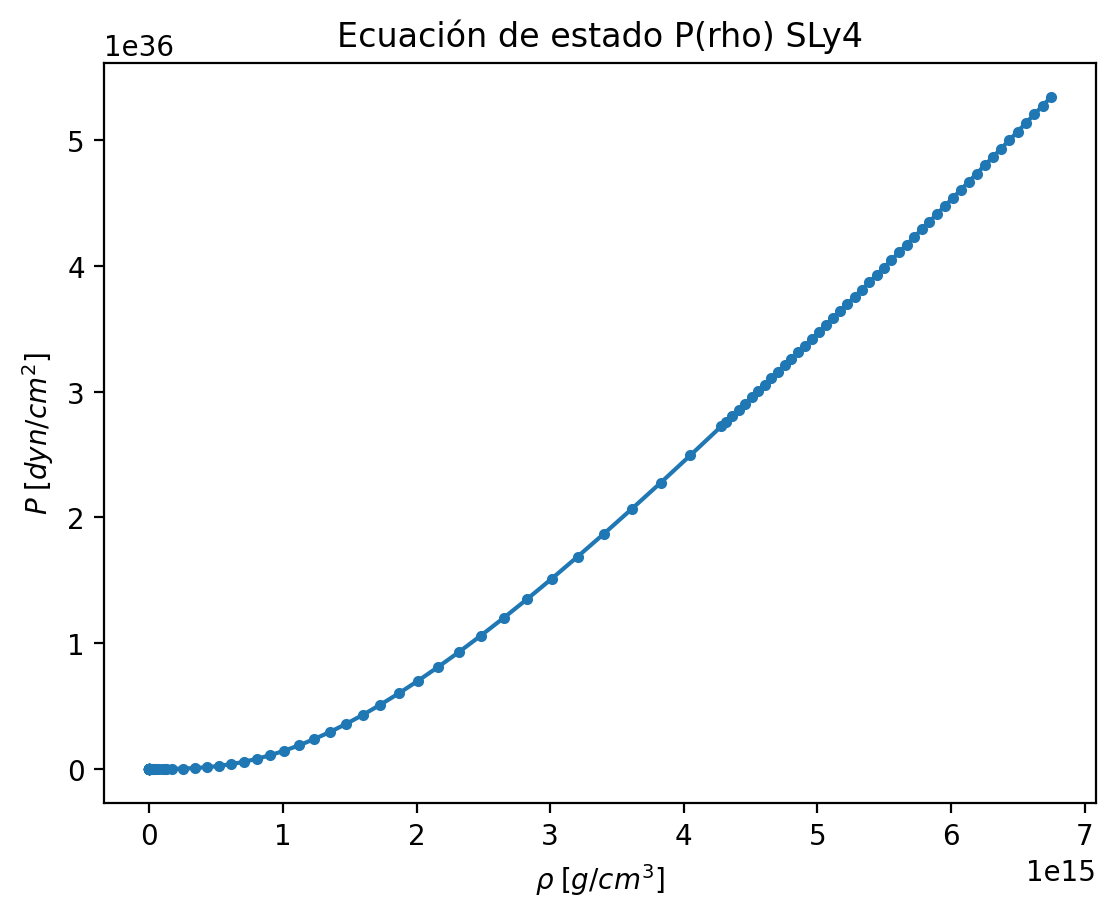

In [294]:
#Gráfica de las columnas rho vs P

plt.plot(dataframe["rho[g/cm^3]"], dataframe["P[dyn/cm^2]"], marker='.')
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("Ecuación de estado P(rho) SLy4")
plt.show()

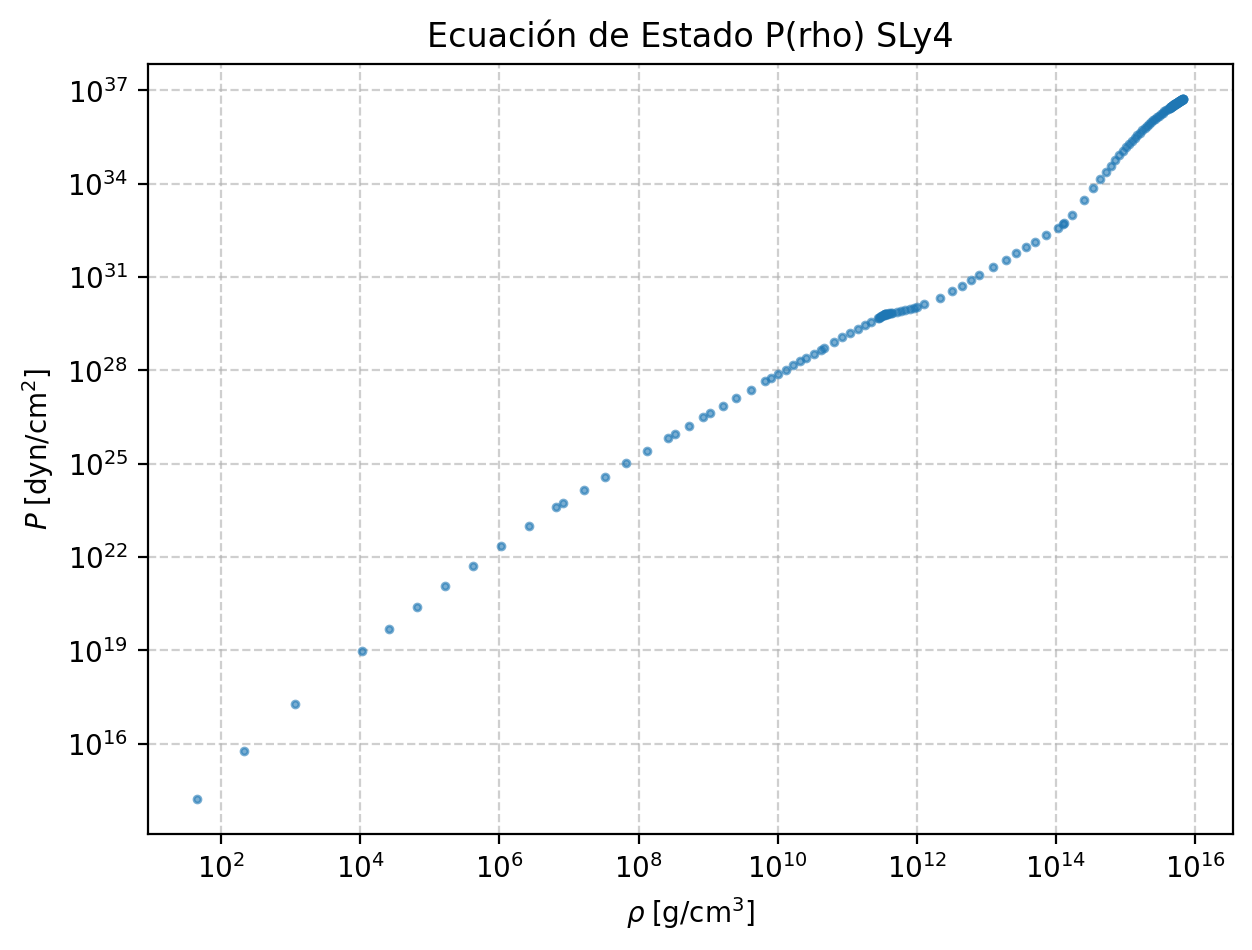

In [295]:
plt.figure(figsize=(7,5))
plt.loglog(dataframe["rho[g/cm^3]"], dataframe["P[dyn/cm^2]"], marker='.', linestyle='none', markersize=5, alpha=0.6)
plt.xlabel(r'$\rho \; [\mathrm{g/cm^3}]$')
plt.ylabel(r'$P \; [\mathrm{dyn/cm^2}]$')
plt.xscale('log')
plt.yscale('log')
plt.title("Ecuación de Estado P(rho) SLy4")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.show()

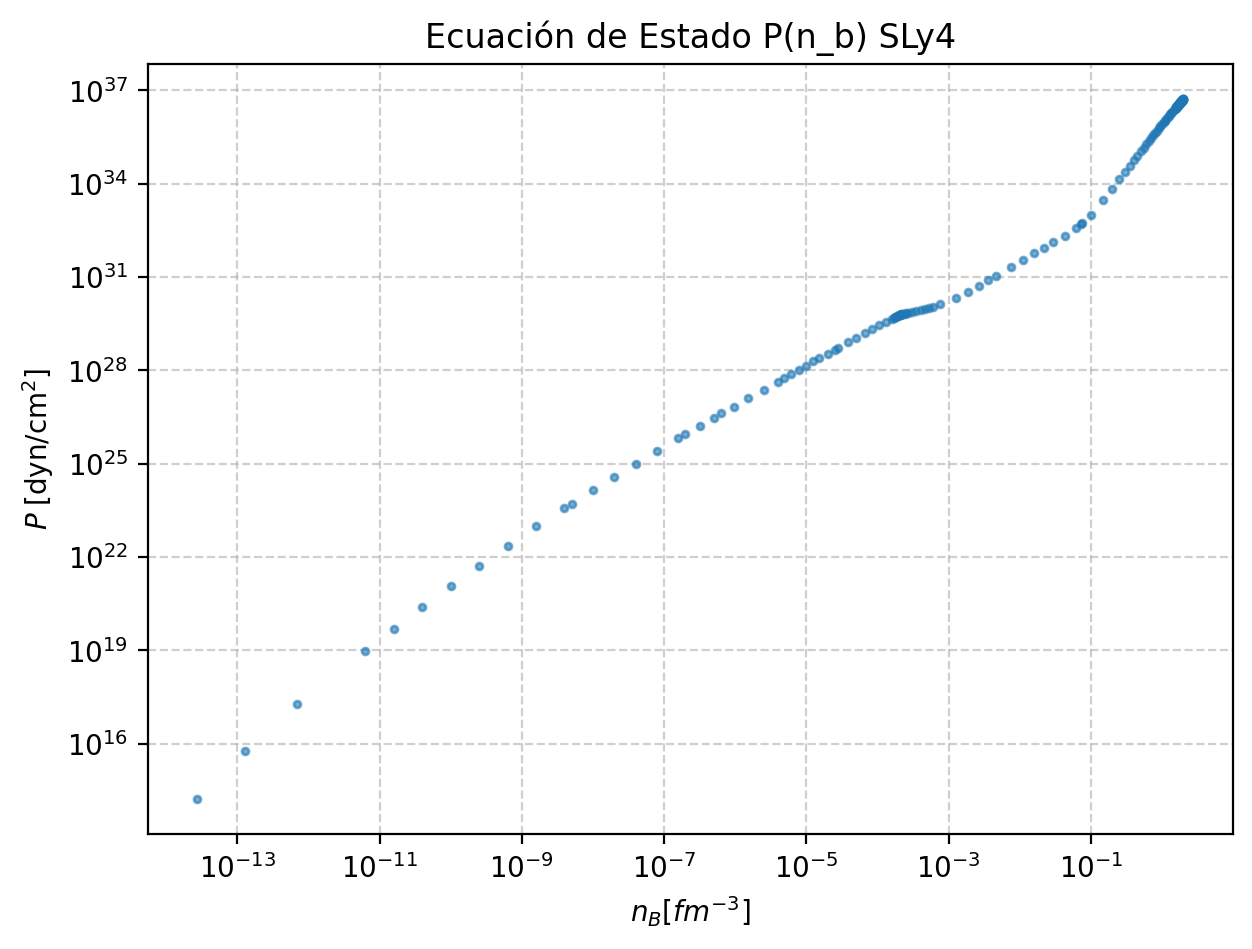

In [296]:
plt.figure(figsize=(7,5))
plt.loglog(dataframe["n_B[fm^{-3}]"], dataframe["P[dyn/cm^2]"], marker='.', linestyle='none', markersize=5, alpha=0.6)
plt.xlabel(r'$n_B[fm^{-3}]$')
plt.ylabel(r'$P \; [\mathrm{dyn/cm^2}]$')
plt.xscale('log')
plt.yscale('log')
plt.title("Ecuación de Estado P(n_b) SLy4")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.show()

In [297]:
#No sé que hace
%config InlineBackend.figure_format = 'retina'

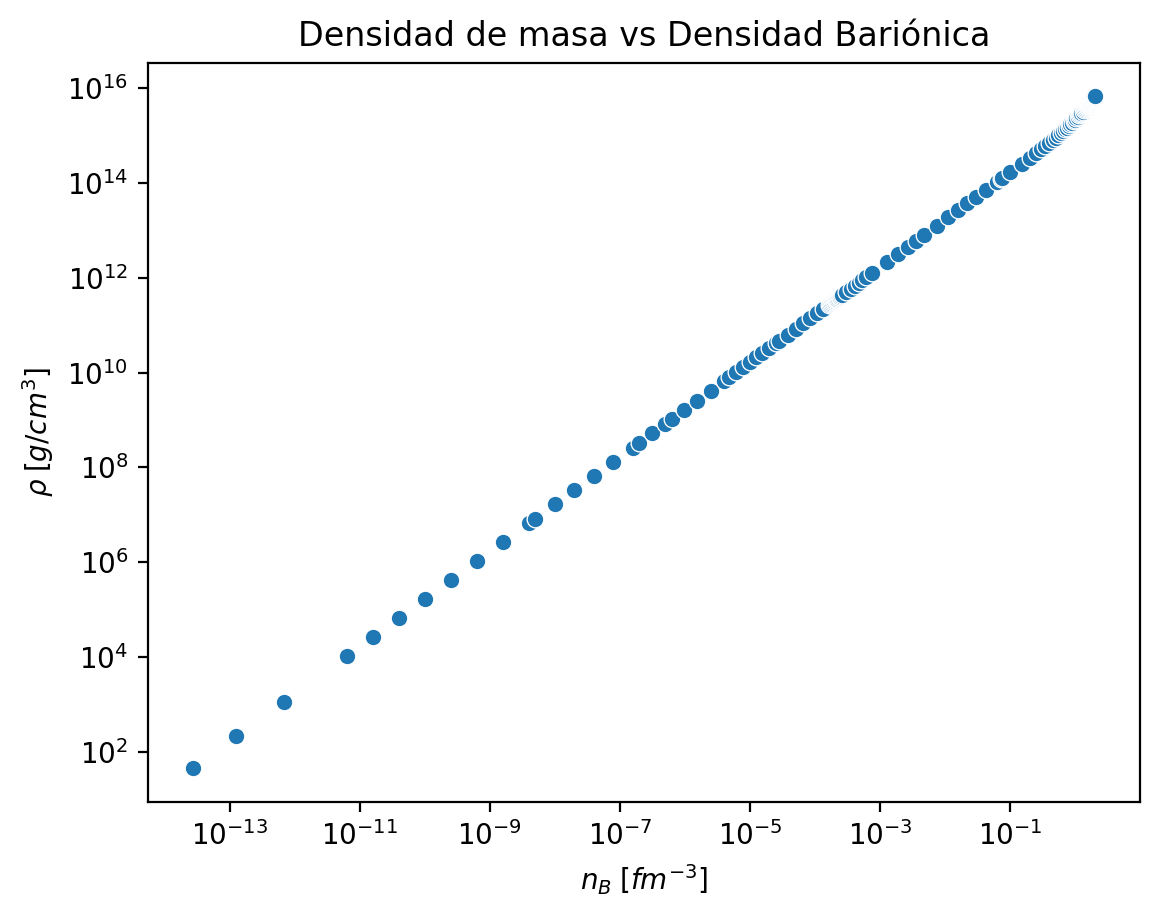

In [298]:
#A esto le podemos hacer una aproximación lineal para justificar el
#porqué las gráficas son tan parecidas

g = sns.scatterplot(data=dataframe, x='n_B[fm^{-3}]', y='rho[g/cm^3]')
g.set_xlabel(r'$n_B \; [fm^{-3}]$')
g.set_ylabel(r'$\rho  \; [g/cm^3]$')
g.set_title("Densidad de masa vs Densidad Bariónica")
g.set_xscale('log')
g.set_yscale('log')

Ajuste (en log-log): pendiente = 1.02481, intersección = 15.38128
Ajuste (en lineal): alpha = 2.40593e+15, n = 1.02481 




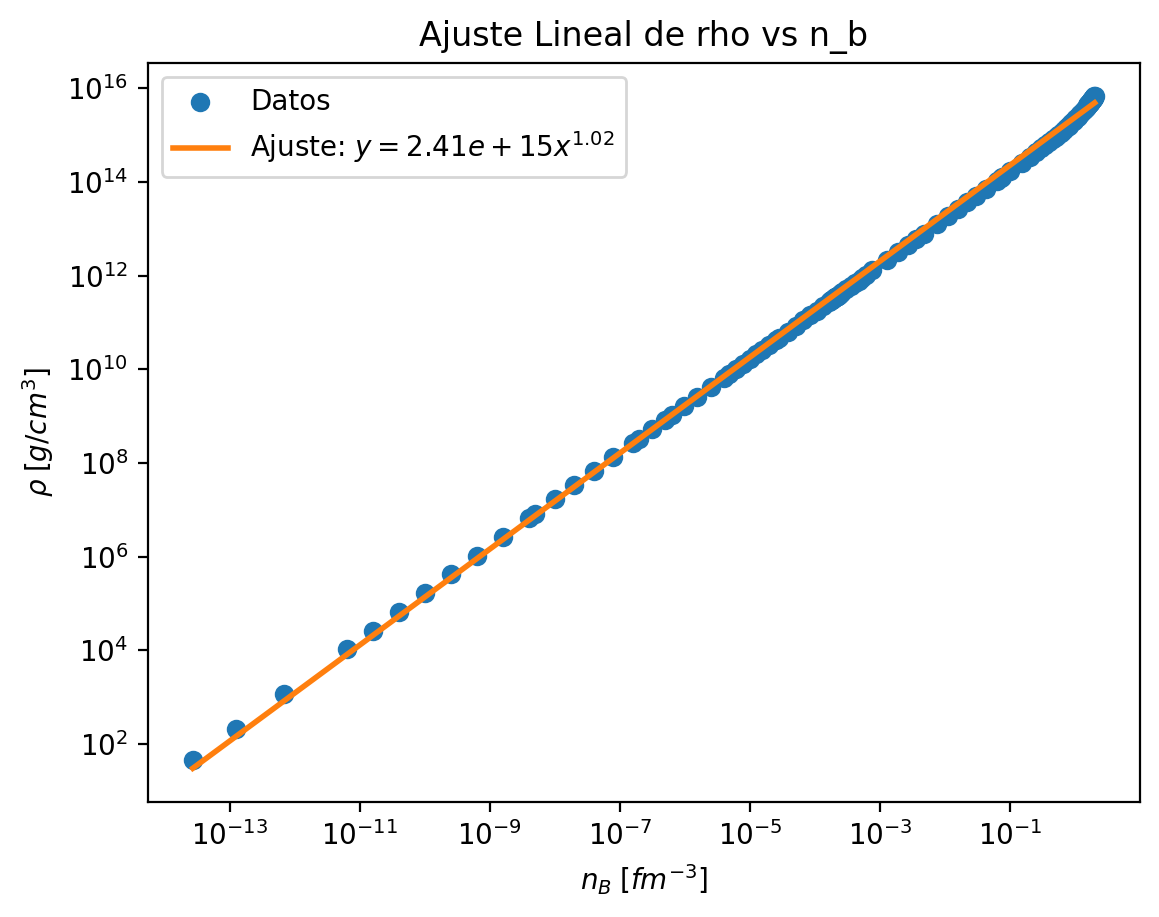

In [299]:
x = dataframe['n_B[fm^{-3}]']
y = dataframe['rho[g/cm^3]']

x_log = np.log10(x)
y_log = np.log10(y)

#ajuste lineal (y = mx + c)
m, c = np.polyfit(x_log, y_log, 1)

alpha_fit = 10**c
n_fit = m

print(f"Ajuste (en log-log): pendiente = {m:.5f}, intersección = {c:.5f}")
print(f"Ajuste (en lineal): alpha = {alpha_fit:.5e}, n = {n_fit:.5f} \n\n")

fig, ax = plt.subplots()


ax.scatter(x, y, label='Datos')

# ajuste lineal y = \alpha * x ** n
x_fit = np.linspace(min(x), max(x), 100)
y_fit = alpha_fit * (x_fit ** n_fit)
ax.plot(x_fit, y_fit, label=r'Ajuste: $y = {0:.2e}x^{{{1:.2f}}}$'.format(alpha_fit,n_fit), color='C1', linewidth=2)


ax.set_xlabel(r'$n_B \; [fm^{-3}]$')
ax.set_ylabel(r'$\rho \; [g/cm^3]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Ajuste Lineal de rho vs n_b")
ax.legend()
plt.show()

##Método Lagrange









*   Tenemos que hallar un error relativo, valor verdadero - el valor del ajuste sobre el valor verdadero,
Hay valor absoluto y valor relativo. ()


*   ¿Están los datos igualmente espaciados? (X)
*   ¿Cuál es la variable independiente y cual es variable dependiente? (X)



In [300]:
dataframe.describe()
#El 75% de los datos están en agrupados

n_B[fm^{-3}]   rho[g/cm^3]   P[dyn/cm^2]
count  1.520000e+02  1.520000e+02  1.520000e+02
mean   6.912947e-01  1.992758e+15  1.332255e+36
std    7.984834e-01  2.463589e+15  1.829668e+36
min    2.720000e-14  4.510000e+01  1.700000e+14
25%    1.007325e-04  1.682500e+11  2.619750e+29
50%    7.456500e-02  1.260500e+14  5.208500e+32
75%    1.619500e+00  4.617500e+15  3.066750e+36
max    1.997000e+00  6.749000e+15  5.344000e+36

In [301]:
#Se crea un nuevo dataframe con menor cantidad de datos para la interpolación de lagrange
#Primer intento del dataframe para lagrange

print(len(dataframe)) #Cantidad de filas

def df_para_lagrange(df):
    n = len(df)
    indices1 = np.linspace(0, n/8, 5, dtype=int)
    indices2 = np.linspace(n/8 + 1, n-1, 3, dtype=int)
    indices = np.concatenate((indices1, indices2))
    return df.iloc[indices]

df_lg = df_para_lagrange(dataframe)
print(f"\n {df_lg}")
print(f"\nEl número de datos para el nuevo dataframe es {len(df_lg)}")

152

      n_B[fm^{-3}]   rho[g/cm^3]   P[dyn/cm^2]
0    2.720000e-14  4.510000e+01  1.700000e+14
4    1.581000e-11  2.622000e+04  4.968000e+19
9    1.581000e-09  2.622000e+06  9.755000e+22
14   3.973000e-08  6.592000e+07  1.006000e+25
19   5.001000e-07  8.303000e+08  3.029000e+26
20   6.296000e-07  1.046000e+09  4.129000e+26
85   5.000000e-01  9.056000e+14  1.095000e+35
151  1.997000e+00  6.749000e+15  5.344000e+36

El número de datos para el nuevo dataframe es 8


In [302]:
#Segundo intento del dataframe para lagrange

n = 8

valores = np.logspace(np.log10(1), np.log10(len(dataframe) - 1), n)

# Nuevo dataframe con n puntos
df_lg = dataframe.iloc[valores]


print(df_lg)

     n_B[fm^{-3}]   rho[g/cm^3]   P[dyn/cm^2]
1    1.270000e-13  2.120000e+02  5.820000e+15
2    6.930000e-13  1.150000e+03  1.900000e+17
4    1.581000e-11  2.622000e+04  4.968000e+19
8    6.294000e-10  1.044000e+06  2.318000e+22
17   1.991000e-07  3.305000e+08  8.738000e+25
36   6.592000e-05  1.100000e+11  1.561000e+29
73   4.268000e-02  7.202000e+13  2.162000e+32
150  1.987000e+00  6.685000e+15  5.274000e+36


### Ecuación de Estado P(rho)

In [303]:
x_l = np.log10(df_lg["rho[g/cm^3]"].values)
y_l = np.log10(df_lg["P[dyn/cm^2]"].values)
x_0 = dataframe["rho[g/cm^3]"].values
y_0 = dataframe["P[dyn/cm^2]"].values

# Ajuste lineal en log-log: y = gamma * x + logK
p, cov = np.polyfit(x_l, y_l, 1, cov=True)
gamma, logK = p[0], p[1]
gamma_err = np.sqrt(cov[0,0])
logK_err  = np.sqrt(cov[1,1])

K = 10**logK
K_err = K * np.log(10) * logK_err   # propagación aproximada de error

print(f"gamma = {gamma:.5f} ± {gamma_err:.5f}")
print(f"log10(K) = {logK:.5f} ± {logK_err:.5f}")
print(f"K = {K:.5e} ± {K_err:.5e}   (unidades: dyn/cm^2 / (g/cm^3)^gamma)")

gamma = 1.47414 ± 0.04563
log10(K) = 12.92231 ± 0.42909
K = 8.36195e+12 ± 8.26169e+12   (unidades: dyn/cm^2 / (g/cm^3)^gamma)


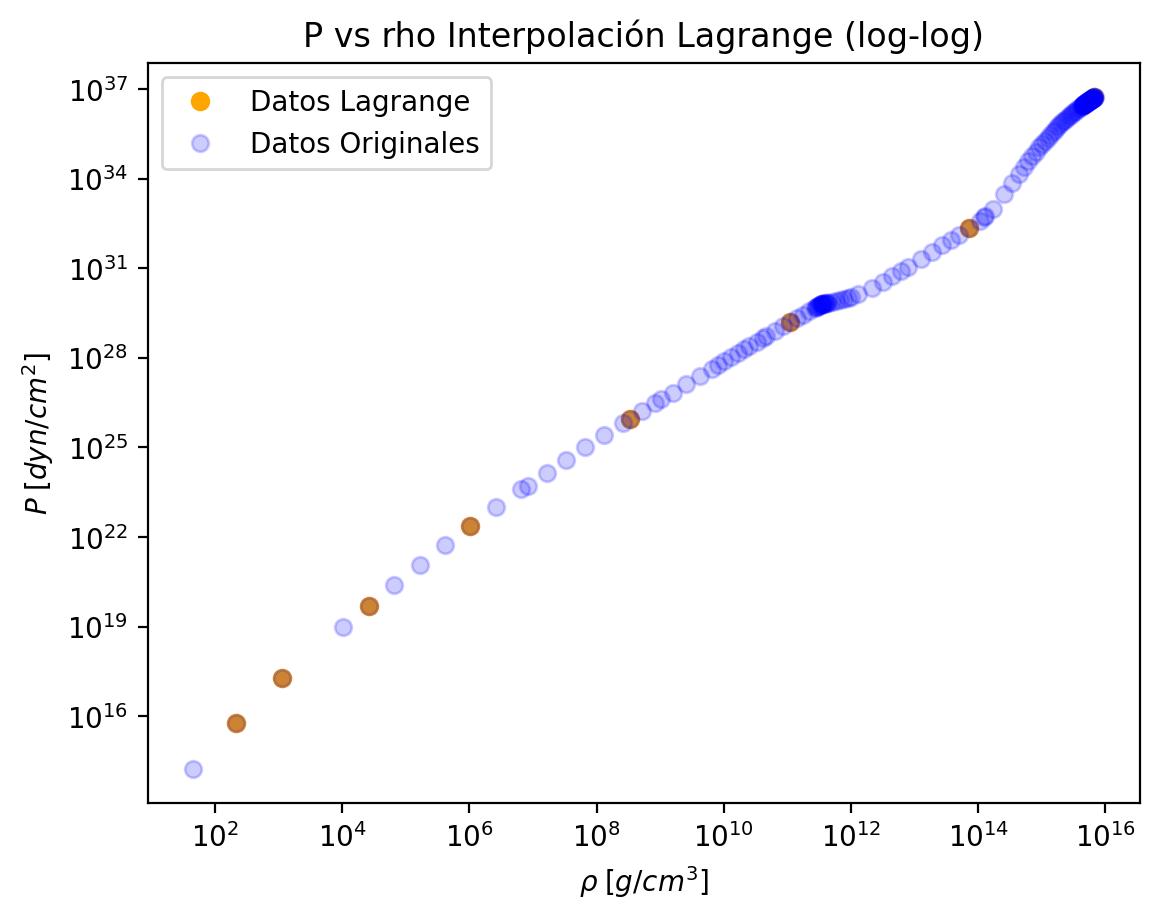

In [304]:
plt.plot(df_lg["rho[g/cm^3]"], df_lg["P[dyn/cm^2]"], marker='o', color='orange', linestyle='none', label='Datos Lagrange')
plt.plot(x_0, y_0, marker='o', color='blue', linestyle='none', alpha=0.2, label='Datos Originales')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación Lagrange (log-log)")
plt.show()

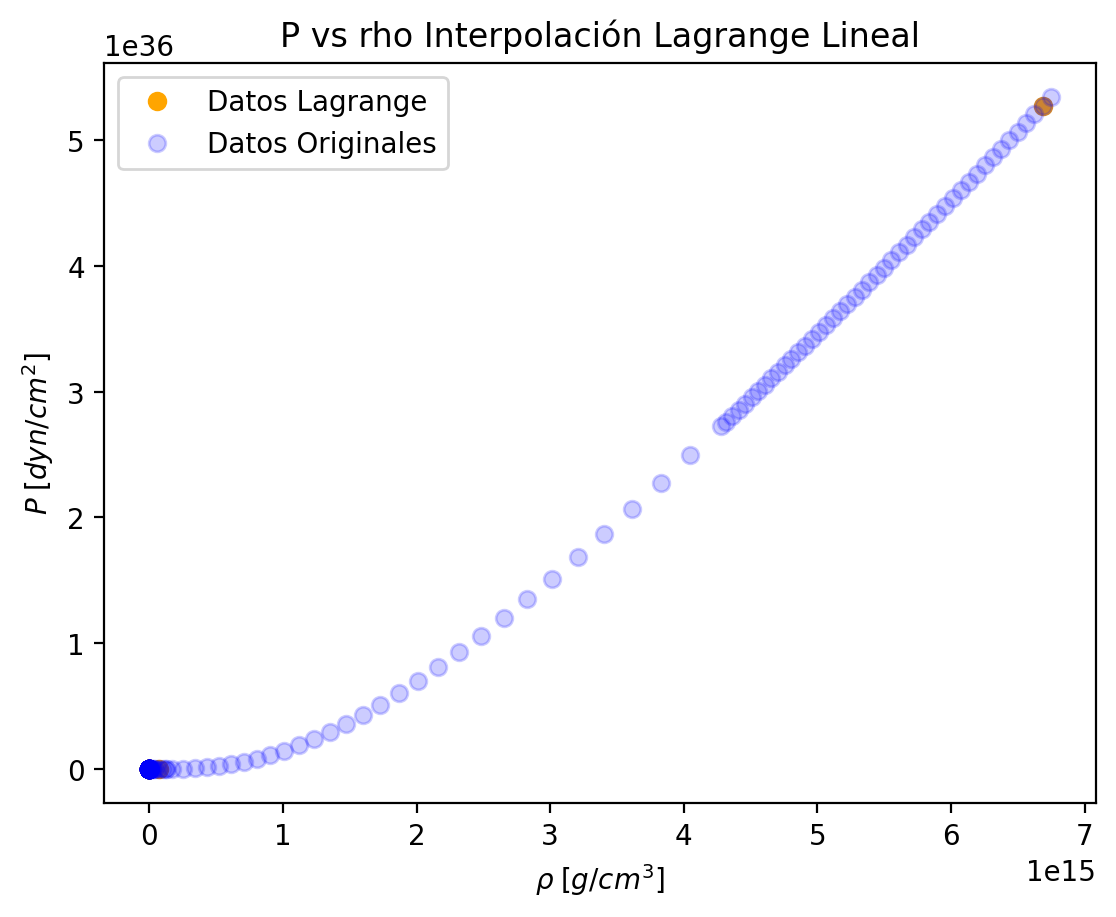

In [305]:
plt.plot(df_lg["rho[g/cm^3]"], df_lg["P[dyn/cm^2]"], marker='o', color='orange', linestyle='none', label = 'Datos Lagrange')
plt.plot(x_0, y_0, marker='o', color='blue', linestyle='none', alpha=0.2, label='Datos Originales')
plt.legend()
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación Lagrange Lineal")
plt.show()

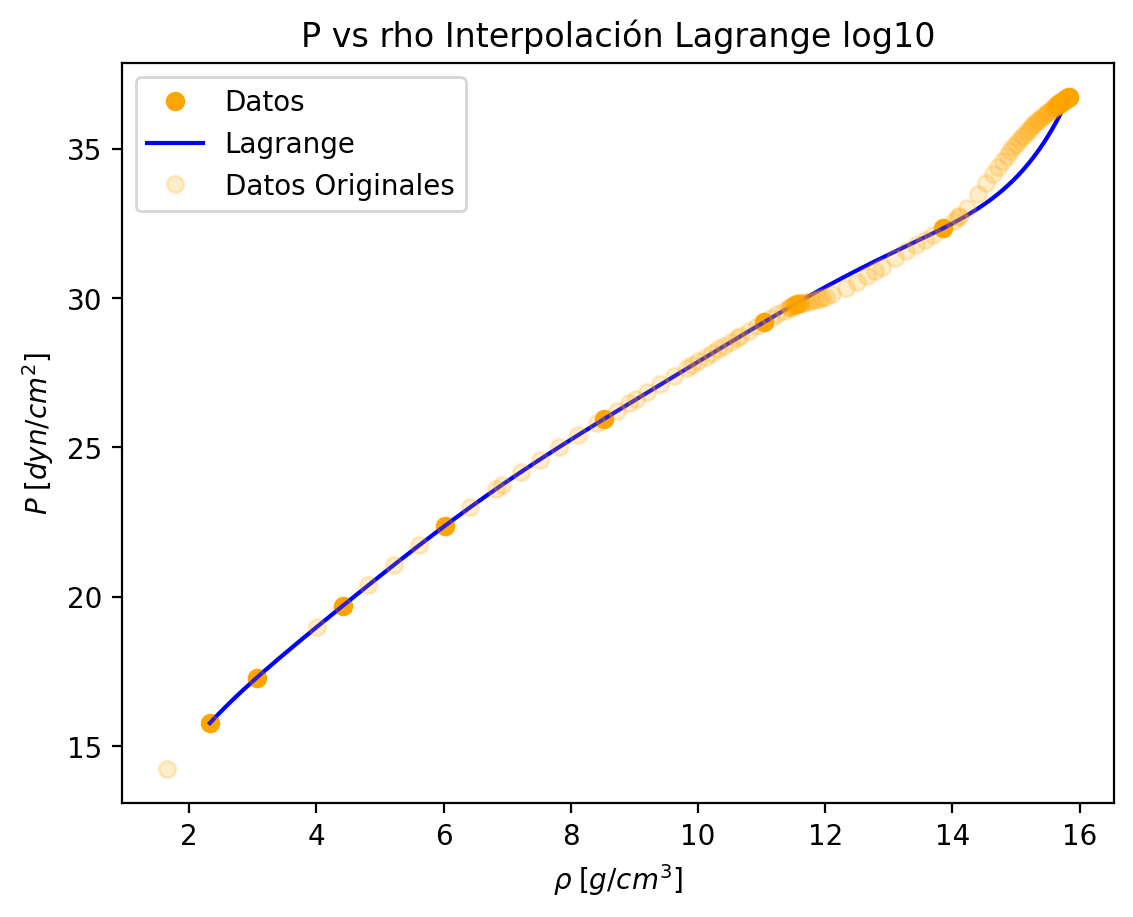

In [306]:
poly = lagrange(x_l, y_l)
x_new = np.linspace(min(x_l), max(x_l), 500)
x_02 = np.log10(dataframe["rho[g/cm^3]"].values)
y_02 = np.log10(dataframe["P[dyn/cm^2]"].values)

# Gráfica compacta
plt.figure()
plt.plot(x_l, y_l, 'o', color='orange', label="Datos")
plt.plot(x_new, poly(x_new), color="blue", label="Lagrange")
plt.plot(x_02, y_02, marker='o', color='orange', linestyle='none', alpha=0.2, label='Datos Originales')

plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación Lagrange log10")
plt.show()

### Ecuación de Estado P(n_B)

In [307]:
x_l2 = np.log10(df_lg["n_B[fm^{-3}]"].values)
y_l2 = np.log10(df_lg["P[dyn/cm^2]"].values)
x_0 = dataframe["n_B[fm^{-3}]"].values
y_0 = dataframe["P[dyn/cm^2]"].values

# Ajuste lineal en log-log: y = gamma * x + logK
p, cov = np.polyfit(x_l2, y_l2, 1, cov=True)
gamma, logK = p[0], p[1]
gamma_err = np.sqrt(cov[0,0])
logK_err  = np.sqrt(cov[1,1])

K = 10**logK
K_err = K * np.log(10) * logK_err   # propagación aproximada de error

print(f"gamma = {gamma:.5f} ± {gamma_err:.5f}")
print(f"log10(K) = {logK:.5f} ± {logK_err:.5f}")
print(f"K = {K:.5e} ± {K_err:.5e}   (unidades: dyn/cm^2 / (g/cm^3)^gamma)")

gamma = 1.49301 ± 0.05132
log10(K) = 35.55189 ± 0.43689
K = 3.56357e+35 ± 3.58488e+35   (unidades: dyn/cm^2 / (g/cm^3)^gamma)


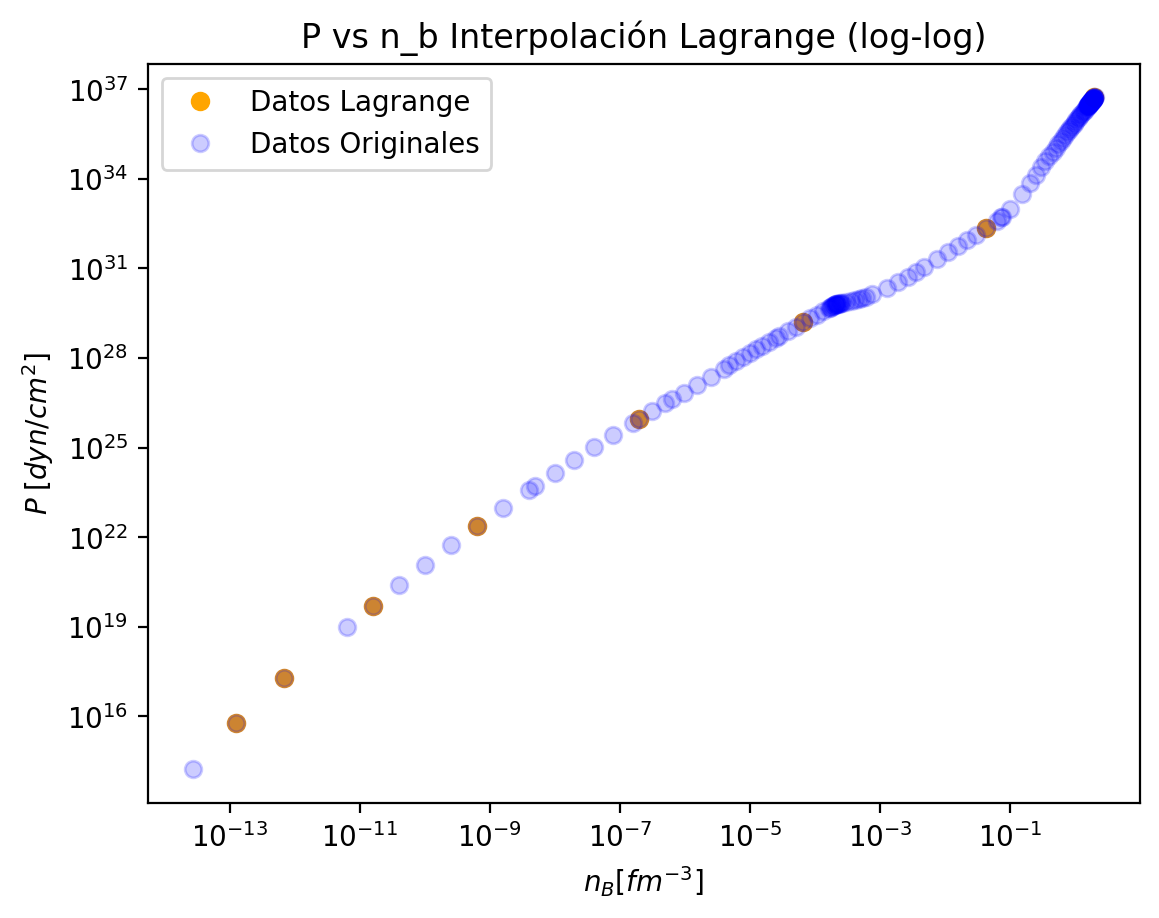

In [308]:
plt.plot(df_lg["n_B[fm^{-3}]"], df_lg["P[dyn/cm^2]"], marker='o', color='orange', linestyle='none', label='Datos Lagrange')
plt.plot(x_0, y_0, marker='o', color='blue', linestyle='none', alpha=0.2, label='Datos Originales')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Interpolación Lagrange (log-log)")
plt.legend()
plt.show()

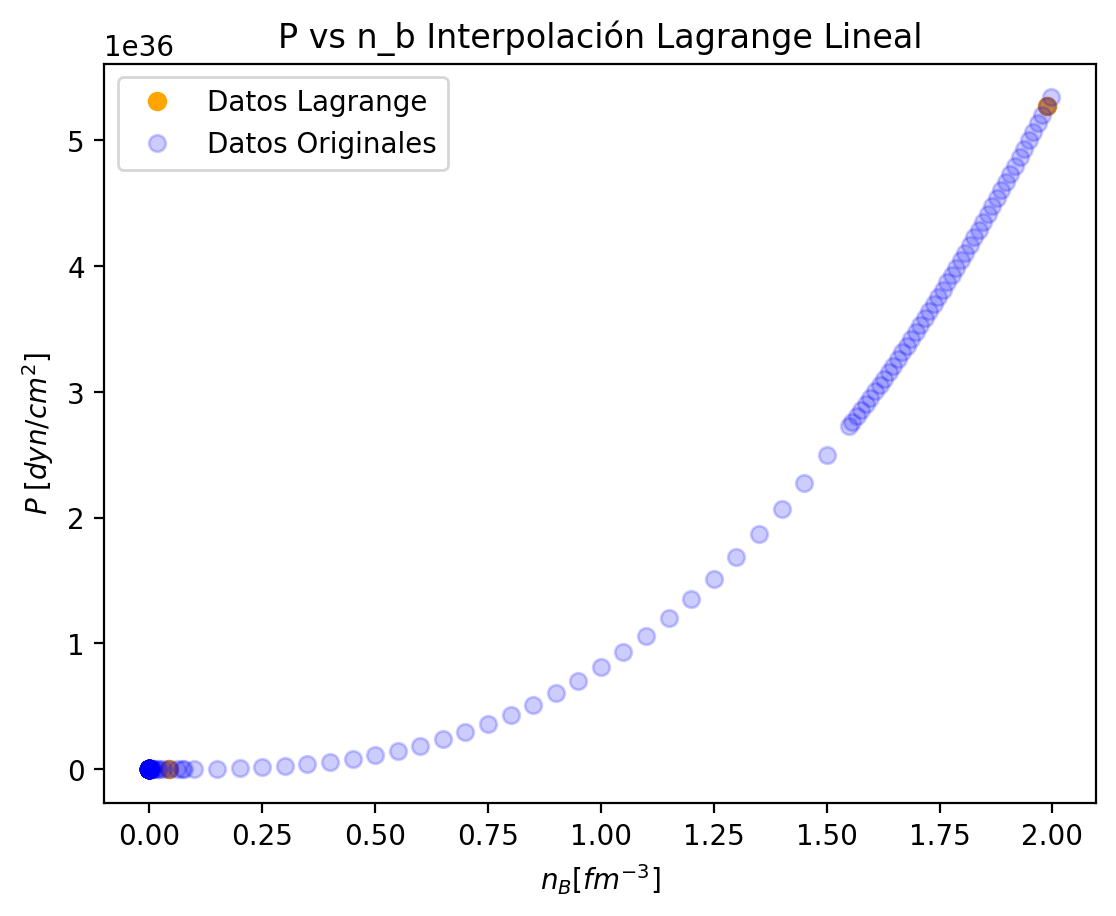

In [309]:
plt.plot(df_lg["n_B[fm^{-3}]"], df_lg["P[dyn/cm^2]"], marker='o', color='orange', linestyle='none', label='Datos Lagrange')
plt.plot(x_0, y_0, marker='o', color='blue', linestyle='none', alpha=0.2, label='Datos Originales')
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Interpolación Lagrange Lineal")
plt.legend()
plt.show()

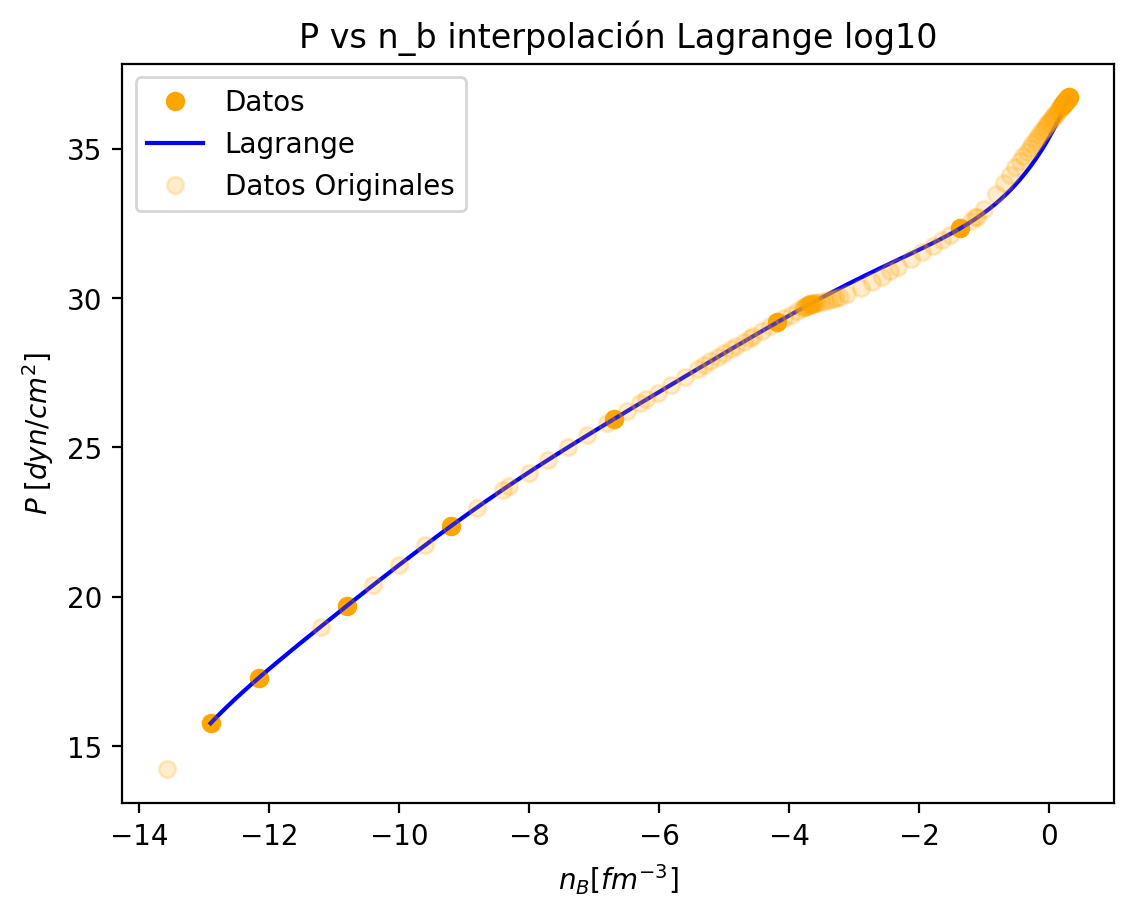

In [310]:
x_sc2 = np.log10(dataframe["n_B[fm^{-3}]"].values)
y_sc2 = np.log10(dataframe["P[dyn/cm^2]"].values)
poly = lagrange(x_l2, y_l2)
x_new = np.linspace(min(x_l2), max(x_l2), 500)

# Gráfica compacta
plt.figure()
plt.plot(x_l2, y_l2, 'o', color='orange', label="Datos")
plt.plot(x_new, poly(x_new), color="blue", label="Lagrange")
plt.plot(x_sc2, y_sc2, marker='o', color='orange', linestyle='none', label="Datos Originales", alpha=0.2)


plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b interpolación Lagrange log10")
plt.show()

##Interpolación con Spline Cúbico


### Ecuación de Estado P(rho)

#### Sline Cúbico Natural

In [311]:
x_sc = np.log10(dataframe["rho[g/cm^3]"].values)
y_sc = np.log10(dataframe["P[dyn/cm^2]"].values)

# Ajuste lineal en log-log: y = gamma * x + logK
p, cov = np.polyfit(x_sc, y_sc, 1, cov=True)
gamma, logK = p[0], p[1]
gamma_err = np.sqrt(cov[0,0])
logK_err  = np.sqrt(cov[1,1])

K = 10**logK
K_err = K * np.log(10) * logK_err   # propagación aproximada de error

print(f"gamma = {gamma:.5f} ± {gamma_err:.5f}")
print(f"log10(K) = {logK:.5f} ± {logK_err:.5f}")
print(f"K = {K:.5e} ± {K_err:.5e}   (unidades: dyn/cm^2 / (g/cm^3)^gamma)")

gamma = 1.49787 ± 0.01133
log10(K) = 12.72606 ± 0.14985
K = 5.32187e+12 ± 1.83629e+12   (unidades: dyn/cm^2 / (g/cm^3)^gamma)


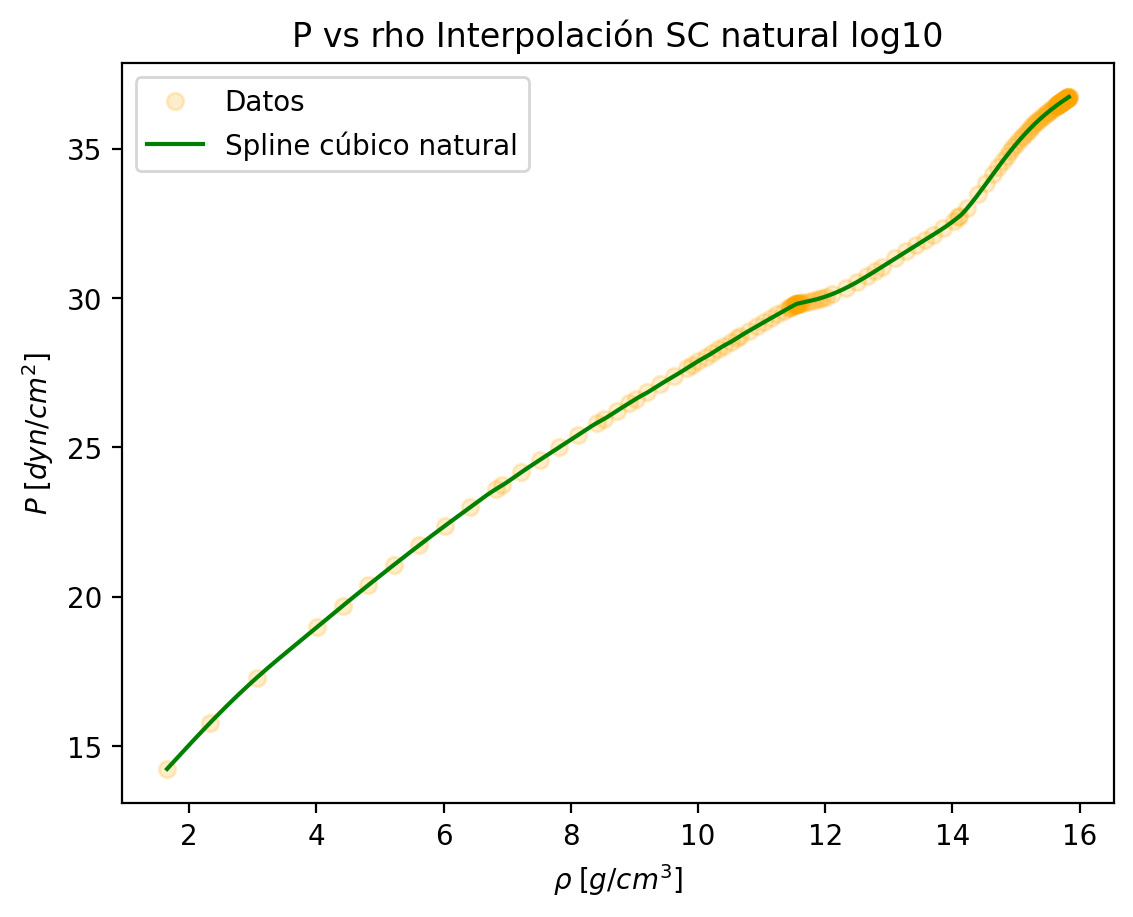

In [312]:
 # Interpolación con Spline cúbico natural
cs = CubicSpline(x_sc, y_sc, bc_type="natural")
x_new = np.linspace(min(x_sc), max(x_sc), 500)
y_new = cs(x_new)

plt.plot(x_sc, y_sc, marker='o', color='orange', linestyle='none', label="Datos", alpha=0.2)
plt.plot(x_new, y_new, label="Spline cúbico natural", color="green")
plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación SC natural log10")
plt.show()

#### Sline Cúbico not-a-knot

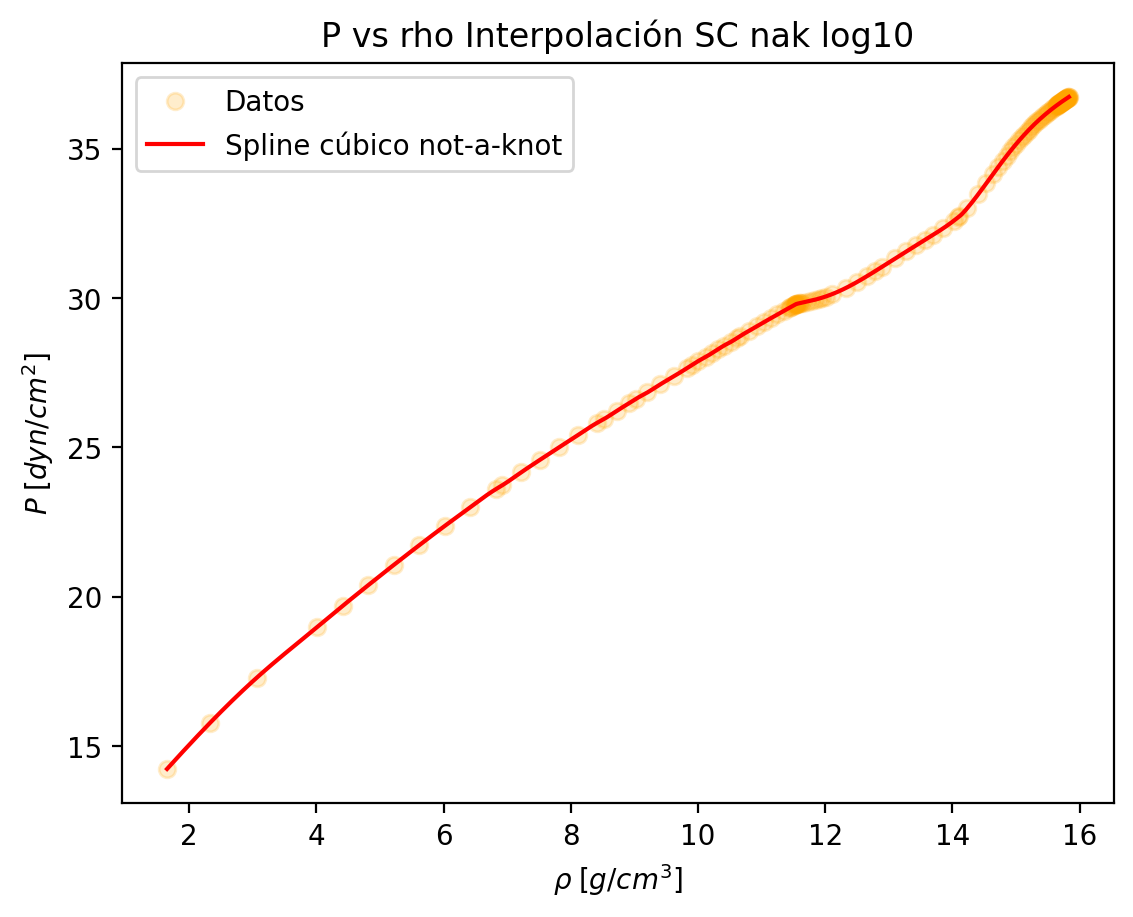

In [313]:
#exige que el tercer polinomio cúbico sea el mismo que el primero y el último
#y que es flexible dice el chato

cs_notaknot = CubicSpline(x_sc, y_sc, bc_type="not-a-knot")
x_new = np.linspace(min(x_sc), max(x_sc), 500)


plt.figure()
plt.plot(x_sc, y_sc, 'o', color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, cs_notaknot(x_new), color="red", label="Spline cúbico not-a-knot")
plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación SC nak log10")
plt.show()

###Ecuación de Estado P(n_B)

#### Sline Cúbico Natural

In [314]:
x_sc2 = np.log10(dataframe["n_B[fm^{-3}]"].values)
y_sc2 = np.log10(dataframe["P[dyn/cm^2]"].values)

# Ajuste lineal en log-log: y = gamma * x + logK
p, cov = np.polyfit(x_sc2, y_sc2, 1, cov=True)
gamma, logK = p[0], p[1]
gamma_err = np.sqrt(cov[0,0])
logK_err  = np.sqrt(cov[1,1])

K = 10**logK
K_err = K * np.log(10) * logK_err   # propagación aproximada de error

print(f"gamma = {gamma:.5f} ± {gamma_err:.5f}")
print(f"log10(K) = {logK:.5f} ± {logK_err:.5f}")
print(f"K = {K:.5e} ± {K_err:.5e}   (unidades: dyn/cm^2 / (g/cm^3)^gamma)")

gamma = 1.53258 ± 0.01398
log10(K) = 35.75912 ± 0.05771
K = 5.74281e+35 ± 7.63130e+34   (unidades: dyn/cm^2 / (g/cm^3)^gamma)


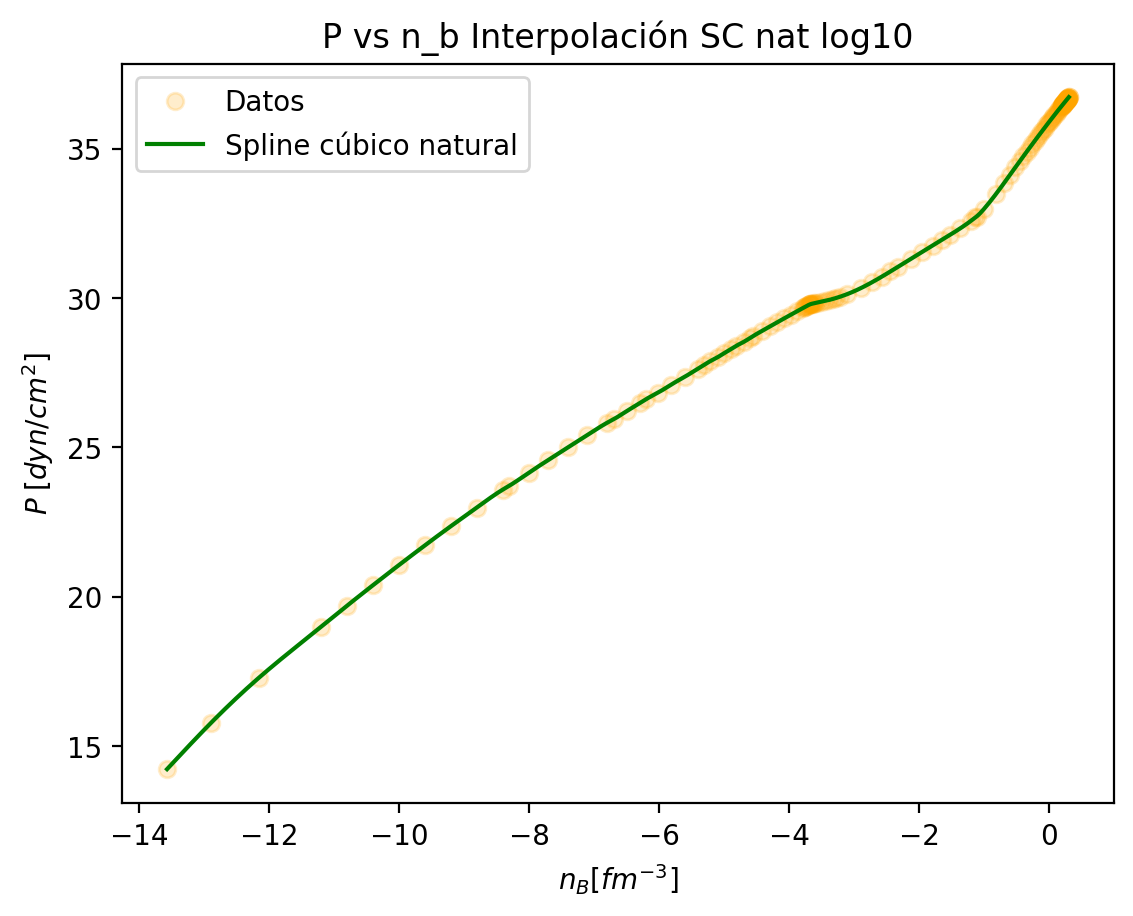

In [315]:
# Interpolación con Spline cúbico natural
cs = CubicSpline(x_sc2, y_sc2, bc_type="natural")
x_new = np.linspace(min(x_sc2), max(x_sc2), 500)
y_new = cs(x_new)

plt.plot(x_sc2, y_sc2, marker='o', color='orange', linestyle='none', label="Datos", alpha=0.2)
plt.plot(x_new, y_new, label="Spline cúbico natural", color="green")
plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Interpolación SC nat log10")
plt.show()

#### Sline Cúbico not a knot


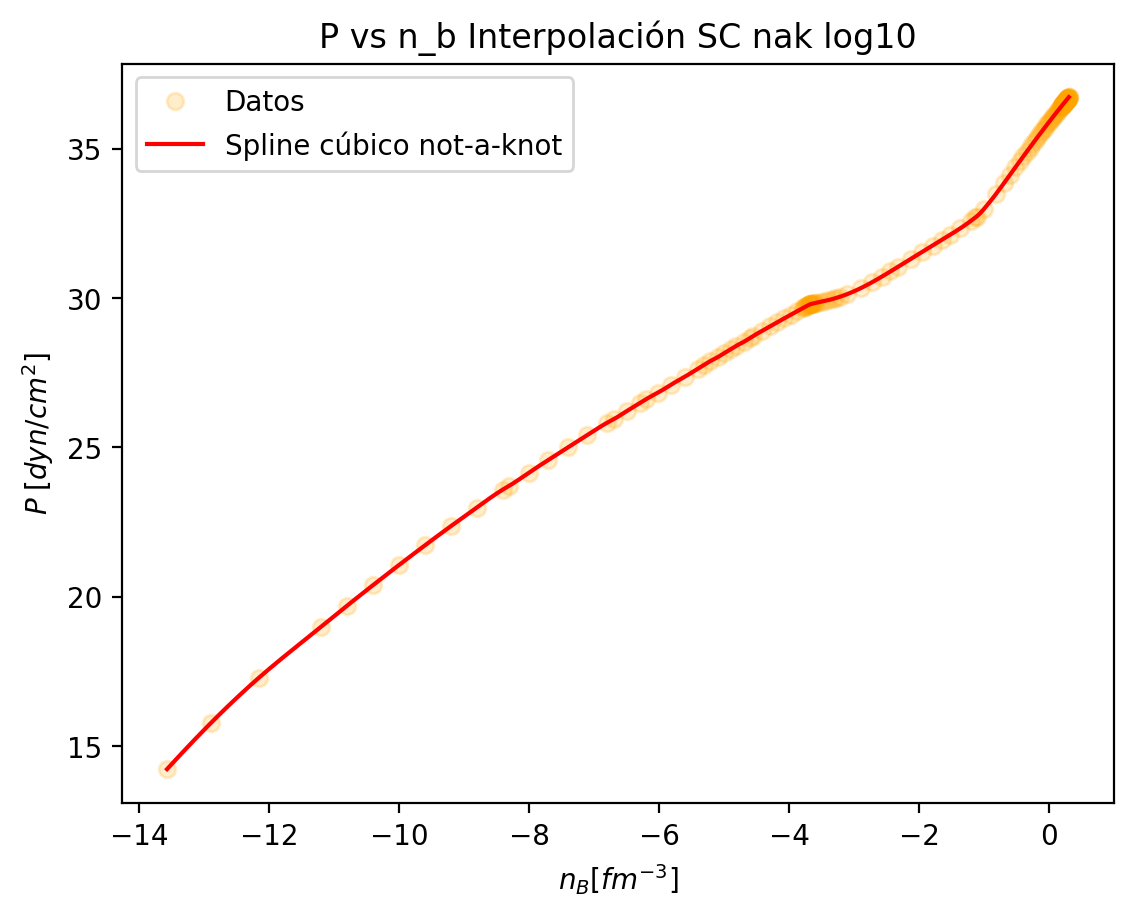

In [316]:
cs_notaknot = CubicSpline(x_sc2, y_sc2, bc_type="not-a-knot")
x_new = np.linspace(min(x_sc2), max(x_sc2), 500)

plt.figure()
plt.plot(x_sc2, y_sc2, 'o', color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, cs_notaknot(x_new), color="red", label="Spline cúbico not-a-knot")
plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Interpolación SC nak log10")
plt.show()

##Interpolación con Pchip


###Ecuación de Estado P(rho)

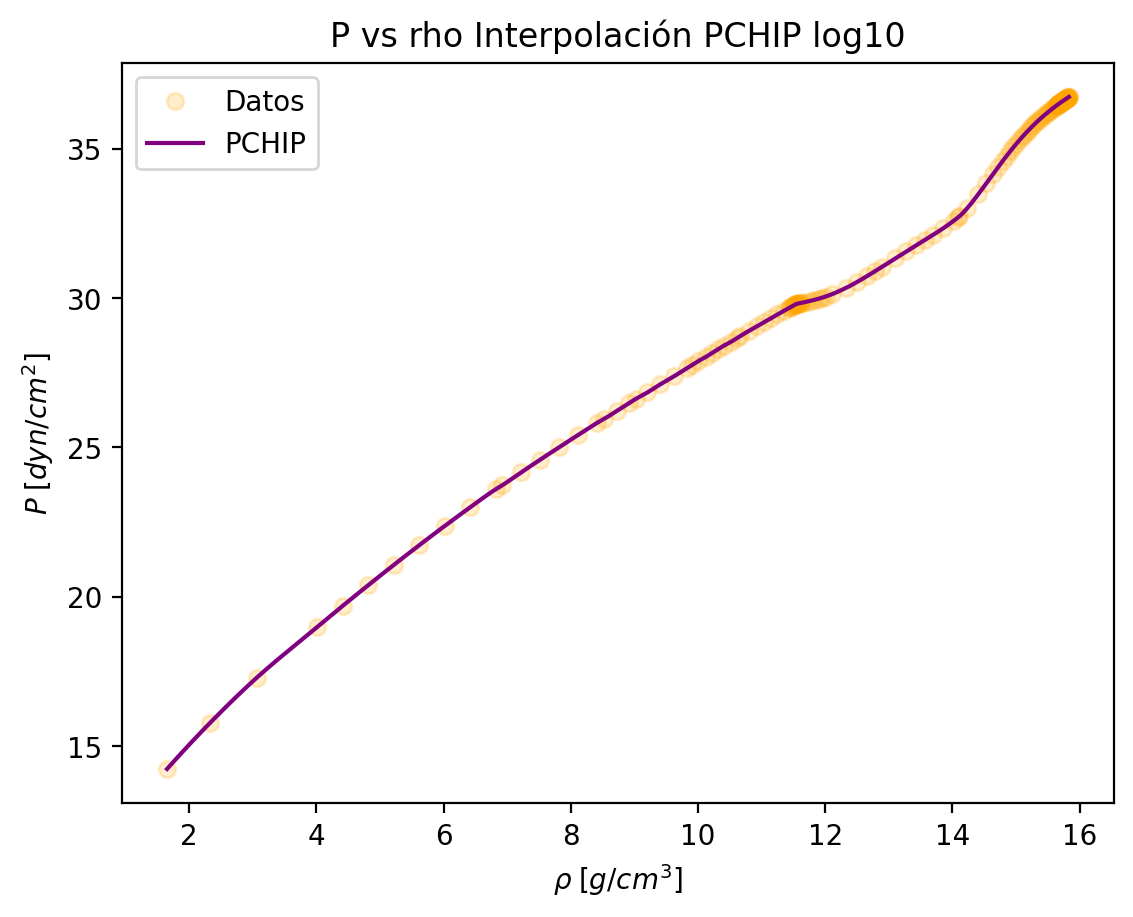

In [317]:
pchip = PchipInterpolator(x_sc, y_sc)
x_new = np.linspace(min(x_sc), max(x_sc), 500)
# Gráfica compacta
plt.figure()
plt.plot(x_sc, y_sc, 'o', color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, pchip(x_new), color="purple", label="PCHIP")
plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación PCHIP log10")
plt.show()

###Ecuación de Estado P(n_B)

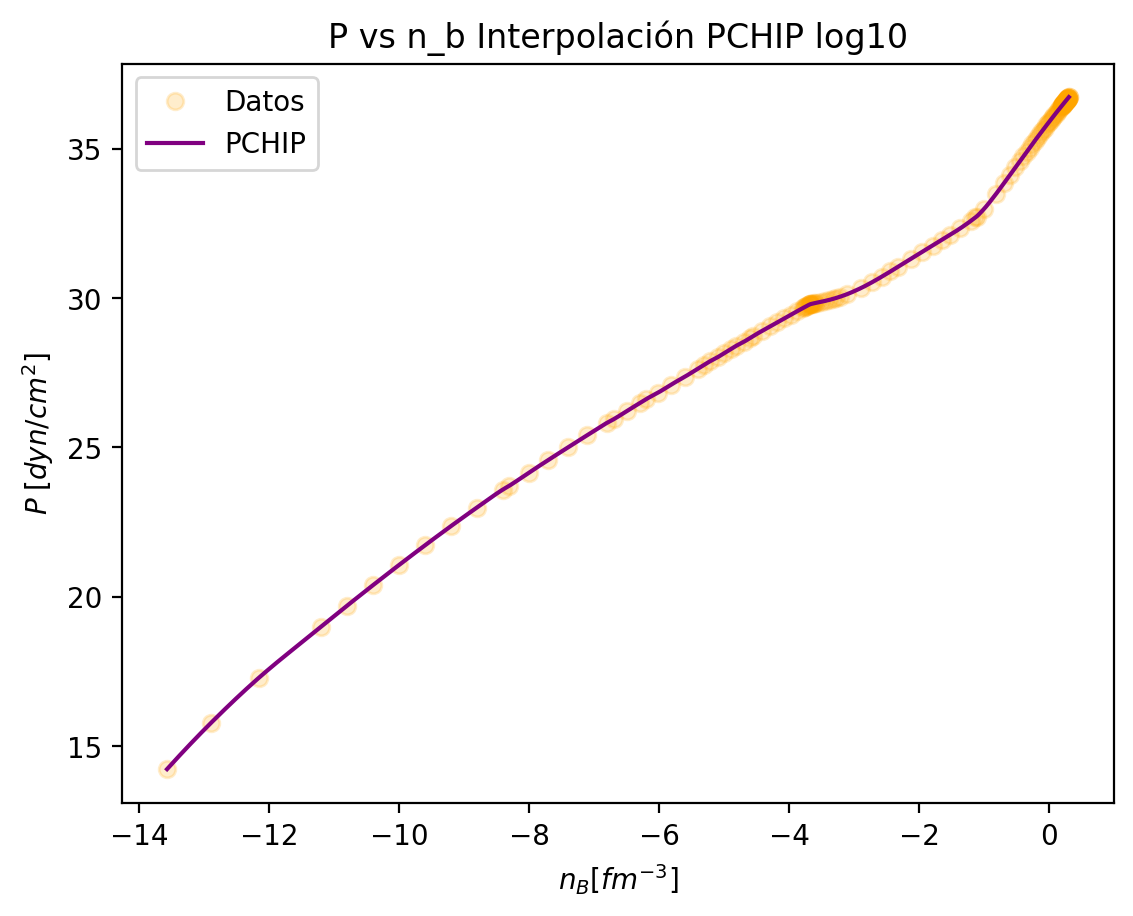

In [318]:
pchip = PchipInterpolator(x_sc2, y_sc2)
x_new = np.linspace(min(x_sc2), max(x_sc2), 500)
# Gráfica compacta
plt.figure()
plt.plot(x_sc2, y_sc2, 'o', color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, pchip(x_new), color="purple", label="PCHIP")
plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Interpolación PCHIP log10")
plt.show()

##Grupos train y test solo para P(rho) y P(n_b) solo para lagrange

In [319]:
#Grupos para la varibale independiente n_b

rng = np.random.default_rng(42) #Usamos siempre la misma semilla

n = 2 #Hay que reducir los intervalos pq son pocos datos
rango = np.linspace(x_l.min(), x_l.max(), n+1)
bin_idx = np.digitize(x_l, rango) - 1

train_mask = np.zeros(len(x_l), dtype=bool)
test_mask  = np.zeros(len(x_l), dtype=bool)

porcentaje = 0.7 # 70% en entrenamiento

for b in range(n):
    idx_in_bin = np.where(bin_idx == b)[0]
    if len(idx_in_bin) == 0:
        continue
    n_train = max(1, int(np.round(len(idx_in_bin) * porcentaje)))
    sel = rng.choice(idx_in_bin, size=len(idx_in_bin), replace=False)
    train_idx = sel[:n_train]
    test_idx  = sel[n_train:]
    train_mask[train_idx] = True
    test_mask[test_idx] = True

# conjuntos resultantes:
x_train_l, y_train_l = x_l[train_mask], y_l[train_mask]
x_test_l,  y_test_l  = x_l[test_mask],  y_l[test_mask]

print(f"Para x, los datos de entrenamiento son: \n\n {x_train_l} \n\n y los de testeo son: \n\n {x_test_l}")

print("\n ======================================== \n")

#Grupos para la variable aleatoria

rng = np.random.default_rng(42) #Usamos siempre la misma semilla

rango = np.linspace(x_l2.min(), x_l2.max(), n+1)
bin_idx = np.digitize(x_l2, rango) - 1

train_mask = np.zeros(len(x_l2), dtype=bool)
test_mask  = np.zeros(len(x_l2), dtype=bool)

for b in range(n):
    idx_in_bin = np.where(bin_idx == b)[0]
    if len(idx_in_bin) == 0:
        continue
    n_train = max(1, int(np.round(len(idx_in_bin) * porcentaje)))
    sel = rng.choice(idx_in_bin, size=len(idx_in_bin), replace=False)
    train_idx = sel[:n_train]
    test_idx  = sel[n_train:]
    train_mask[train_idx] = True
    test_mask[test_idx] = True

# conjuntos resultantes:
x_train_l2, y_train_l2 = x_l2[train_mask], y_l2[train_mask]
x_test_l2,  y_test_l2  = x_l2[test_mask],  y_l2[test_mask]

print(f"Para x, los datos de entrenamiento son: \n\n {x_train_l2} \n\n y los de testeo son: \n\n {x_test_l2}")

Para x, los datos de entrenamiento son: 

 [ 2.32633586  3.06069784  6.0187005   8.51917146 13.85745312] 

 y los de testeo son: 

 [ 4.41863269 11.04139269]


Para x, los datos de entrenamiento son: 

 [-12.89619628 -12.15926677  -9.20107326  -6.70092874  -1.36977559] 

 y los de testeo son: 

 [-10.80106813  -4.1809828 ]


###Grupos train y test para P(rho)

In [320]:
rng = np.random.default_rng(42) #Usamos siempre la misma semilla

n = 8
rango = np.linspace(x_sc.min(), x_sc.max(), n+1)
bin_idx = np.digitize(x_sc, rango) - 1

train_mask = np.zeros(len(x_sc), dtype=bool)
test_mask  = np.zeros(len(x_sc), dtype=bool)

porcentaje = 0.8 # 80% en entrenamiento

for b in range(n):
    idx_in_bin = np.where(bin_idx == b)[0]
    if len(idx_in_bin) == 0:
        continue
    n_train = max(1, int(np.round(len(idx_in_bin) * porcentaje)))
    sel = rng.choice(idx_in_bin, size=len(idx_in_bin), replace=False)
    train_idx = sel[:n_train]
    test_idx  = sel[n_train:]
    train_mask[train_idx] = True
    test_mask[test_idx] = True

# conjuntos resultantes:
x_train_sc, y_train_sc = x_sc[train_mask], y_sc[train_mask]
x_test_sc,  y_test_sc  = x_sc[test_mask],  y_sc[test_mask]

###Grupos train y test para P(n_b)

In [321]:
rng = np.random.default_rng(42) #Usamos siempre la misma semilla

n = 8
rango = np.linspace(x_sc2.min(), x_sc2.max(), n+1)
bin_idx = np.digitize(x_sc2, rango) - 1

train_mask = np.zeros(len(x_sc2), dtype=bool)
test_mask  = np.zeros(len(x_sc2), dtype=bool)

porcentaje = 0.8 # 80% en entrenamiento

for b in range(n):
    idx_in_bin = np.where(bin_idx == b)[0]
    if len(idx_in_bin) == 0:
        continue
    n_train = max(1, int(np.round(len(idx_in_bin) * porcentaje)))
    sel = rng.choice(idx_in_bin, size=len(idx_in_bin), replace=False)
    train_idx = sel[:n_train]
    test_idx  = sel[n_train:]
    train_mask[train_idx] = True
    test_mask[test_idx] = True

# conjuntos resultantes:
x_train_sc2, y_train_sc2 = x_sc2[train_mask], y_sc2[train_mask]
x_test_sc2,  y_test_sc2  = x_sc2[test_mask],  y_sc2[test_mask]

##Calculo del Error

In [322]:
#Variables para el calculo con rho

poly       = lagrange(x_l, y_l)
cs_natural = CubicSpline(x_sc, y_sc, bc_type="natural")
cs_not     = CubicSpline(x_sc, y_sc, bc_type="not-a-knot")
pchip      = PchipInterpolator(x_sc, y_sc)

#Variables para el calculo con n_b

poly2       = lagrange(x_l2, y_l2)
cs_natural2 = CubicSpline(x_sc2, y_sc2, bc_type="natural")
cs_not2     = CubicSpline(x_sc2, y_sc2, bc_type="not-a-knot")
pchip2      = PchipInterpolator(x_sc2, y_sc2)

In [323]:
# Malla fina en el rango de rho
x_eval_rho = np.linspace(min(x_sc), max(x_sc), 200)

# Tomamos PCHIP como "verdad" en la malla fina (esto explica el MSE=0 en la tabla)
y_true_rho = pchip(x_eval_rho)

# Evaluamos los métodos
y_lagrange_rho = poly(x_eval_rho)
y_nat_rho      = cs_natural(x_eval_rho)
y_not_rho      = cs_not(x_eval_rho)
y_pchip_rho    = pchip(x_eval_rho)

# MSE en malla fina
MSE_lagrange_rho = np.mean((y_true_rho - y_lagrange_rho)**2)
MSE_nat_rho      = np.mean((y_true_rho - y_nat_rho)**2)
MSE_not_rho      = np.mean((y_true_rho - y_not_rho)**2)
MSE_pchip_rho    = np.mean((y_true_rho - y_pchip_rho)**2)

print("Errores en malla fina para P(rho):")
print(f"MSE Lagrange          : {MSE_lagrange_rho:.4e}")
print(f"MSE Cubic natural     : {MSE_nat_rho:.4e}")
print(f"MSE Cubic not-a-knot  : {MSE_not_rho:.4e}")
print(f"MSE PCHIP             : {MSE_pchip_rho:.4e}")
print()


Errores en malla fina para P(rho):
MSE Lagrange          : 9.1019e-02
MSE Cubic natural     : 3.4745e-06
MSE Cubic not-a-knot  : 2.0088e-06
MSE PCHIP             : 0.0000e+00



In [324]:
# Malla fina en el rango de n_b
x_eval_nb = np.linspace(min(x_sc2), max(x_sc2), 200)

# Tomamos PCHIP como "verdad" en la malla fina
y_true_nb = pchip2(x_eval_nb)

# Evaluamos los métodos
y_lagrange_nb = poly2(x_eval_nb)
y_nat_nb      = cs_natural2(x_eval_nb)
y_not_nb      = cs_not2(x_eval_nb)
y_pchip_nb    = pchip2(x_eval_nb)

# MSE en malla fina
MSE_lagrange_nb = np.mean((y_true_nb - y_lagrange_nb)**2)
MSE_nat_nb      = np.mean((y_true_nb - y_nat_nb)**2)
MSE_not_nb      = np.mean((y_true_nb - y_not_nb)**2)
MSE_pchip_nb    = np.mean((y_true_nb - y_pchip_nb)**2)

print("Errores en malla fina para P(n_b):")
print(f"MSE Lagrange          : {MSE_lagrange_nb:.4e}")
print(f"MSE Cubic natural     : {MSE_nat_nb:.4e}")
print(f"MSE Cubic not-a-knot  : {MSE_not_nb:.4e}")
print(f"MSE PCHIP             : {MSE_pchip_nb:.4e}")


Errores en malla fina para P(n_b):
MSE Lagrange          : 3.1891e-02
MSE Cubic natural     : 3.7634e-06
MSE Cubic not-a-knot  : 1.7673e-06
MSE PCHIP             : 0.0000e+00


In [325]:
# ============================
# Errores para variable rho
# ============================

x_dense = np.linspace(min(x_sc), max(x_sc), 500)
y_true  = pchip(x_dense)   # PCHIP como referencia

y_poly   = poly(x_dense)
y_cs_nat = cs_natural(x_dense)
y_cs_not = cs_not(x_dense)
y_pchip  = pchip(x_dense)

MSE_poly  = np.mean((y_true - y_poly)**2)
MSE_nat   = np.mean((y_true - y_cs_nat)**2)
MSE_not   = np.mean((y_true - y_cs_not)**2)
MSE_pchip = np.mean((y_true - y_pchip)**2)

print("Errores en malla fina (validación) para P(rho):")
print(f"MSE Lagrange       : {MSE_poly:.4e}")
print(f"MSE Spline natural : {MSE_nat:.4e}")
print(f"MSE Spline not-a-knot : {MSE_not:.4e}")
print(f"MSE PCHIP          : {MSE_pchip:.4e}")

print("\n" + "="*40 + "\n")

# ============================
# Errores para variable n_b
# ============================

x_dense2 = np.linspace(min(x_sc2), max(x_sc2), 500)
y_true2  = pchip2(x_dense2)   # PCHIP como referencia

y_poly2   = poly2(x_dense2)
y_cs_nat2 = cs_natural2(x_dense2)
y_cs_not2 = cs_not2(x_dense2)
y_pchip2  = pchip2(x_dense2)

MSE_poly2  = np.mean((y_true2 - y_poly2)**2)
MSE_nat2   = np.mean((y_true2 - y_cs_nat2)**2)
MSE_not2   = np.mean((y_true2 - y_cs_not2)**2)
MSE_pchip2 = np.mean((y_true2 - y_pchip2)**2)

print("Errores en malla fina (validación) para P(n_b):")
print(f"MSE Lagrange       : {MSE_poly2:.4e}")
print(f"MSE Spline natural : {MSE_nat2:.4e}")
print(f"MSE Spline not-a-knot : {MSE_not2:.4e}")
print(f"MSE PCHIP          : {MSE_pchip2:.4e}")


Errores en malla fina (validación) para P(rho):
MSE Lagrange       : 9.1165e-02
MSE Spline natural : 3.4860e-06
MSE Spline not-a-knot : 2.0157e-06
MSE PCHIP          : 0.0000e+00


Errores en malla fina (validación) para P(n_b):
MSE Lagrange       : 3.1868e-02
MSE Spline natural : 3.7738e-06
MSE Spline not-a-knot : 1.7714e-06
MSE PCHIP          : 0.0000e+00


###Gráfricas de Error Cuadrado y Absoluto para P(rho)

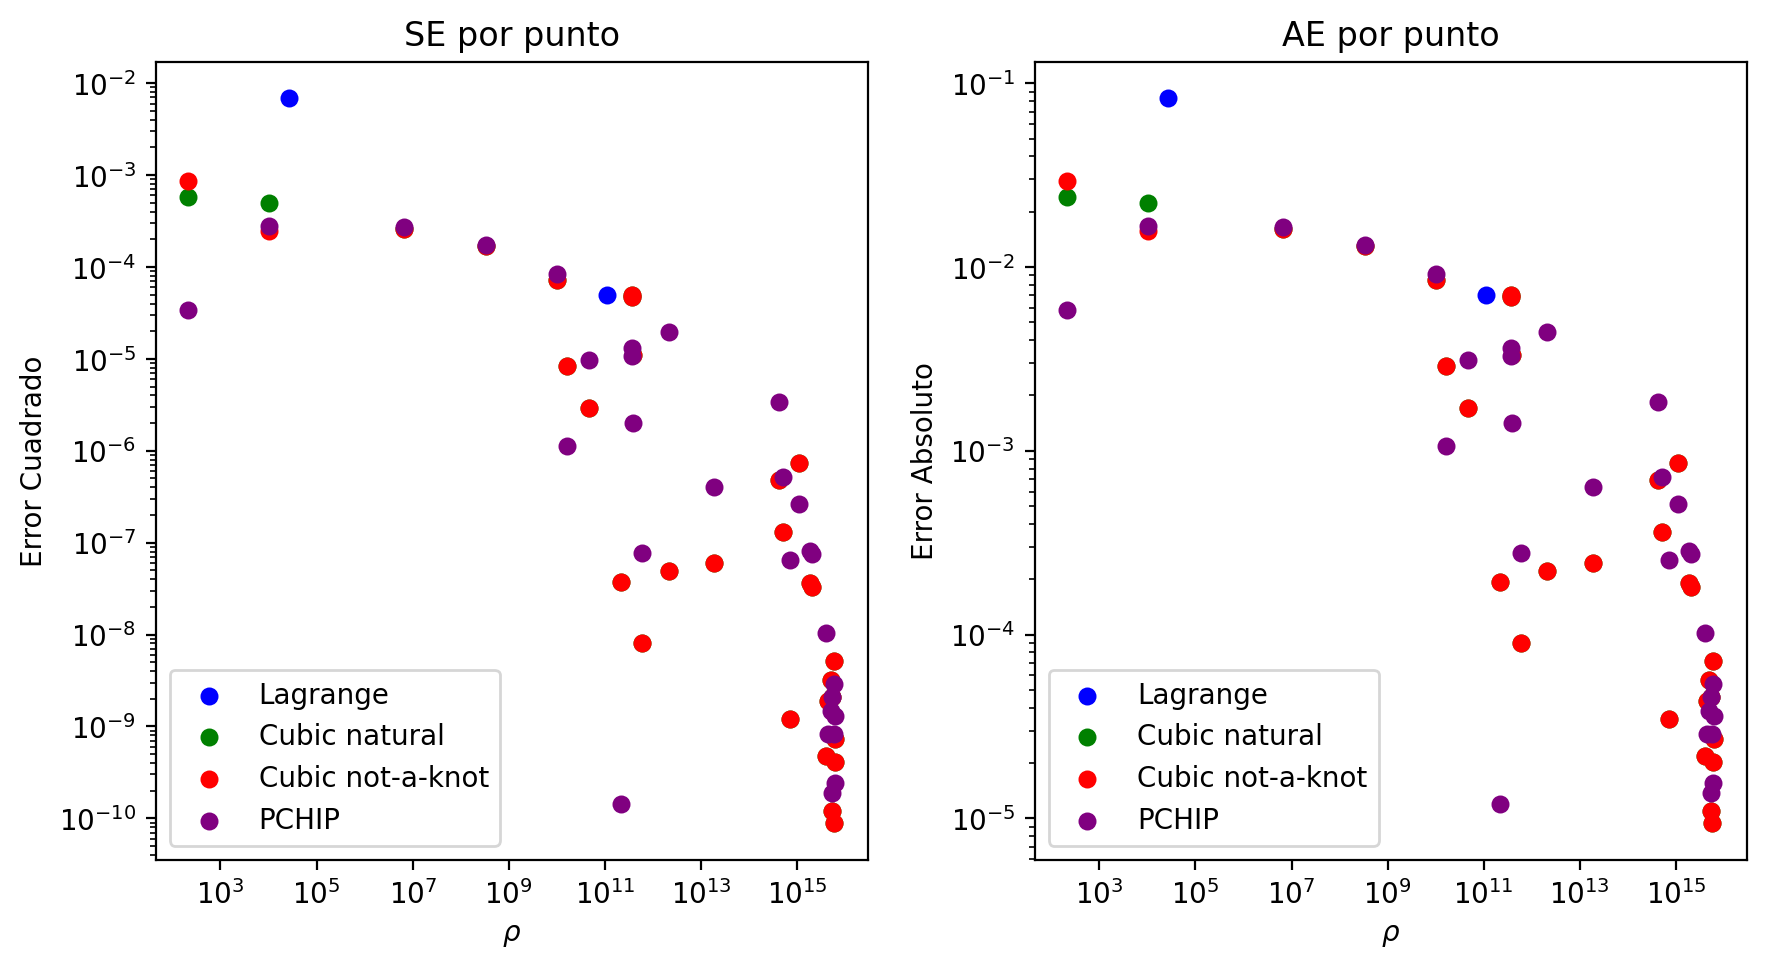

In [326]:
# Interpolamos los datos de train
cs_train_l = lagrange(x_train_l, y_train_l)
cs_train_nat = CubicSpline(x_train_sc, y_train_sc, bc_type='natural')
cs_train_nok = CubicSpline(x_train_sc, y_train_sc, bc_type='not-a-knot')
pchip_train  = PchipInterpolator(x_train_sc, y_train_sc)

# Evaluamos en test
yhat_l = cs_train_l(x_test_l)
yhat_cs_nat = cs_train_nat(x_test_sc)
yhat_cs_nak = cs_train_nok(x_test_sc)
yhat_pchip  = pchip_train(x_test_sc)

# Errores en log-space
se_l = (yhat_l - y_test_l)**2
ae_l = np.abs(yhat_l - y_test_l)

se_cs_nat = (yhat_cs_nat - y_test_sc)**2
ae_cs_nat = np.abs(yhat_cs_nat - y_test_sc)

se_cs_nak = (yhat_cs_nak - y_test_sc)**2
ae_cs_nak = np.abs(yhat_cs_nak - y_test_sc)

se_pchip = (yhat_pchip - y_test_sc)**2
ae_pchip = np.abs(yhat_pchip - y_test_sc)

plt.figure(figsize=(9,5)) #Gráfica SE (Squared Error)
plt.subplot(1,2,1)
plt.scatter(10**x_test_l, se_l,       label='Lagrange',         color='blue', s=30)
plt.scatter(10**x_test_sc, se_cs_nat, label='Cubic natural',    color='green', s=30)
plt.scatter(10**x_test_sc, se_cs_nak, label='Cubic not-a-knot', color='red', s=30)
plt.scatter(10**x_test_sc, se_pchip,  label='PCHIP',            color='purple', s=30)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel('Error Cuadrado')
plt.legend(loc= 'lower left')
plt.title('SE por punto')

plt.subplot(1,2,2) #Gráfica AE (Absolute Error)
plt.scatter(10**x_test_l,  ae_l, color='blue',       label='Lagrange', s=30)
plt.scatter(10**x_test_sc, ae_cs_nat, color='green', label='Cubic natural', s=30)
plt.scatter(10**x_test_sc, ae_cs_nak, color='red',   label='Cubic not-a-knot', s=30)
plt.scatter(10**x_test_sc, ae_pchip, color='purple', label='PCHIP', s=30)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel('Error Absoluto')
plt.title('AE por punto')
plt.tight_layout()
plt.legend(loc= 'lower left')
plt.show()

###Gráfricas de Error Cuadrado y Absoluto para P(n_b)

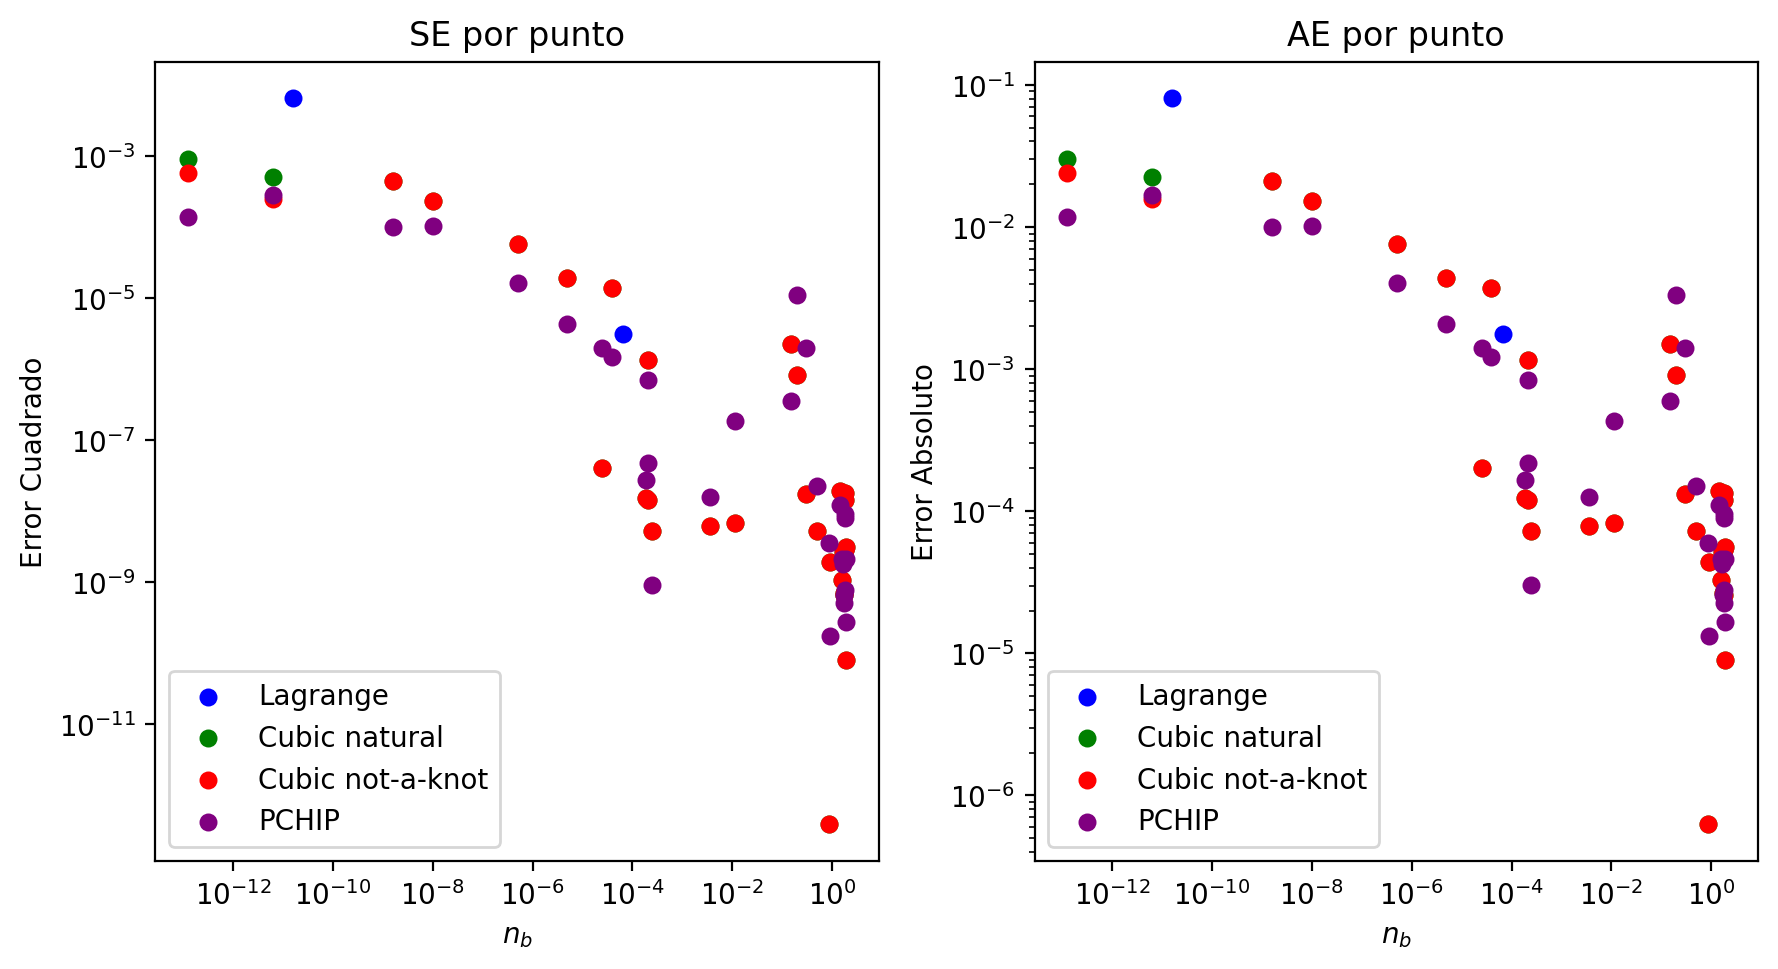

In [327]:
# Interpolamos los datos de train
cs_train_l2 = lagrange(x_train_l2, y_train_l2)
cs_train_nat2 = CubicSpline(x_train_sc2, y_train_sc2, bc_type='natural')
cs_train_nok2 = CubicSpline(x_train_sc2, y_train_sc2, bc_type='not-a-knot')
pchip_train2  = PchipInterpolator(x_train_sc2, y_train_sc2)

# Evaluamos en test
yhat_l2 = cs_train_l2(x_test_l2)
yhat_cs_nat2 = cs_train_nat2(x_test_sc2)
yhat_cs_nak2 = cs_train_nok2(x_test_sc2)
yhat_pchip2 = pchip_train2(x_test_sc2)

# Errores en log-space
se_l2 = (yhat_l2 - y_test_l2)**2
ae_l2 = np.abs(yhat_l2 - y_test_l2)

se_cs_nat2 = (yhat_cs_nat2 - y_test_sc2)**2
ae_cs_nat2 = np.abs(yhat_cs_nat2 - y_test_sc2)

se_cs_nak2 = (yhat_cs_nak2 - y_test_sc2)**2
ae_cs_nak2 = np.abs(yhat_cs_nak2 - y_test_sc2)

se_pchip2 = (yhat_pchip2 - y_test_sc2)**2
ae_pchip2 = np.abs(yhat_pchip2 - y_test_sc2)

plt.figure(figsize=(9,5)) #Gráfica SE (Squared Error)
plt.subplot(1,2,1)
plt.scatter(10**x_test_l2, se_l2,       label='Lagrange',         color='blue', s=30)
plt.scatter(10**x_test_sc2, se_cs_nat2, label='Cubic natural',    color='green', s=30)
plt.scatter(10**x_test_sc2, se_cs_nak2, label='Cubic not-a-knot', color='red', s=30)
plt.scatter(10**x_test_sc2, se_pchip2,  label='PCHIP',            color='purple', s=30)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_b$')
plt.ylabel('Error Cuadrado')
plt.legend(loc= 'lower left')
plt.title('SE por punto')

plt.subplot(1,2,2) #Gráfica AE (Absolute Error)
plt.scatter(10**x_test_l2,  ae_l2, color='blue',       label='Lagrange', s=30)
plt.scatter(10**x_test_sc2, ae_cs_nat2, color='green', label='Cubic natural', s=30)
plt.scatter(10**x_test_sc2, ae_cs_nak2, color='red',   label='Cubic not-a-knot', s=30)
plt.scatter(10**x_test_sc2, ae_pchip2, color='purple', label='PCHIP', s=30)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_b$')
plt.ylabel('Error Absoluto')
plt.title('AE por punto')
plt.tight_layout()
plt.legend(loc= 'lower left')
plt.show()

##Comparaciones


###Ecuación de Estado P(rho)

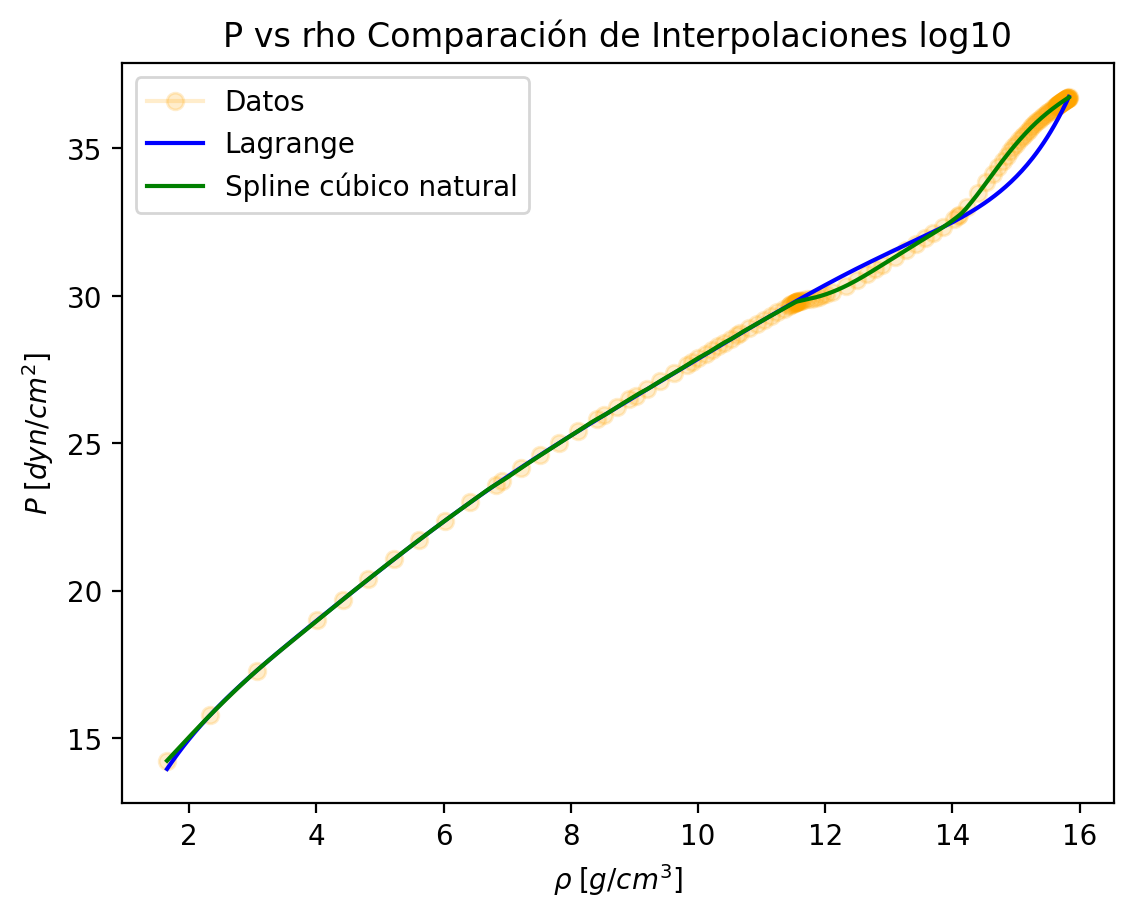

In [328]:
lagrange_interp = lagrange(x_l, y_l)
spline_interp = CubicSpline(x_sc, y_sc, bc_type="natural")
x_new = np.linspace(min(x_sc), max(x_sc), 500)
plt.figure()
plt.plot(x_sc, y_sc, marker='o', color='orange', alpha=0.2, label="Datos")
plt.plot(x_new, lagrange_interp(x_new), label="Lagrange", color='blue')
plt.plot(x_new, spline_interp(x_new), label="Spline cúbico natural", color='green')
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Comparación de Interpolaciones log10")
plt.legend()
plt.show()

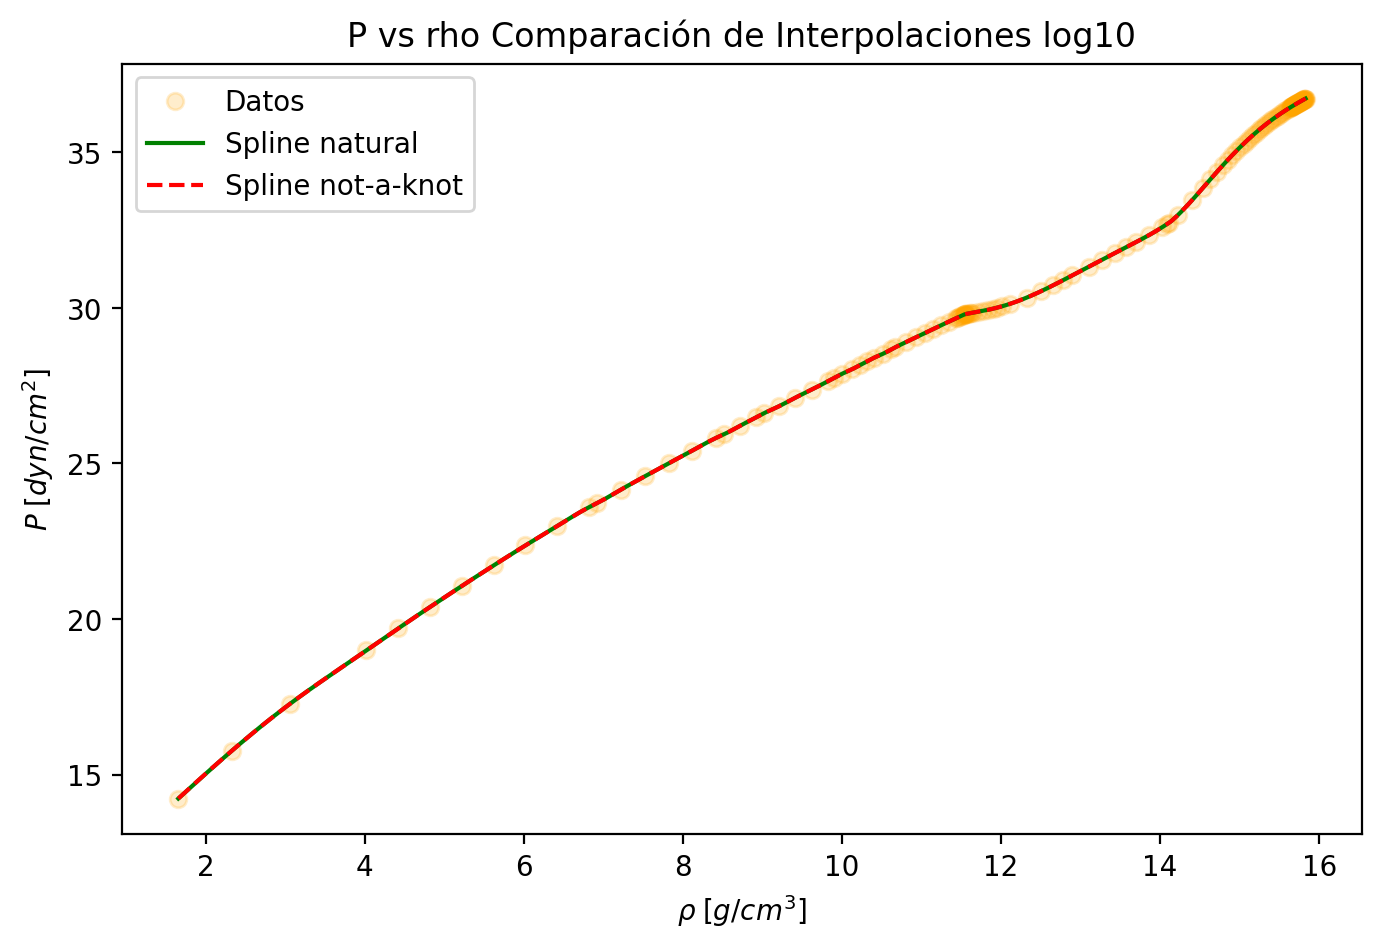

In [329]:
x_new_l = np.linspace(min(x_l), max(x_l), 500)
x_new = np.linspace(min(x_sc), max(x_sc), 500)


plt.figure(figsize=(8,5))
plt.plot(x_sc, y_sc, 'o',           color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, cs_natural(x_new),  color='green',  label="Spline natural")
plt.plot(x_new, cs_not(x_new),'--', color='red',    label="Spline not-a-knot")

plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("Comparación de interpolaciones")
plt.title("P vs rho Comparación de Interpolaciones log10")
plt.show()

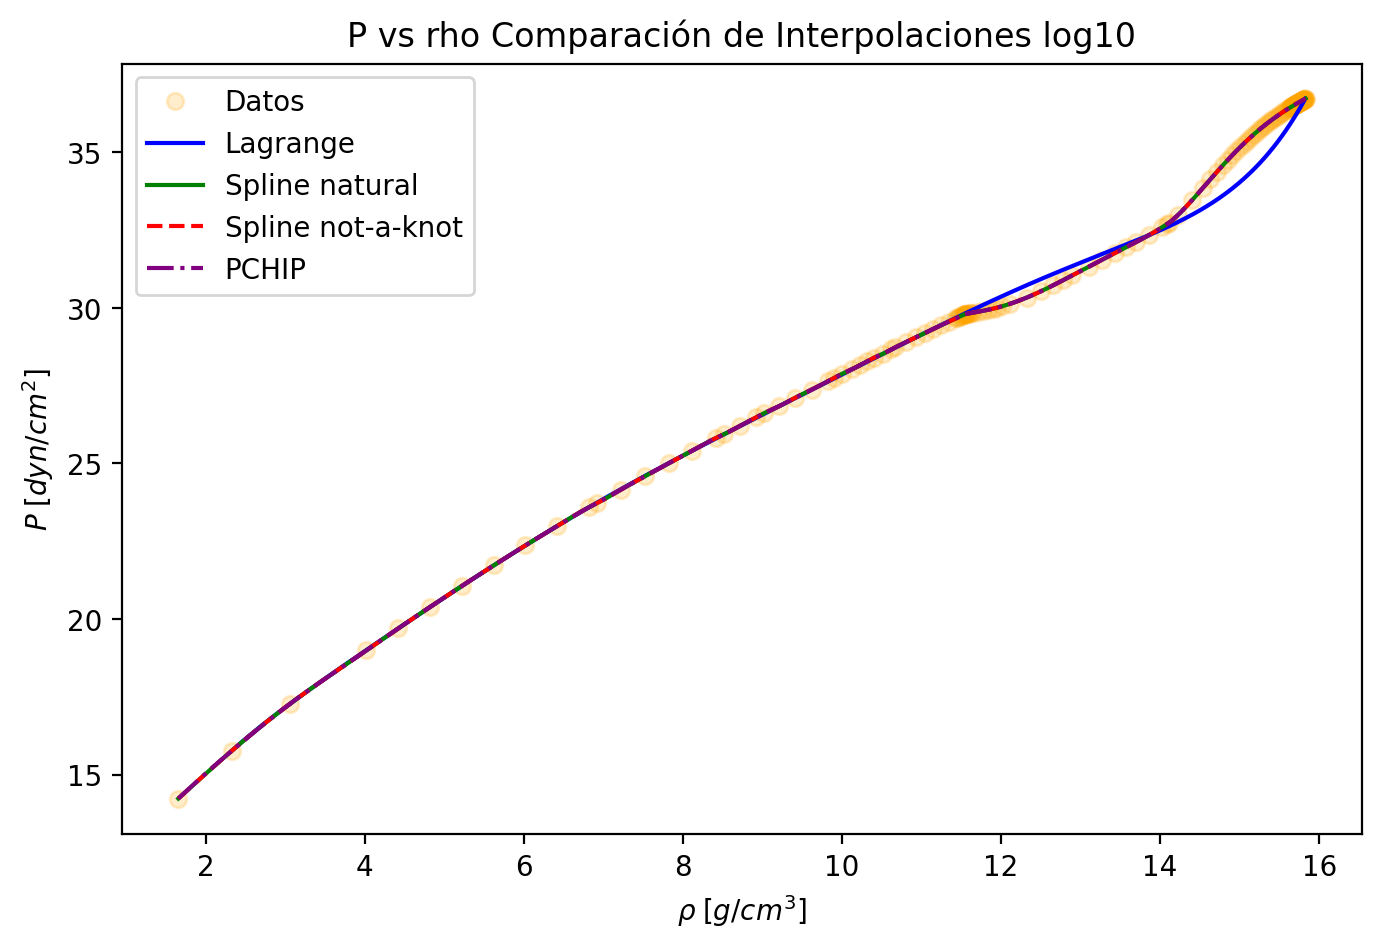

In [330]:
x_new_l = np.linspace(min(x_l), max(x_l), 500)
x_new = np.linspace(min(x_sc), max(x_sc), 500)


plt.figure(figsize=(8,5))
plt.plot(x_sc, y_sc, 'o',           color='orange', label="Datos", alpha=0.2)
plt.plot(x_new_l, poly(x_new_l),    color='blue',   label="Lagrange")
plt.plot(x_new, cs_natural(x_new),  color='green',  label="Spline natural")
plt.plot(x_new, cs_not(x_new),'--', color='red',    label="Spline not-a-knot")
plt.plot(x_new, pchip(x_new), '-.', color='purple', label="PCHIP")

plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Comparación de Interpolaciones log10")
plt.show()

###Ecuación de Estado P(n_B)

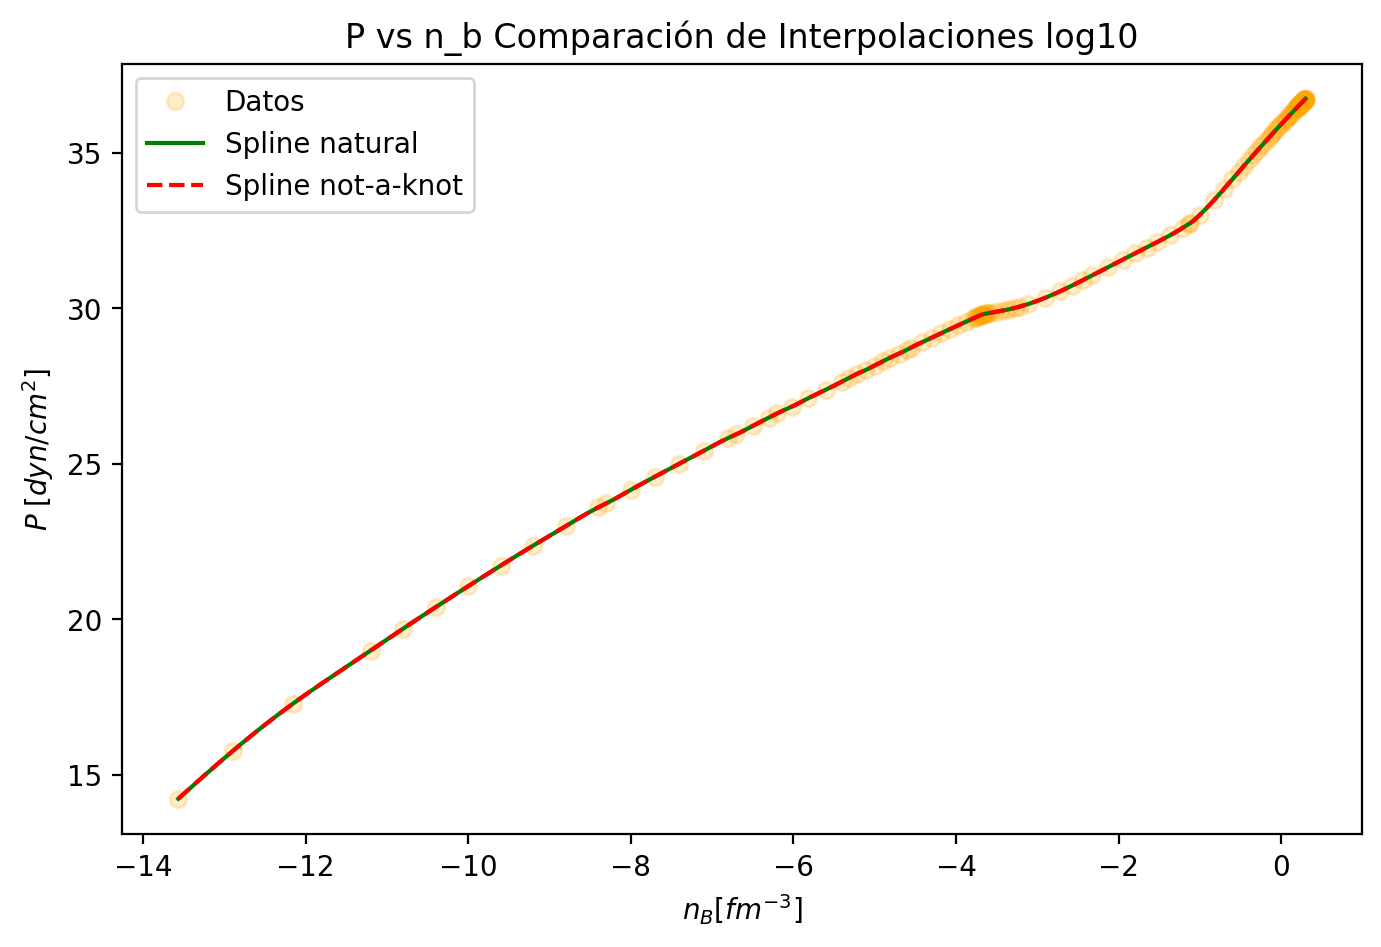

In [331]:
x_new_l2 = np.linspace(min(x_l2), max(x_l2), 500)
x_new2 = np.linspace(min(x_sc2), max(x_sc2), 500)


plt.figure(figsize=(8,5))
plt.plot(x_sc2, y_sc2, 'o',           color='orange', label="Datos", alpha=0.2)
plt.plot(x_new2, cs_natural2(x_new2),  color='green',  label="Spline natural")
plt.plot(x_new2, cs_not2(x_new2),'--', color='red',    label="Spline not-a-knot")

plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Comparación de Interpolaciones log10")
plt.show()

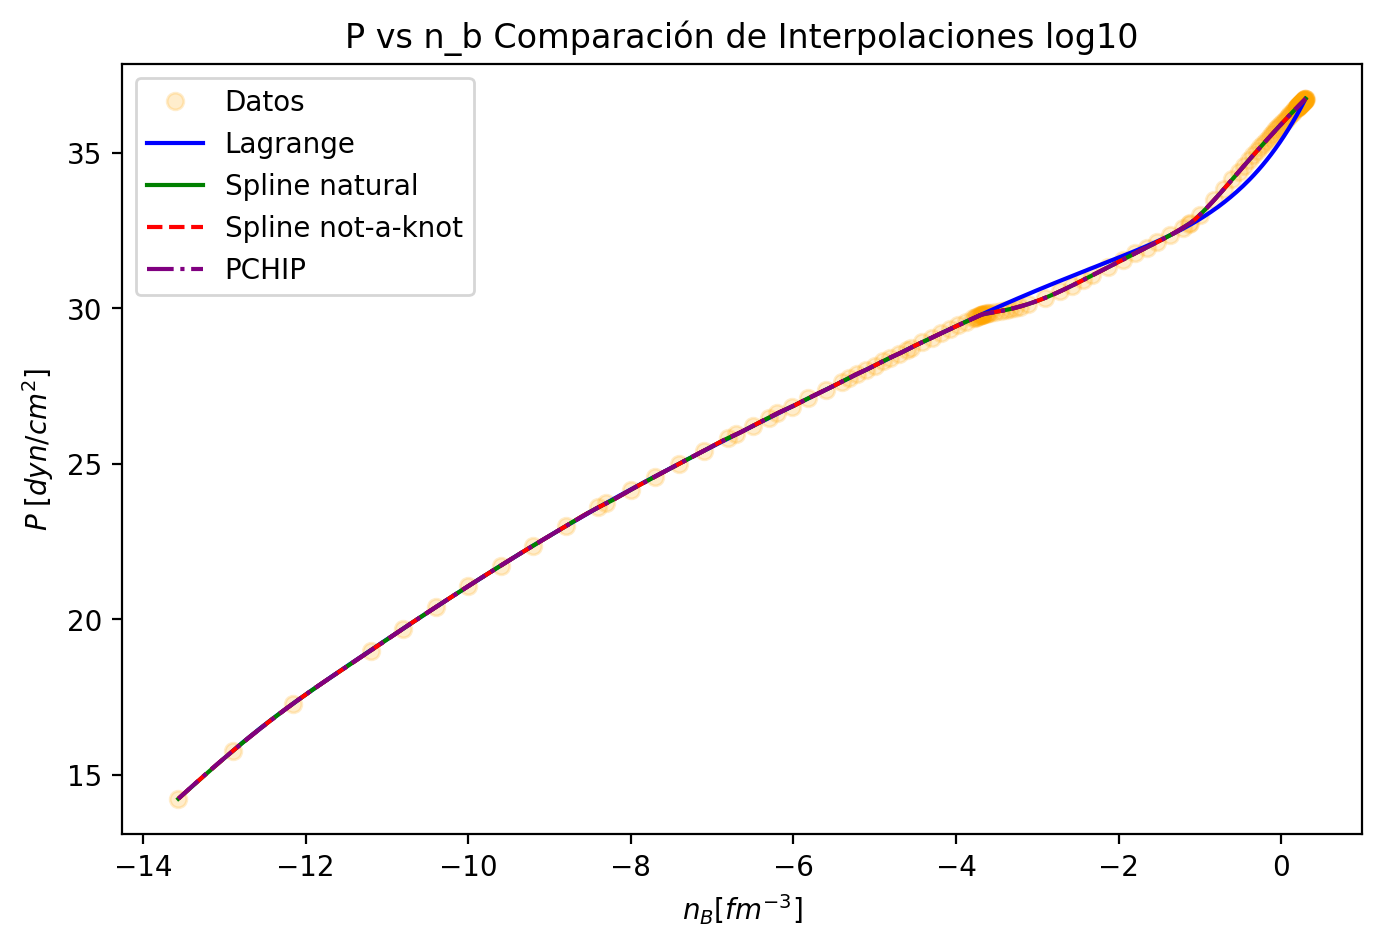

In [332]:
x_new_l2 = np.linspace(min(x_l2), max(x_l2), 500)
x_new2 = np.linspace(min(x_sc2), max(x_sc2), 500)


plt.figure(figsize=(8,5))
plt.plot(x_sc2, y_sc2, 'o',            color='orange', label="Datos", alpha=0.2)
plt.plot(x_new_l2, poly2(x_new_l2),    color='blue',   label="Lagrange")
plt.plot(x_new2, cs_natural2(x_new2),  color='green',  label="Spline natural")
plt.plot(x_new2, cs_not2(x_new2),'--', color='red',    label="Spline not-a-knot")
plt.plot(x_new2, pchip2(x_new2), '-.', color='purple', label="PCHIP")

plt.legend()
plt.xlabel(r"$n_B[fm^{-3}]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs n_b Comparación de Interpolaciones log10")
plt.show()

# **Segunda Parte**

**Nomenclatura para no volvernos locos**



*   x_l --> Dataframe para rho (lagrange)
*   x_l2 --> Dataframe para n_b (lagrange)
*   y_l --> Dataframe para P (lagrange)
*   y_l2 --> Dataframe para P (lagrange)
*   x_sc --> Dataframe para rho (cubic spline, phip)
*   x_sc2 --> Dataframe para n_b (cubic spline, phip)
*   y_sc --> Dataframe para P (cubic spline, phip)
*   y_sc2 --> Dataframe para P (cubic spline, phip)




In [333]:
#Importamos los dataframes necesarios para la derivación

P = dataframe["P[dyn/cm^2]"]
rho = dataframe["rho[g/cm^3]"]
nb = dataframe["n_B[fm^{-3}]"]

print(rho.max())

6749000000000000.0


##Derivada numérica con diferencias finitas


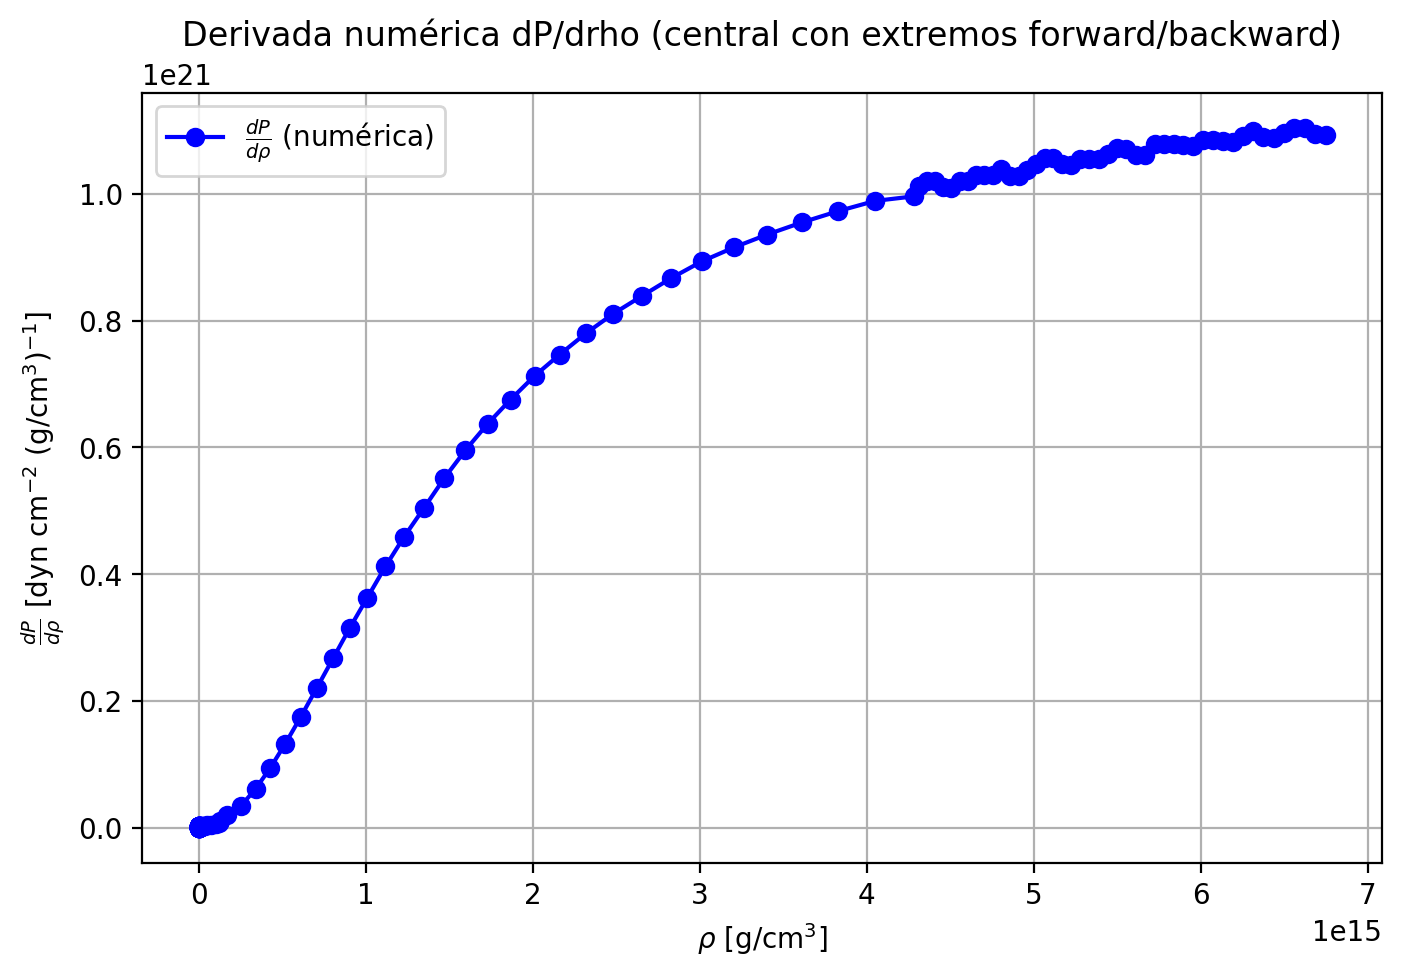

In [334]:
dP_drho = np.zeros_like(P)

for i in range(1, len(rho) - 1):
    dP_drho[i] = (P[i+1] - P[i-1]) / (rho[i+1] - rho[i-1])

#Aplicando las definiciones de Forward y Backward respectivamente
dP_drho[0] = (dataframe["P[dyn/cm^2]"].iloc[1] - dataframe["P[dyn/cm^2]"].iloc[0]) / (dataframe["rho[g/cm^3]"].iloc[1] - dataframe["rho[g/cm^3]"].iloc[0])
dP_drho[-1] = (dataframe["P[dyn/cm^2]"].iloc[-1] - dataframe["P[dyn/cm^2]"].iloc[-2]) / (dataframe["rho[g/cm^3]"].iloc[-1] - dataframe["rho[g/cm^3]"].iloc[-2])
dataframe["dP/drho"] = dP_drho

plt.figure(figsize=(8,5))
plt.plot(rho, dP_drho, marker='o', linestyle='-', color='b', label=r"$\frac{dP}{d\rho}$ (numérica)")
plt.xlabel(r"$\rho\ [\mathrm{g/cm^3}]$")
plt.ylabel(r"$\frac{dP}{d\rho}\ [\mathrm{dyn\ cm^{-2}\ (g/cm^3)^{-1}}]$")
plt.title("Derivada numérica dP/drho (central con extremos forward/backward)")
plt.legend()
plt.grid(True)
plt.show()

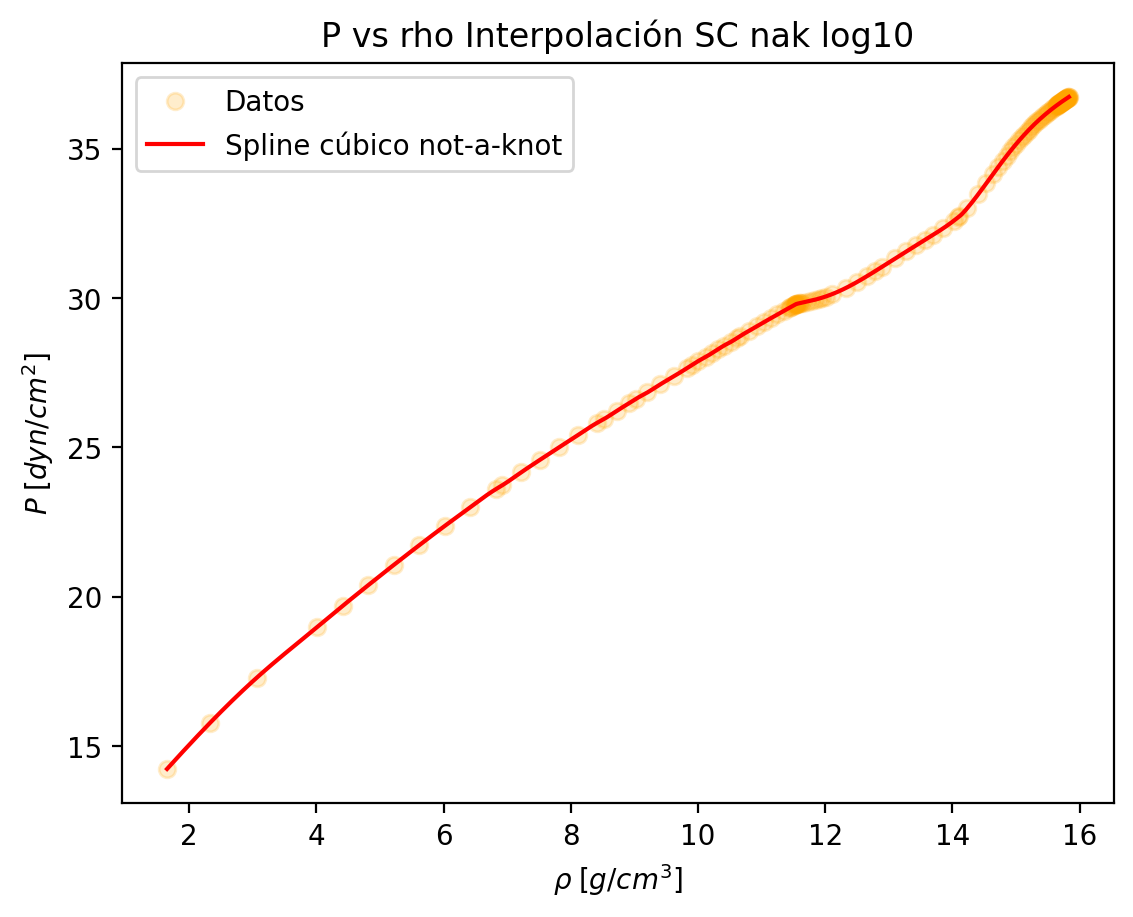

In [335]:
cs_notaknot = CubicSpline(x_sc, y_sc, bc_type="not-a-knot")
x_new = np.linspace(min(x_sc), max(x_sc), 500)

plt.figure()
plt.plot(x_sc, y_sc, 'o', color='orange', label="Datos", alpha=0.2)
plt.plot(x_new, cs_notaknot(x_new), color="red", label="Spline cúbico not-a-knot")
plt.legend()
plt.xlabel(r"$\rho\;[g/cm^3]$")
plt.ylabel(r"$P\;[dyn/cm^2]$")
plt.title("P vs rho Interpolación SC nak log10")
plt.show()

##  Densidad de masa cuando es igual a la velocidad de la luz


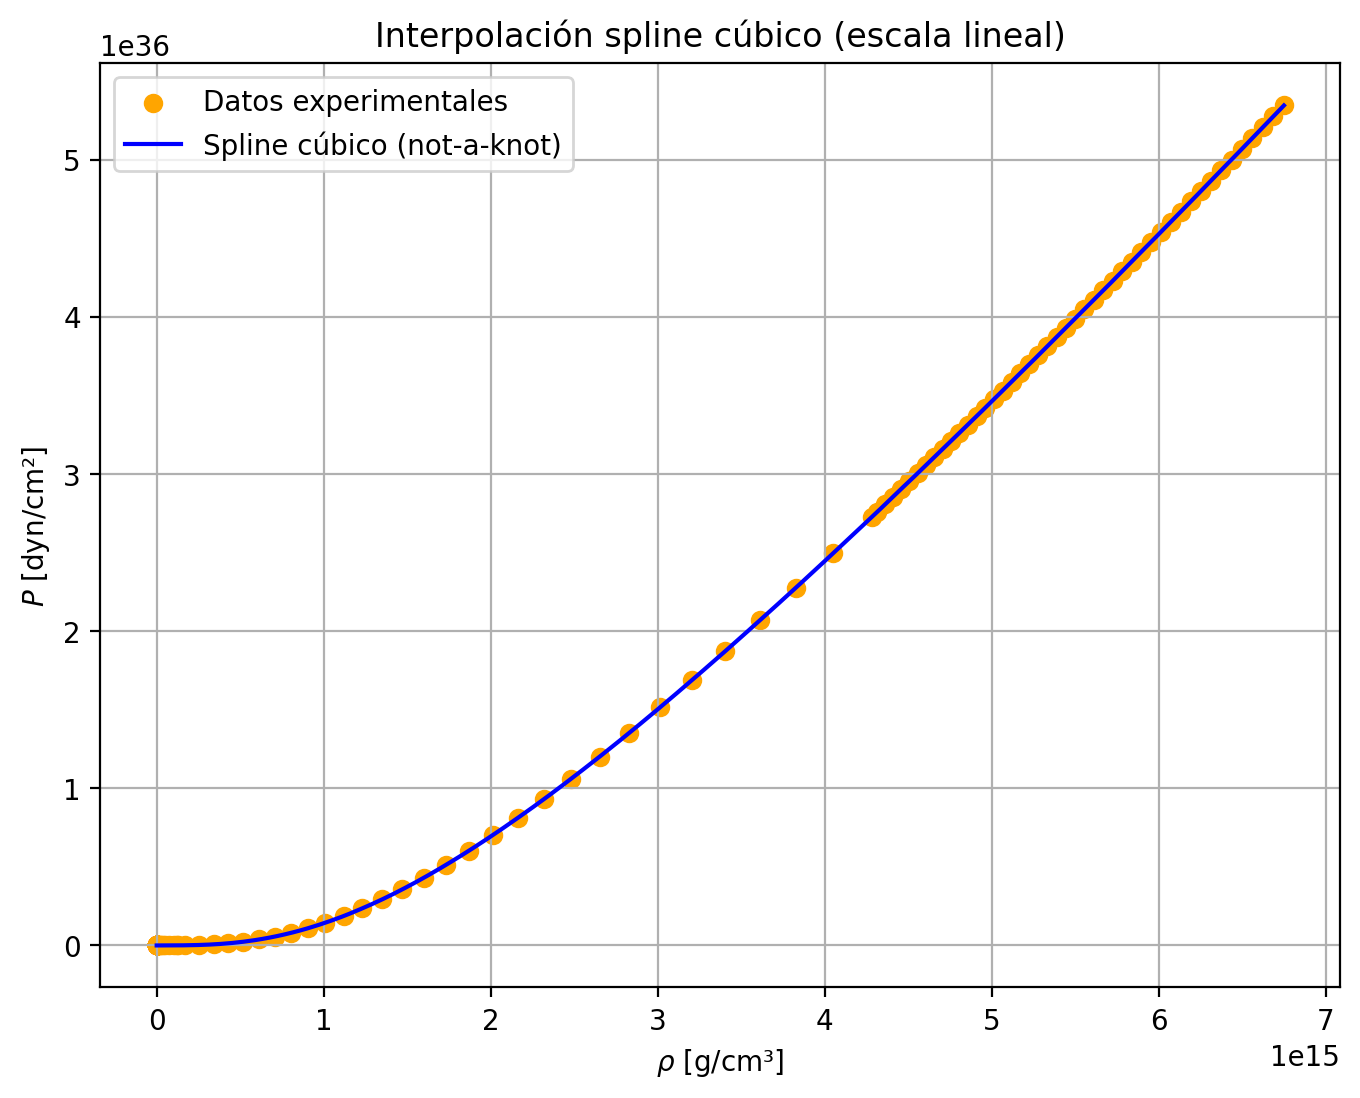

In [336]:
x_0 = dataframe["rho[g/cm^3]"].values
y_0 = dataframe["P[dyn/cm^2]"].values
cs_notaknot = CubicSpline(x_0, y_0, bc_type='not-a-knot')

x_interp = np.linspace(min(x_0), max(x_0), 300)
y_interp = cs_notaknot(x_interp)

plt.figure(figsize=(8,6))
plt.scatter(x_0, y_0, color='orange', label='Datos experimentales')
plt.plot(x_interp, y_interp, 'b-', label='Spline cúbico (not-a-knot)')
plt.xlabel(r'$\rho$ [g/cm³]')
plt.ylabel(r'$P$ [dyn/cm²]')
plt.title('Interpolación spline cúbico (escala lineal)')
plt.legend()
plt.grid(True)
plt.show()

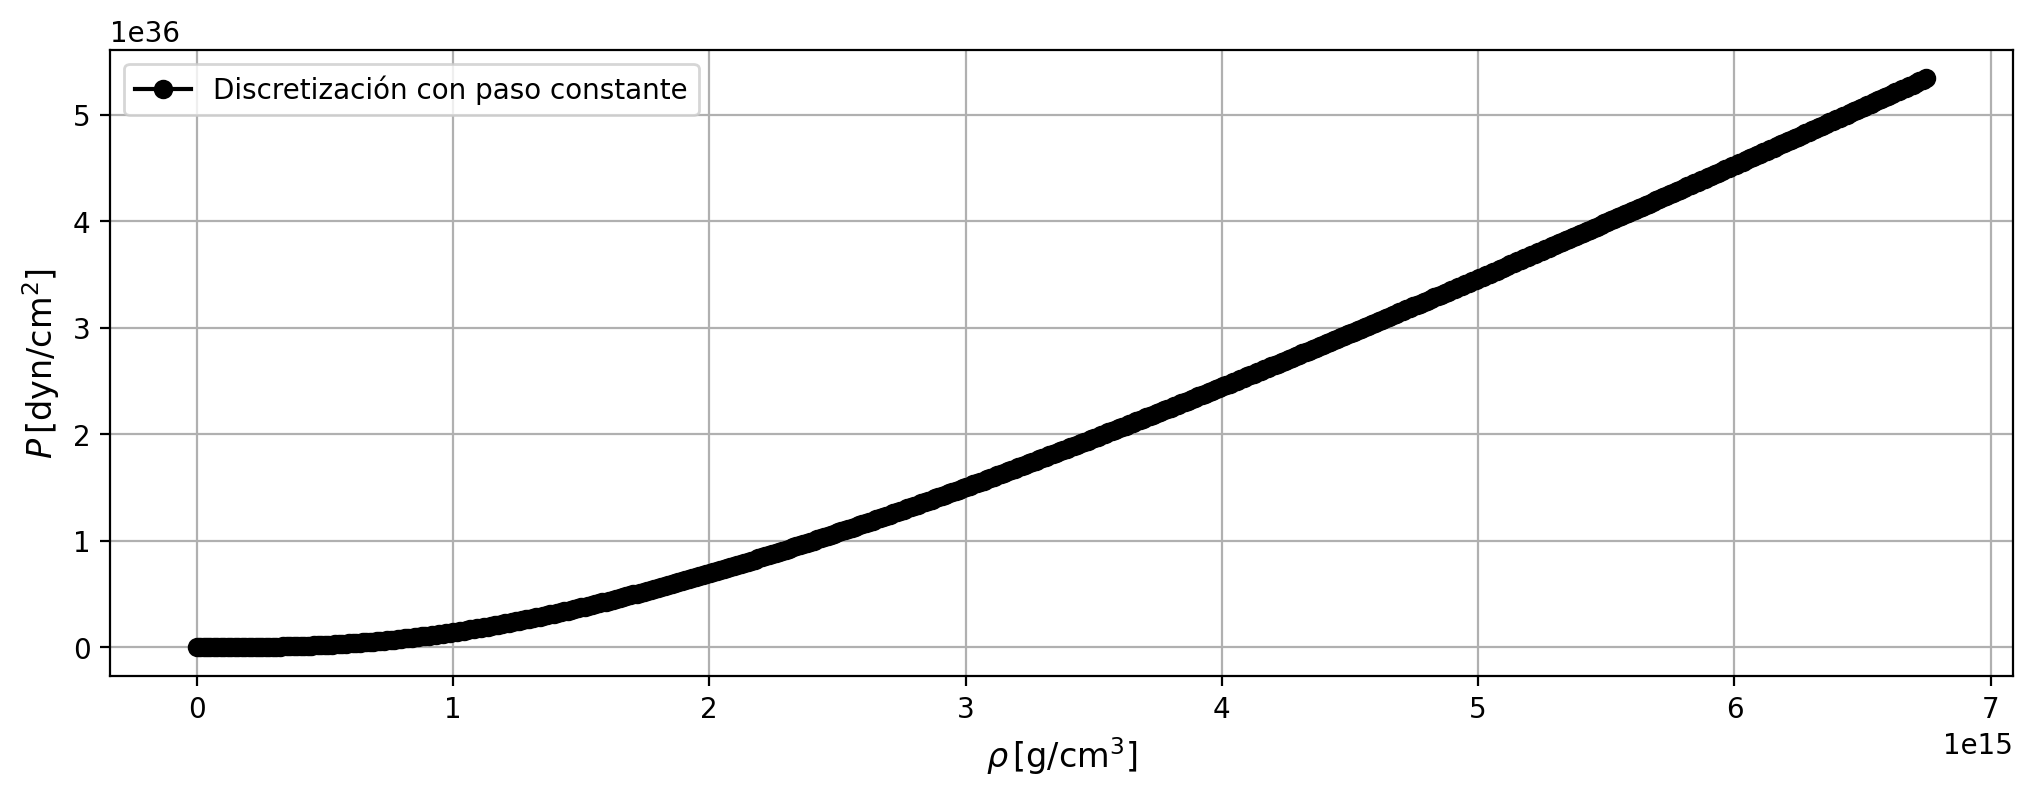

In [337]:
#Usando Spline Cubico not a knot
cs_notaknot = CubicSpline(x_0, y_0, bc_type='not-a-knot')

step = 500
x_interp = np.linspace(min(x_0), max(x_0), step)
y_interp = cs_notaknot(x_interp)

plt.figure(figsize=(10, 4))
plt.plot(x_interp, y_interp, 'o-', color='black', markersize=6, label='Discretización con paso constante')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel(r'$\rho \, [\mathrm{g/cm}^3]$', fontsize=12)
plt.ylabel(r'$P \, [\mathrm{dyn/cm}^2]$', fontsize=12)
plt.show()

Paso constante h = 1.353e+13


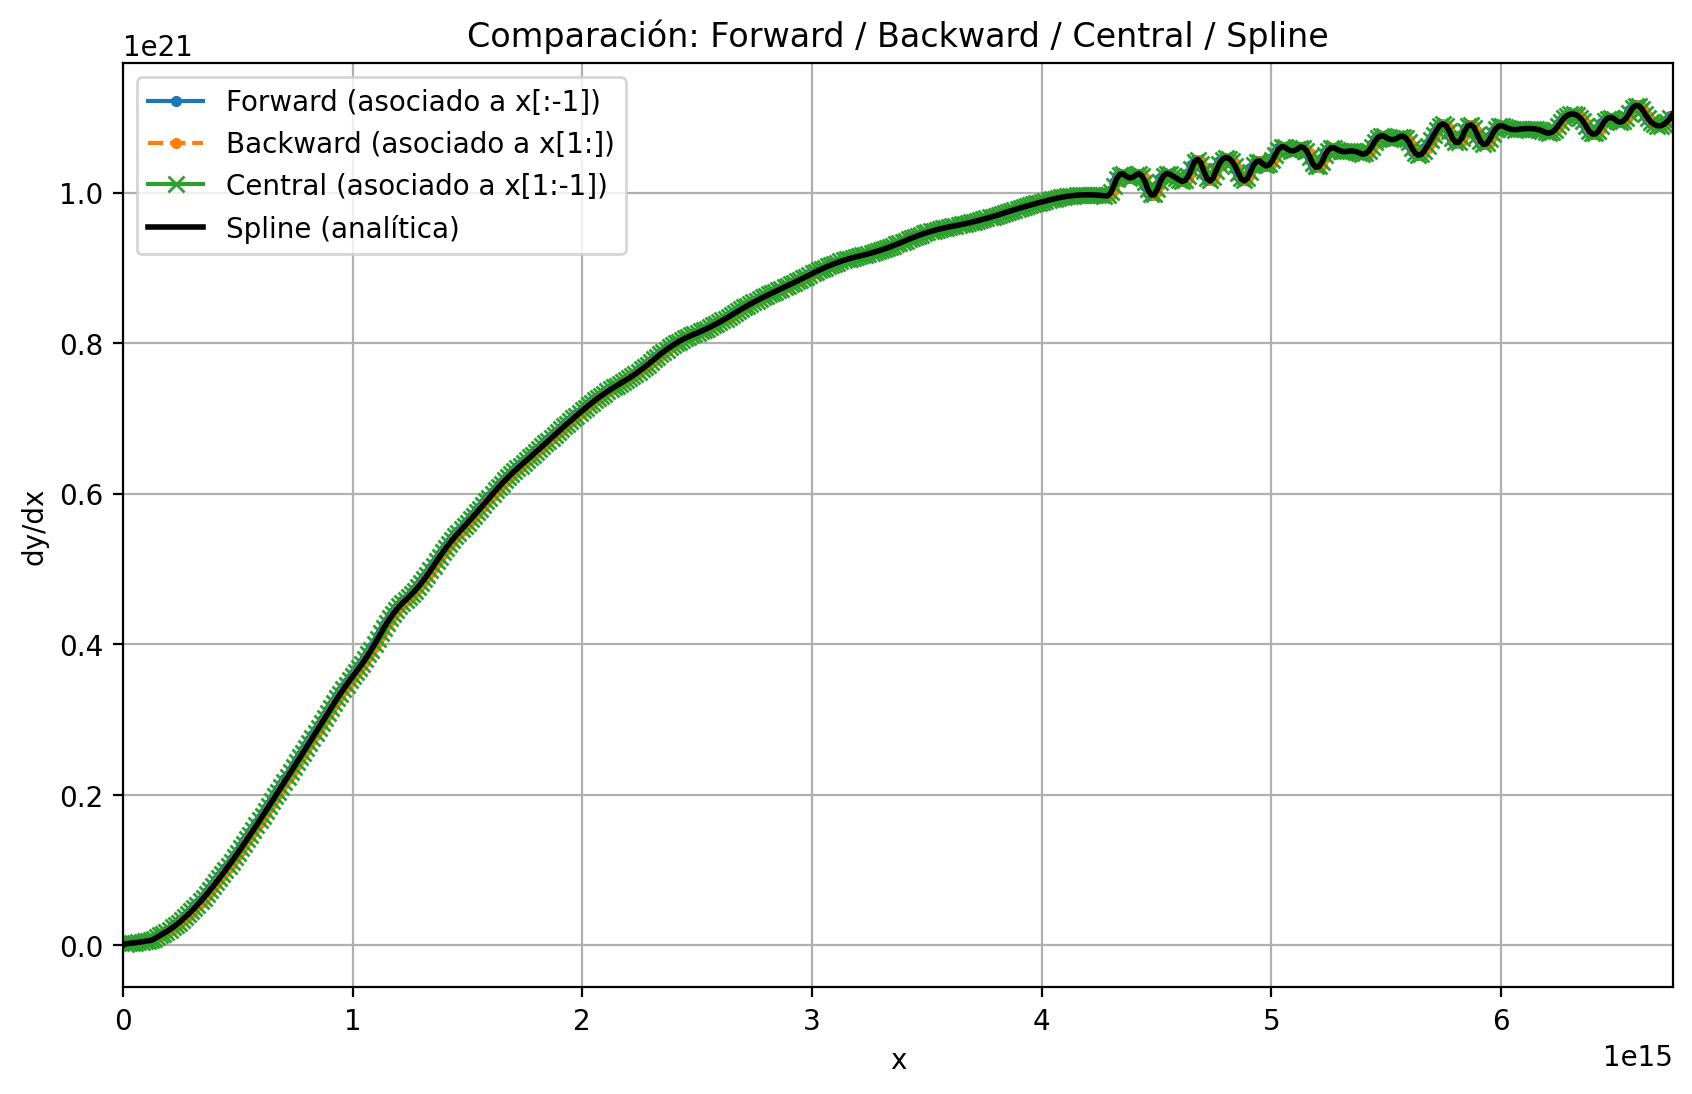

In [338]:
x_interp = np.linspace(x0[0], x0[-1], step)
h = x_interp[1] - x_interp[0]
y_interp = cs_notaknot(x_interp)
print(f"Paso constante h = {h:.3e}")

#Derivadas Numericas
v_forward = np.full_like(x_interp, np.nan)
v_backward = np.full_like(x_interp, np.nan)
v_central = np.full_like(x_interp, np.nan)

v_forward[:-1]  = (y_interp[1:]  - y_interp[:-1]) / h   # asociado a x_interp[:-1]
v_backward[1:]  = (y_interp[1:]  - y_interp[:-1]) / h   # asociado a x_interp[1:]
v_central[1:-1] = (y_interp[2:]  - y_interp[:-2]) / (2*h)  # asociado a x_interp[1:-1]

# Derivada analítica
v_spline = cs_notaknot.derivative(1)(x_interp)

plt.figure(figsize=(10,6))
plt.plot(x_interp, v_forward, '.-',  label='Forward (asociado a x[:-1])')
plt.plot(x_interp, v_backward, '.--', label='Backward (asociado a x[1:])')
plt.plot(x_interp, v_central, 'x-',  label='Central (asociado a x[1:-1])')
plt.plot(x_interp, v_spline, 'k-', linewidth=2, label='Spline (analítica)')
plt.xlim(x0[0], x0[-1])
plt.xlabel('x'); plt.ylabel("dy/dx")
plt.title('Comparación: Forward / Backward / Central / Spline')
plt.legend(); plt.grid(True); plt.show()

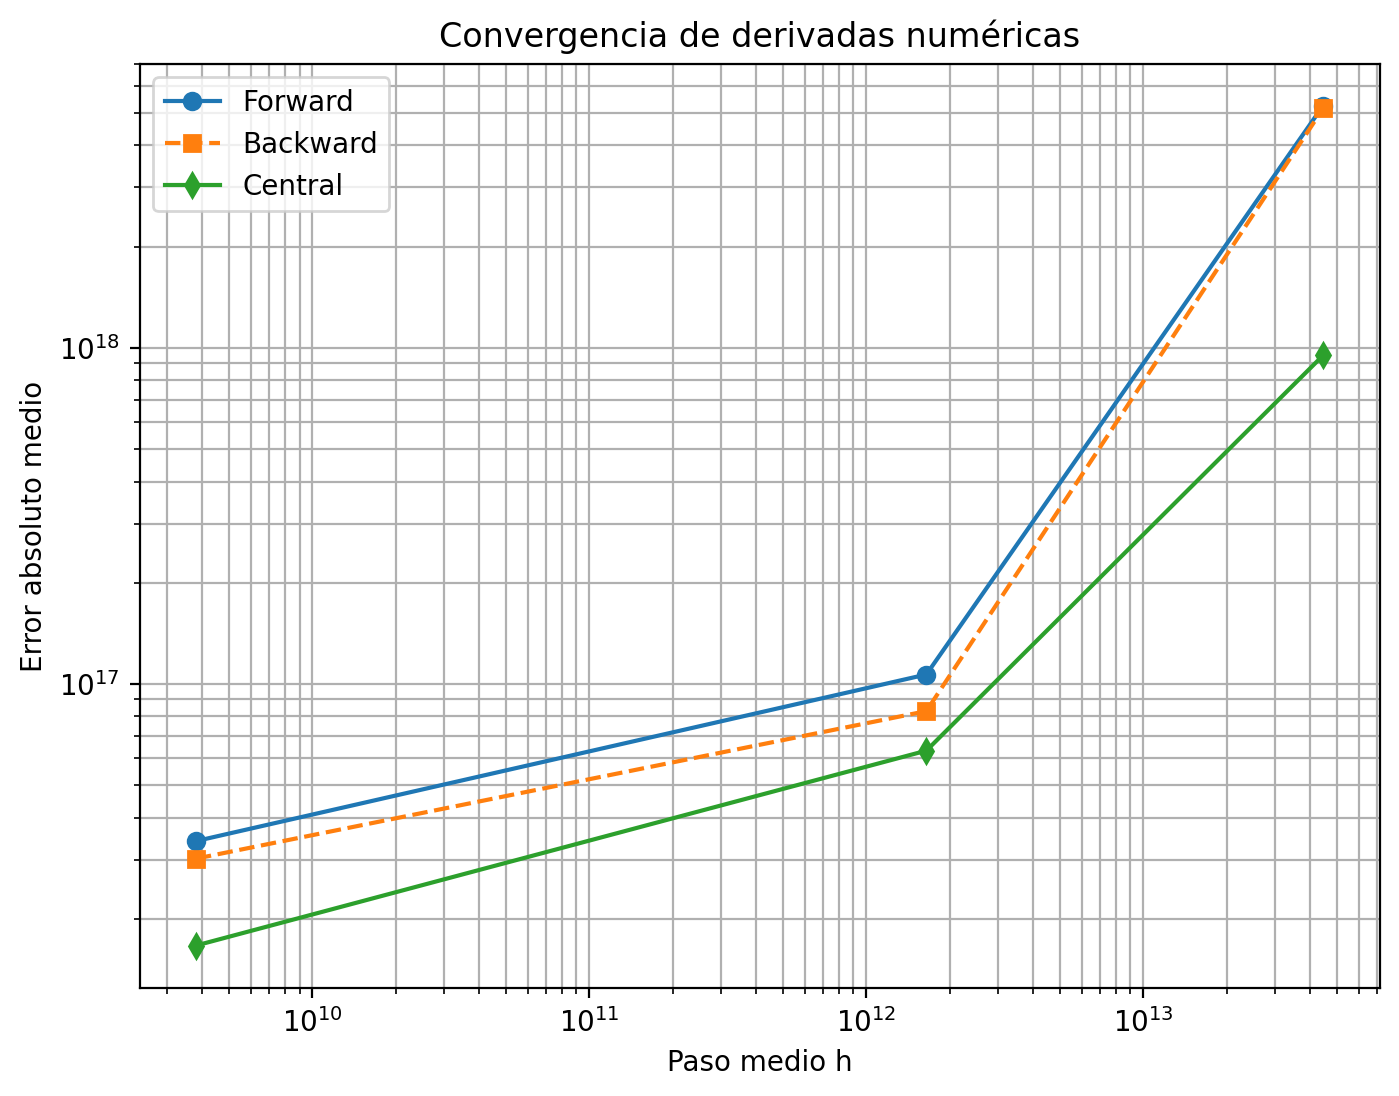

In [339]:
subset_sizes = [len(x0)//4, len(x0)//2, len(x0)]
errors_forward, errors_backward, errors_central = [], [], []
h_mean = []

for n in subset_sizes:
    xs = x0[:n]
    ys = y0[:n]

    cs = CubicSpline(xs, ys, bc_type='not-a-knot')
    ys_interp = cs(xs)
    vs_true = cs.derivative(1)(xs)

    h = np.diff(xs)

    v_forward = np.zeros_like(ys_interp)
    v_forward[:-1] = np.diff(ys_interp) / h
    v_forward[-1] = np.nan

    v_backward = np.zeros_like(ys_interp)
    v_backward[1:] = np.diff(ys_interp) / h
    v_backward[0] = np.nan

    v_central = np.zeros_like(ys_interp)
    v_central[1:-1] = (ys_interp[2:] - ys_interp[:-2]) / (xs[2:] - xs[:-2])
    v_central[0] = np.nan
    v_central[-1] = np.nan

    h_mean.append(np.mean(h))
    errors_forward.append(np.nanmean(np.abs(v_forward - vs_true)))
    errors_backward.append(np.nanmean(np.abs(v_backward - vs_true)))
    errors_central.append(np.nanmean(np.abs(v_central - vs_true)))

plt.figure(figsize=(8,6))
plt.loglog(h_mean, errors_forward, 'o-', label='Forward')
plt.loglog(h_mean, errors_backward, 's--', label='Backward')
plt.loglog(h_mean, errors_central, 'd-', label='Central')
plt.xlabel('Paso medio h')
plt.ylabel('Error absoluto medio')
plt.title('Convergencia de derivadas numéricas')
plt.legend()
plt.grid(True, which='both')
plt.show()

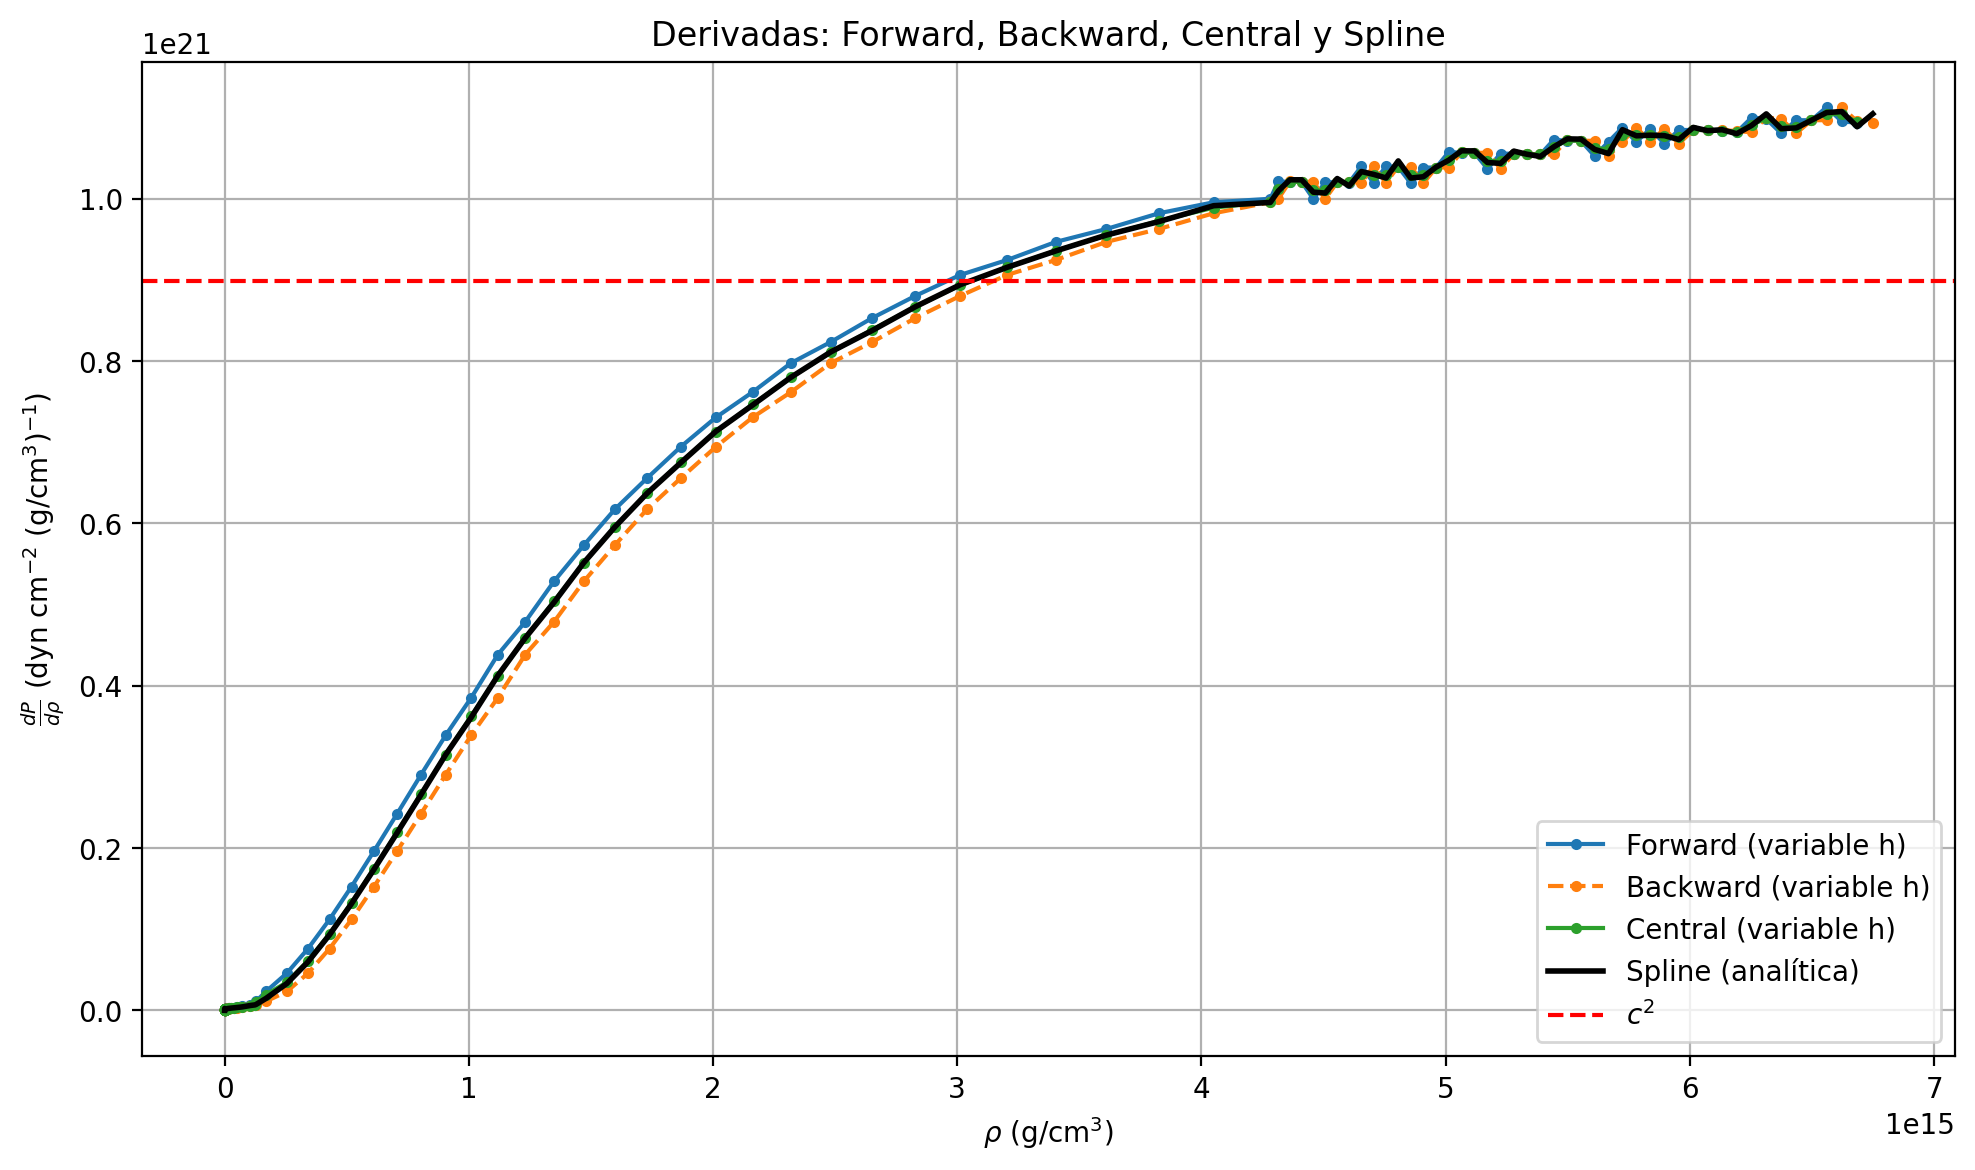

c² = 8.988e+20 cm²/s²


In [340]:
y_interp = cs_notaknot(x0)
v_spline = cs_notaknot.derivative(1)(x0)

h = np.diff(x0)
v_forward = np.zeros_like(y_interp)
v_forward[:-1] = np.diff(y_interp) / h
v_forward[-1] = np.nan

v_backward = np.zeros_like(y_interp)
v_backward[1:] = np.diff(y_interp) / h
v_backward[0] = np.nan

v_central = np.zeros_like(y_interp)
v_central[1:-1] = (y_interp[2:] - y_interp[:-2]) / (x0[2:] - x0[:-2])
v_central[0] = np.nan
v_central[-1] = np.nan

# --- Constante física: velocidad de la luz al cuadrado ---
c = 2.99792458e10  # cm/s
c2 = c**2          # cm²/s²

# --- Gráfica ---
plt.figure(figsize=(10,6))
plt.plot(x0, v_forward, '.-', label='Forward (variable h)')
plt.plot(x0, v_backward, '.--', label='Backward (variable h)')
plt.plot(x0, v_central, '.-', label='Central (variable h)')
plt.plot(x0, v_spline, 'k-', linewidth=2, label='Spline (analítica)')
plt.axhline(y=c2, color='red', linestyle='--', linewidth=1.5, label=r'$c^2$')

plt.xlabel(r'$\rho\ \mathrm{(g/cm^3)}$')
plt.ylabel(r'$\frac{dP}{d\rho}\ \mathrm{(dyn\ cm^{-2}\ (g/cm^3)^{-1})}$')
plt.title('Derivadas: Forward, Backward, Central y Spline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"c² = {c2:.3e} cm²/s²")

In [341]:
#Imprimimos los resultados númericos de todos las derivadas

print("\nValores comparativos de derivadas (primeros 10 puntos):")
print(f"{'x':>12} | {'Forward':>12} | {'Backward':>12} | {'Central':>12} | {'Spline (teórica)':>18}")
print("-"*70)
for i in range(10):
    print(f"{x_interp[i]:12.3e} | {v_forward[i]:12.3e} | {v_backward[i]:12.3e} | {v_central[i]:12.3e} | {v_spline[i]:18.3e}")

#Calculamos el error promedio
mask = ~np.isnan(v_central)
error_forward = np.nanmean(np.abs(v_forward - v_spline))
error_backward = np.nanmean(np.abs(v_backward - v_spline))
error_central = np.nanmean(np.abs(v_central[mask] - v_spline[mask]))

print("\nErrores medios absolutos respecto al spline analítico:")
print(f"Forward  -> {error_forward:.3e}")
print(f"Backward -> {error_backward:.3e}")
print(f"Central  -> {error_central:.3e}")


Valores comparativos de derivadas (primeros 10 puntos):
           x |      Forward |     Backward |      Central |   Spline (teórica)
----------------------------------------------------------------------
   4.510e+01 |    3.385e+13 |          nan |          nan |          3.881e+12
   1.353e+13 |    1.964e+14 |    3.385e+13 |    1.718e+14 |          6.300e+13
   2.705e+13 |    1.028e+15 |    1.964e+14 |    9.521e+14 |          3.038e+14
   4.058e+13 |    2.531e+15 |    1.028e+15 |    1.974e+15 |          1.670e+15
   5.410e+13 |    4.878e+15 |    2.531e+15 |    4.210e+15 |          3.305e+15
   6.763e+13 |    9.122e+15 |    4.878e+15 |    7.913e+15 |          6.294e+15
   8.115e+13 |    1.645e+16 |    9.122e+15 |    1.436e+16 |          1.161e+16
   9.468e+13 |    2.851e+16 |    1.645e+16 |    2.507e+16 |          2.069e+16
   1.082e+14 |    4.713e+16 |    2.851e+16 |    4.183e+16 |          3.499e+16
   1.217e+14 |    7.402e+16 |    4.713e+16 |    6.636e+16 |          5.849e+16

Er

In [342]:
print("Magnitud típica de derivada spline:", np.nanmean(np.abs(v_spline)))


Magnitud típica de derivada spline: 4.257020156602121e+20


In [343]:
# Evitar nan en central
mask = ~np.isnan(v_central)

error_forward = np.nanmean(np.abs(v_forward - v_spline))
error_backward = np.nanmean(np.abs(v_backward - v_spline))
error_central = np.nanmean(np.abs(v_central[mask] - v_spline[mask]))

print("\nErrores medios absolutos respecto al spline analítico:")
print(f"Forward  -> {error_forward:.3e}")
print(f"Backward -> {error_backward:.3e}")
print(f"Central  -> {error_central:.3e}")



Errores medios absolutos respecto al spline analítico:
Forward  -> 5.259e+18
Backward -> 5.164e+18
Central  -> 9.502e+17


In [344]:
# Calculamso los errores relativos y el error máximo de cada uno de los metodos
mean_vs = np.nanmean(np.abs(v_spline))
max_err_forward = np.nanmax(np.abs(v_forward - v_spline))
max_err_backward = np.nanmax(np.abs(v_backward - v_spline))
max_err_central = np.nanmax(np.abs(v_central - v_spline))

err_rel_forward = error_forward / mean_vs
err_rel_backward = error_backward / mean_vs
err_rel_central = error_central / mean_vs

print("\nErrores adicionales:")
print(f"Media | Forward  -> {error_forward:.3e}, Relativo -> {err_rel_forward:.3e}, Máx -> {max_err_forward:.3e}")
print(f"Media | Backward -> {error_backward:.3e}, Relativo -> {err_rel_backward:.3e}, Máx -> {max_err_backward:.3e}")
print(f"Media | Central  -> {error_central:.3e}, Relativo -> {err_rel_central:.3e}, Máx -> {max_err_central:.3e}")


Errores adicionales:
Media | Forward  -> 5.259e+18, Relativo -> 1.235e-02, Máx -> 2.593e+19
Media | Backward -> 5.164e+18, Relativo -> 1.213e-02, Máx -> 2.726e+19
Media | Central  -> 9.502e+17, Relativo -> 2.232e-03, Máx -> 7.029e+18


In [345]:
def refine_by_subdivision(x, factor):
    xs = []
    for i in range(len(x)-1):
        xs_interval = np.linspace(x[i], x[i+1], factor+1, endpoint=False)
        xs.append(xs_interval)
    xs = np.concatenate(xs)
    xs = np.append(xs, x[-1])
    return xs

factors = [1, 2, 4]  #Para h, h/2 y h/4
errors = []

for fac in factors:
    x_ref = refine_by_subdivision(x0, fac)
    y_ref = cs_notaknot(x_ref)
    # derivadas numéricas:
    h = np.diff(x_ref)
    v_f = np.zeros_like(y_ref)
    v_f[:-1] = np.diff(y_ref)/h
    v_f[-1] = np.nan
    v_b = np.zeros_like(y_ref)
    v_b[1:] = np.diff(y_ref)/h
    v_b[0] = np.nan
    v_c = np.zeros_like(y_ref)
    v_c[1:-1] = (y_ref[2:]-y_ref[:-2])/(x_ref[2:]-x_ref[:-2])
    v_c[0]=v_c[-1]=np.nan

    v_spline_ref = cs_notaknot.derivative(1)(x_ref)

    # máscaras para excluir extremos
    mask_f = ~np.isnan(v_f)
    mask_b = ~np.isnan(v_b)
    mask_c = ~np.isnan(v_c)

    e_f = np.nanmean(np.abs(v_f[mask_f] - v_spline_ref[mask_f]))
    e_b = np.nanmean(np.abs(v_b[mask_b] - v_spline_ref[mask_b]))
    e_c = np.nanmean(np.abs(v_c[mask_c] - v_spline_ref[mask_c]))
    errors.append((e_f,e_b,e_c))

# mostrar y calcular orden empírico
c2 = 2.99792458e10**2
for i, fac in enumerate(factors):
    ef, eb, ec = errors[i]
    rel_f = ef/c2
    rel_c = ec/c2
    p_f = p_c = np.nan
    if i>0:
        p_f = np.log(errors[i-1][0]/ef)/np.log(2)
        p_c = np.log(errors[i-1][2]/ec)/np.log(2)
    print(f"factor {fac:2d} -> E_f={ef:.3e} (rel {rel_f:.3e}), E_c={ec:.3e} (rel {rel_c:.3e}), p_f={p_f:.2f}, p_c={p_c:.2f}")


factor  1 -> E_f=2.836e+18 (rel 3.156e-03), E_c=5.094e+17 (rel 5.668e-04), p_f=nan, p_c=nan
factor  2 -> E_f=1.901e+18 (rel 2.115e-03), E_c=2.677e+17 (rel 2.979e-04), p_f=0.58, p_c=0.93
factor  4 -> E_f=1.146e+18 (rel 1.275e-03), E_c=1.084e+17 (rel 1.206e-04), p_f=0.73, p_c=1.30


In [346]:
def order(e1,e2,factor):
    return np.log(e2/e1) / np.log(factor)

In [347]:
c = 2.99792458e10  # cm/s
c2 = c**2

def f_rho(rho):
    """Diferencia entre la derivada (velocidad del sonido^2) y c^2"""
    return cs_notaknot.derivative(1)(rho) - c2

# Método de Bisección
def biseccion(f, a, b, tol=1e-8, max_iter=1000):
    if f(a) * f(b) > 0:
        raise ValueError("f(a) y f(b) deben tener signos opuestos para aplicar bisección.")
    for i in range(max_iter):
        m = (a + b) / 2
        if abs(f(m)) < tol:
            return m
        if f(a) * f(m) < 0:
            b = m
        else:
            a = m
    return (a + b) / 2

# Método de Newton-Raphson
def newton_raphson(f, df, x0, tol=1e-8, max_iter=100):
    x = x0
    for i in range(max_iter):
        fx = f(x)
        dfx = df(x)
        if abs(fx) < tol:
            return x
        if dfx == 0:
            raise ValueError("Derivada nula — Newton-Raphson no puede continuar.")
        x -= fx / dfx
    return x

# Calculamos el punto de la intersección
rho_vals = np.linspace(x0[0], x0[-1], 1000)
f_vals = f_rho(rho_vals)

# Buscar intervalo donde cruza cero
sign_change = np.where(np.sign(f_vals[:-1]) != np.sign(f_vals[1:]))[0]
if len(sign_change) == 0:
    print("⚠️ No se encontró cruce con c² — el modelo es causal en todo el rango.")
else:
    i = sign_change[0]
    a, b = rho_vals[i], rho_vals[i+1]

    # Aplicando Bisección
    rho_bis = biseccion(f_rho, a, b)
    print(f"ρ₍bisección₎ ≈ {rho_bis:.3e} g/cm³")

    # Aplicando Newton-Raphson
    df = lambda r: cs_notaknot.derivative(2)(r)
    rho_newton = newton_raphson(f_rho, df, (a+b)/2)
    print(f"ρ₍Newton-Raphson₎ ≈ {rho_newton:.3e} g/cm³")

    # Comparación
    print(f"\nDiferencia entre métodos: {abs(rho_bis - rho_newton):.3e} g/cm³")

    # Mostrar dP/drho
    deriv_val = cs_notaknot.derivative(1)(rho_newton)
    print(f"\ndP/drho(ρ₍Newton₎) = {deriv_val:.3e}  vs  c² = {c2:.3e}")


ρ₍bisección₎ ≈ 3.044e+15 g/cm³
ρ₍Newton-Raphson₎ ≈ 3.044e+15 g/cm³

Diferencia entre métodos: 0.000e+00 g/cm³

dP/drho(ρ₍Newton₎) = 8.988e+20  vs  c² = 8.988e+20


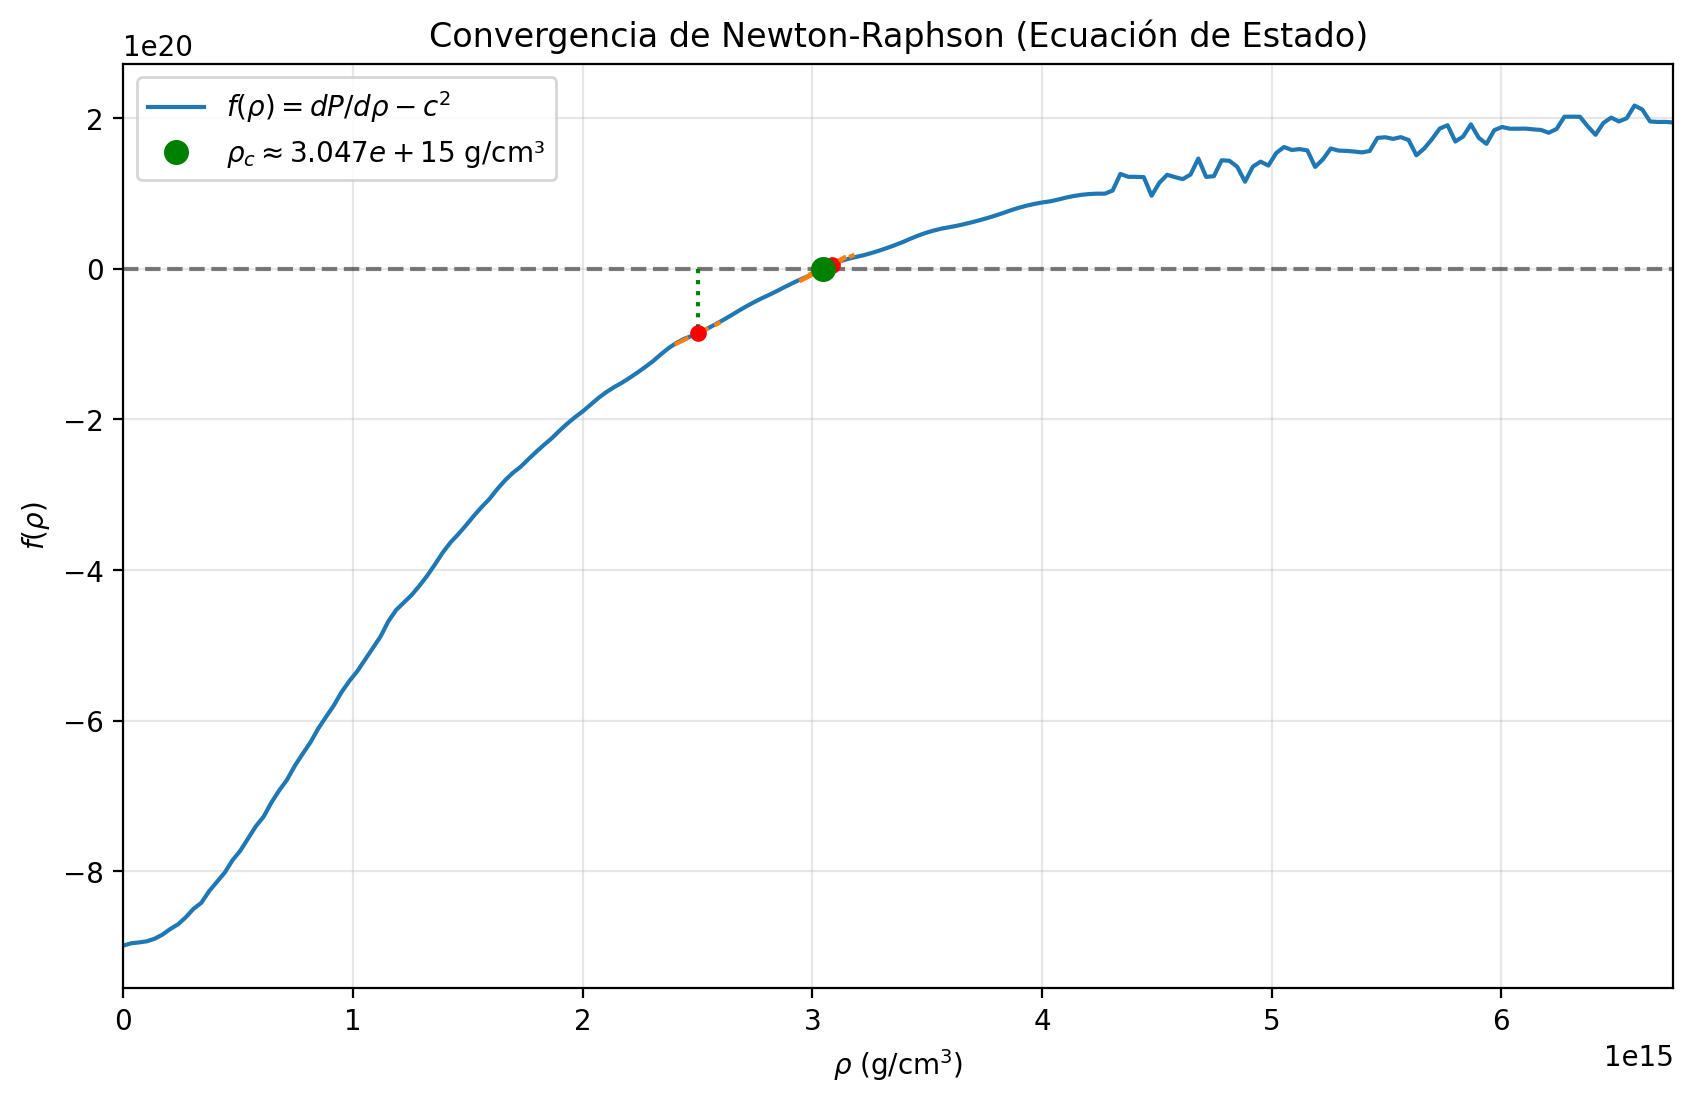

In [348]:
rho = np.asarray(x_0, dtype=float)
P = np.asarray(y_0, dtype=float)

interp = PchipInterpolator(rho, P)
dPdrho = interp.derivative()

def f(rho_val):
    return dPdrho(rho_val) - c2

def df(rho_val):
    h = rho_val * 1e-6
    return (f(rho_val + h) - f(rho_val - h)) / (2*h)

rho0 = 2.5e15
iteraciones = 6
rho_vals = [rho0]
rho_n = rho0

for i in range(iteraciones - 1):
    rho_n = rho_n - f(rho_n) / df(rho_n)
    rho_vals.append(rho_n)


plt.figure(figsize=(10, 6))
rho_plot = np.linspace(min(rho), max(rho), 200)
y_plot = f(rho_plot)

plt.plot(rho_plot, y_plot, label=r'$f(\rho) = dP/d\rho - c^2$')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)


for i in range(len(rho_vals) - 1):
    xi = rho_vals[i]
    yi = f(xi)
    pendiente = df(xi)

    x_tangent = np.linspace(xi - 0.1e15, xi + 0.1e15, 100)
    y_tangent = yi + pendiente * (x_tangent - xi)
    plt.plot(x_tangent, y_tangent, 'C1--')
    plt.plot([xi, xi], [0, yi], 'g:')
    plt.plot(xi, yi, 'ro', markersize=5)

plt.plot(rho_vals[-1], f(rho_vals[-1]), 'go', markersize=8,
         label=fr'$\rho_c \approx {rho_vals[-1]:.3e}$ g/cm³')

plt.xlim(min(rho), max(rho))
plt.grid(True, alpha=0.3)
plt.xlabel(r'$\rho$ (g/cm$^3$)')
plt.ylabel(r'$f(\rho)$')
plt.legend()
plt.title('Convergencia de Newton-Raphson (Ecuación de Estado)')
plt.show()


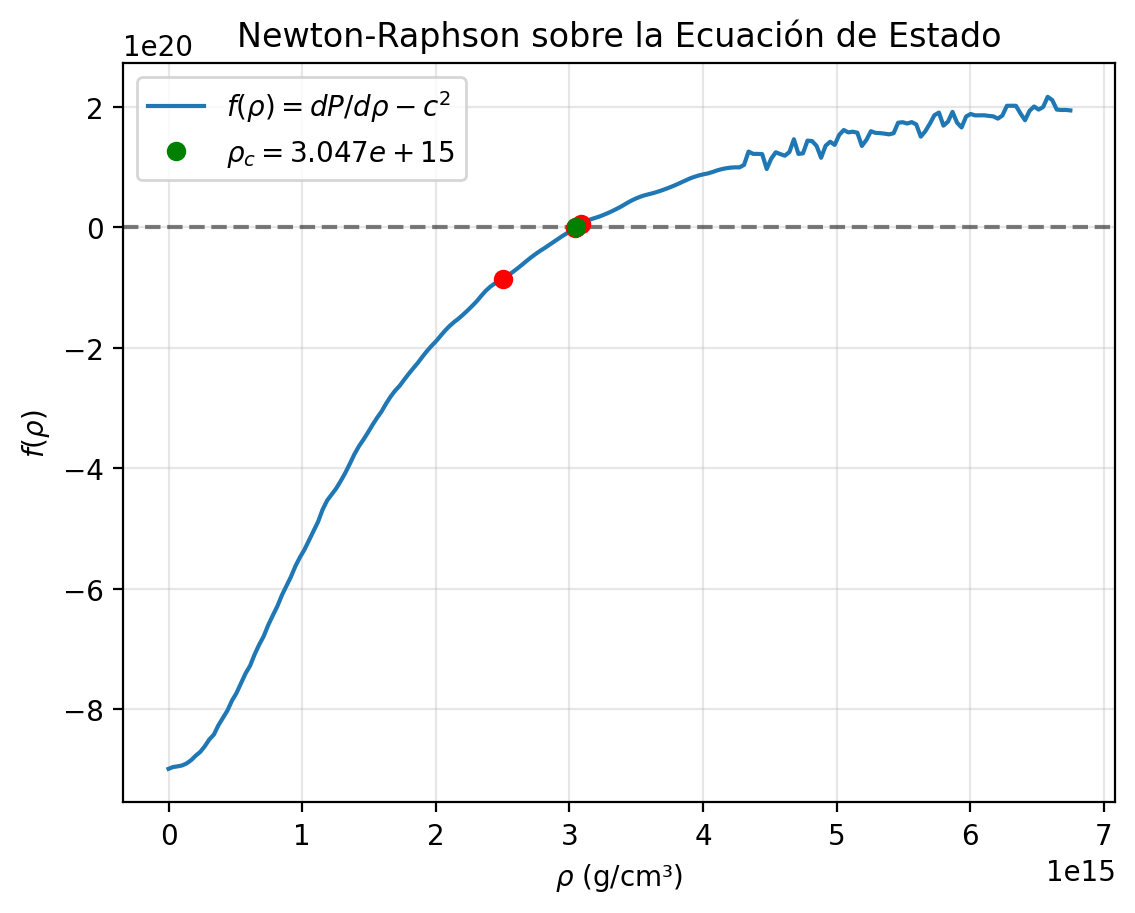

ρ_c ≈ 3.04664e+15 g/cm³


In [363]:
rho = np.array(x_0, float)
P = np.array(y_0, float)

f_interp = PchipInterpolator(rho, P)
df_interp = f_interp.derivative()

f = lambda r: df_interp(r) - c2

rho_n = 2.5e15
rho_vals = [rho_n]

for _ in range(6):  # número de iteraciones
    h = rho_n * 1e-6
    df_num = (f(rho_n + h) - f(rho_n - h)) / (2*h)
    rho_n -= f(rho_n) / df_num
    rho_vals.append(rho_n)

x = np.linspace(rho.min(), rho.max(), 200)
plt.plot(x, f(x), label=r'$f(\rho)=dP/d\rho-c^2$')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

for i, r in enumerate(rho_vals[:-1]):
    plt.plot(r, f(r), 'ro')
plt.plot(rho_vals[-1], f(rho_vals[-1]), 'go', label=fr'$\rho_c={rho_vals[-1]:.3e}$')

plt.xlabel(r'$\rho$ (g/cm³)')
plt.ylabel(r'$f(\rho)$')
plt.title('Newton-Raphson sobre la Ecuación de Estado')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

print(f"ρ_c ≈ {rho_vals[-1]:.5e} g/cm³")


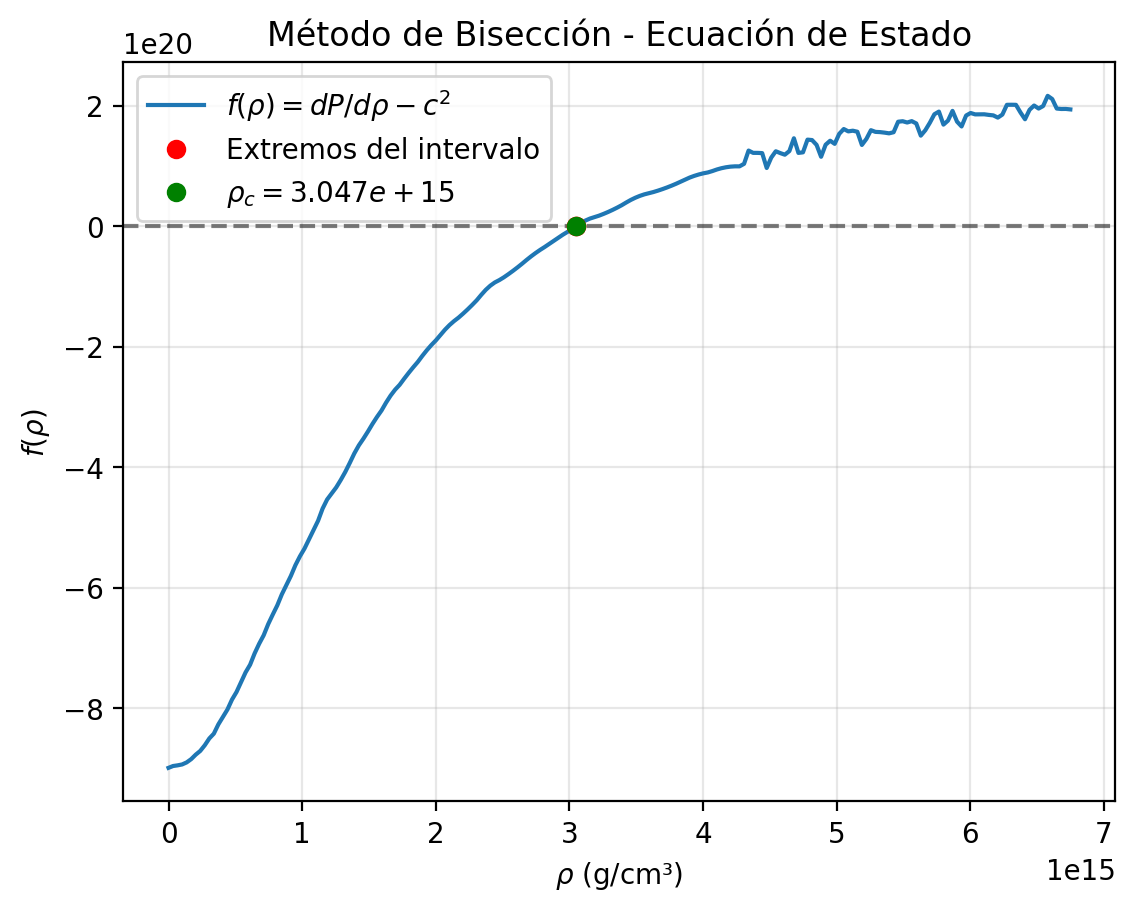

ρ_c ≈ 3.04664e+15 g/cm³


In [364]:
f = lambda r: df_interp(r) - c2

a, b = rho.min(), rho.max()   # intervalo inicial
fa, fb = f(a), f(b)

if fa * fb > 0:
    raise ValueError("f(a) y f(b) tienen el mismo signo. Ajusta el intervalo.")

iteraciones = 30
for _ in range(iteraciones):
    m = 0.5 * (a + b)
    fm = f(m)
    if fa * fm < 0:
        b, fb = m, fm
    else:
        a, fa = m, fm

rho_c = m

x = np.linspace(rho.min(), rho.max(), 200)
plt.plot(x, f(x), label=r'$f(\rho)=dP/d\rho - c^2$')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

plt.plot([a, b], [f(a), f(b)], 'ro', label='Extremos del intervalo')
plt.plot(rho_c, f(rho_c), 'go', label=fr'$\rho_c={rho_c:.3e}$')

plt.xlabel(r'$\rho$ (g/cm³)')
plt.ylabel(r'$f(\rho)$')
plt.title('Método de Bisección - Ecuación de Estado')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

print(f"ρ_c ≈ {rho_c:.5e} g/cm³")


In [352]:
def riemann_sum(y_values, dx):
    return np.sum(y_values[1:]) * dx

def trapezoidal_rule(y_values, dx):
    h_mean = (y_values[1:] + y_values[:-1]) / 2
    return np.sum(h_mean) * dx

def simpsons_rule(y_values, dx):
    n_points = len(y_values)
    if n_points % 2 == 0:
        raise ValueError("La regla de Simpson requiere un número impar de puntos de datos.")
    integral = y_values[0] + y_values[-1]
    integral += 4 * np.sum(y_values[1:-1:2])
    integral += 2 * np.sum(y_values[2:-1:2])
    return (dx / 3) * integral

# --- Definimos la función y el dominio ---
x = np.linspace(0, np.pi, 11)   # 11 puntos → 10 intervalos
y = np.sin(x) + x**2

dx = x[1] - x[0]

# --- Aproximaciones numéricas ---
riemann_approx = riemann_sum(y, dx)
trapezoidal_approx = trapezoidal_rule(y, dx)
simpson_approx = simpsons_rule(y, dx)

print(f"Suma de Riemann: {riemann_approx}")
print(f"Regla del Trapecio: {trapezoidal_approx}")
print(f"Regla de Simpson: {simpson_approx}")

# --- Valor exacto ---
# ∫(sin(x) + x²) dx = -cos(x) + x³/3
exact_value = (-np.cos(np.pi) + np.pi**3/3) - (-np.cos(0) + 0)
print(f"\nValor Exacto: {exact_value}")


Suma de Riemann: 13.920940059424883
Regla del Trapecio: 12.370626225409891
Regla de Simpson: 12.335535077414944

Valor Exacto: 12.335425560099939


In [353]:
rho = rho_newton  # el valor obtenido por Newton (o bisección)
residuo = cs_notaknot.derivative(1)(rho) - c2
print(f"rho = {rho:.12e} g/cm^3")
print(f"dP/drho(rho) = {cs_notaknot.derivative(1)(rho):.12e}")
print(f"residuo = dP/drho - c^2 = {residuo:.12e}")
print(f"¿rho está dentro del rango de datos? {x0[0]:.3e} <= rho <= {x0[-1]:.3e} -> {x0[0] <= rho <= x0[-1]}")


rho = 3.046635663226e+15 g/cm^3
dP/drho(rho) = 8.991166698258e+20
residuo = dP/drho - c^2 = 3.614910889626e+17
¿rho está dentro del rango de datos? 4.510e+01 <= rho <= 6.749e+15 -> True


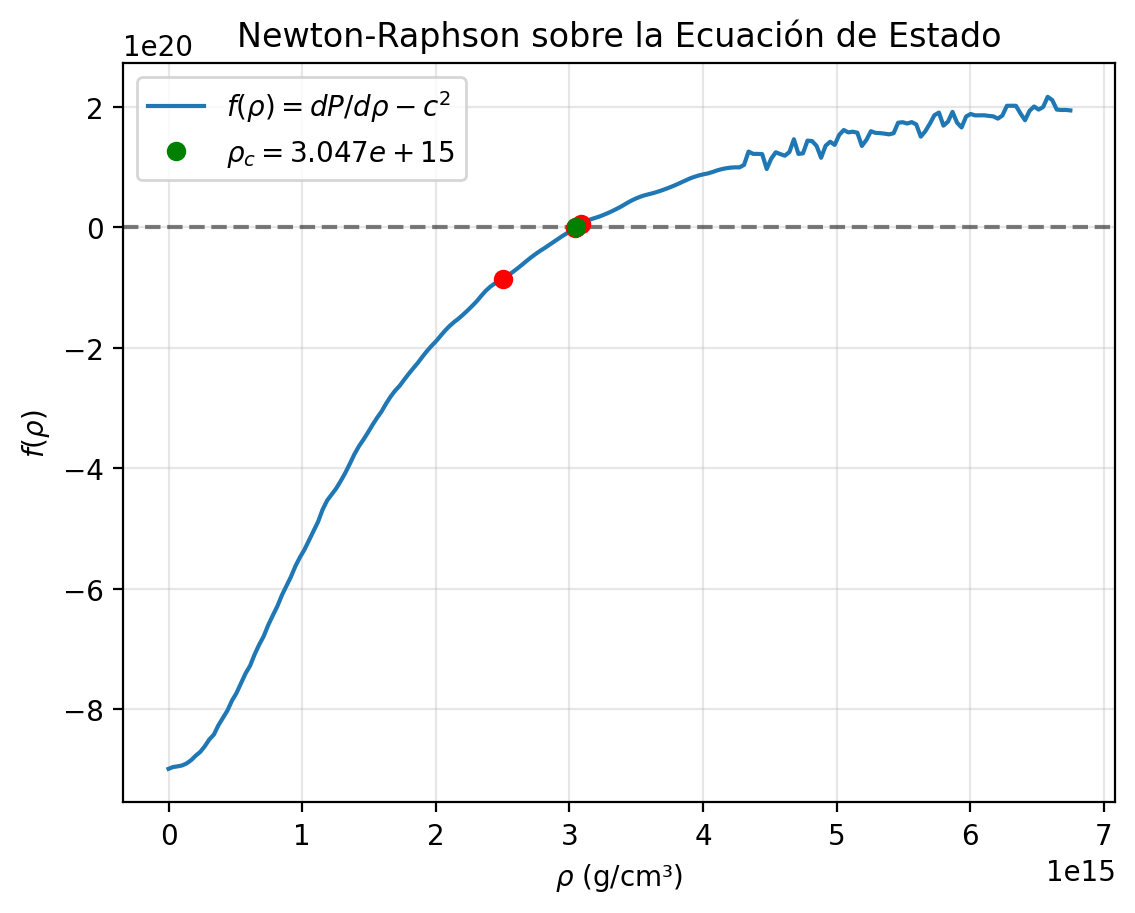

ρ_c ≈ 3.04664e+15 g/cm³


In [354]:
rho = np.array(x_0, float)
P = np.array(y_0, float)

# --- Interpolación e derivada ---
f_interp = PchipInterpolator(rho, P)
df_interp = f_interp.derivative()

# --- Constante física ---
c = 2.99792458e10
c2 = c**2

# --- Definir función f(ρ) = dP/dρ - c² ---
f = lambda r: df_interp(r) - c2

# --- Método de Newton-Raphson ---
rho_n = 2.5e15
rho_vals = [rho_n]

for _ in range(6):  # número de iteraciones
    h = rho_n * 1e-6
    df_num = (f(rho_n + h) - f(rho_n - h)) / (2*h)
    rho_n -= f(rho_n) / df_num
    rho_vals.append(rho_n)

# --- Gráfica ---
x = np.linspace(rho.min(), rho.max(), 200)
plt.plot(x, f(x), label=r'$f(\rho)=dP/d\rho-c^2$')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

# Iteraciones (tangentes y puntos)
for i, r in enumerate(rho_vals[:-1]):
    plt.plot(r, f(r), 'ro')
plt.plot(rho_vals[-1], f(rho_vals[-1]), 'go', label=fr'$\rho_c={rho_vals[-1]:.3e}$')

plt.xlabel(r'$\rho$ (g/cm³)')
plt.ylabel(r'$f(\rho)$')
plt.title('Newton-Raphson sobre la Ecuación de Estado')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

print(f"ρ_c ≈ {rho_vals[-1]:.5e} g/cm³")

ρ_c (Bisección): 3.046636e+15
ρ_c (Newton-Raphson): 3.046636e+15
No coinciden exactamente, pero convergen al mismo valor.


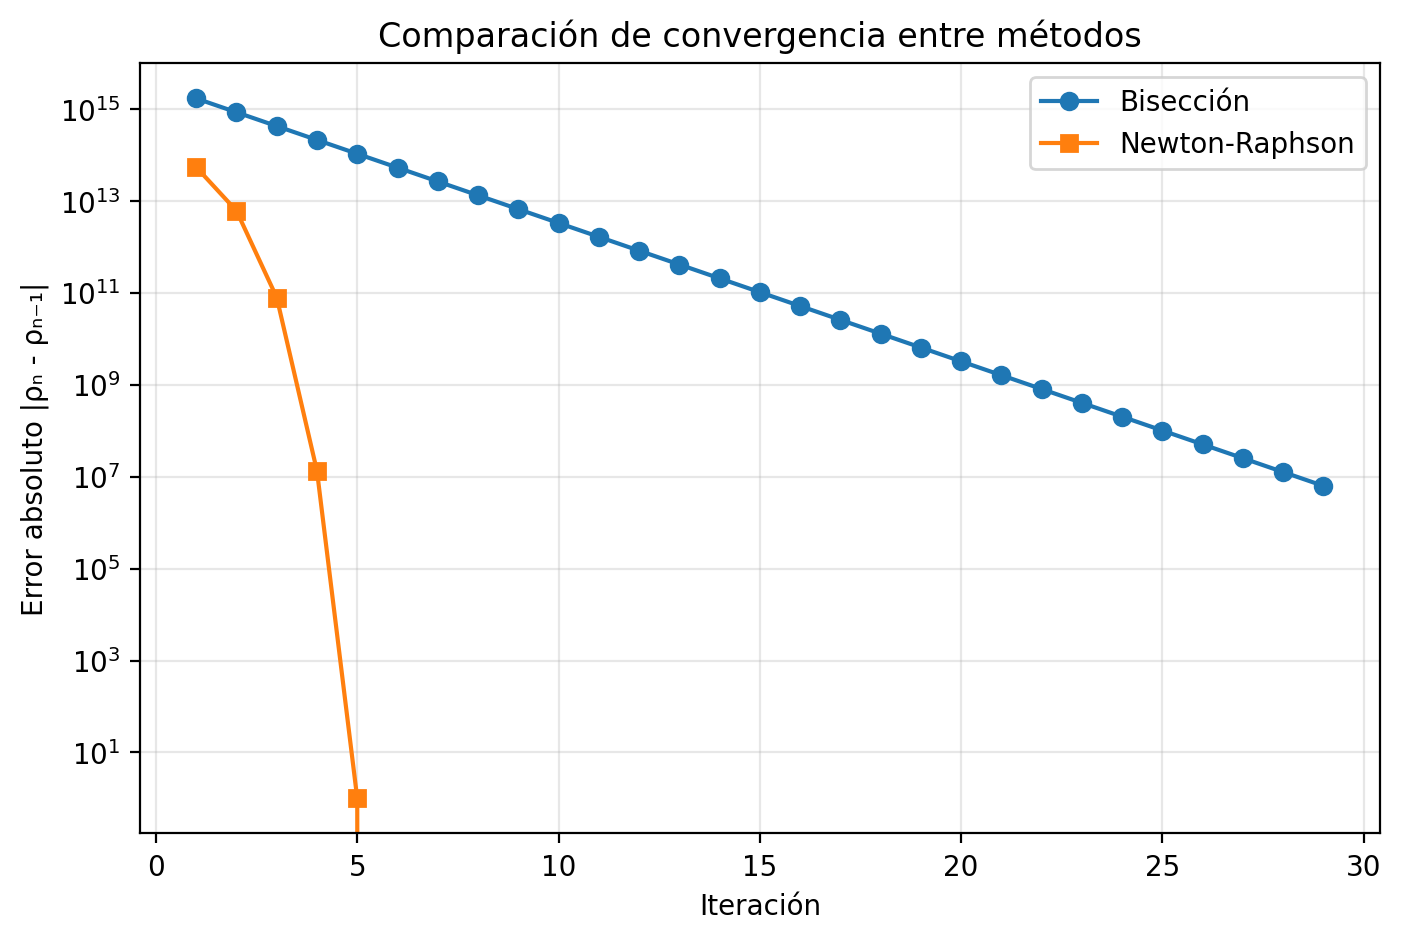

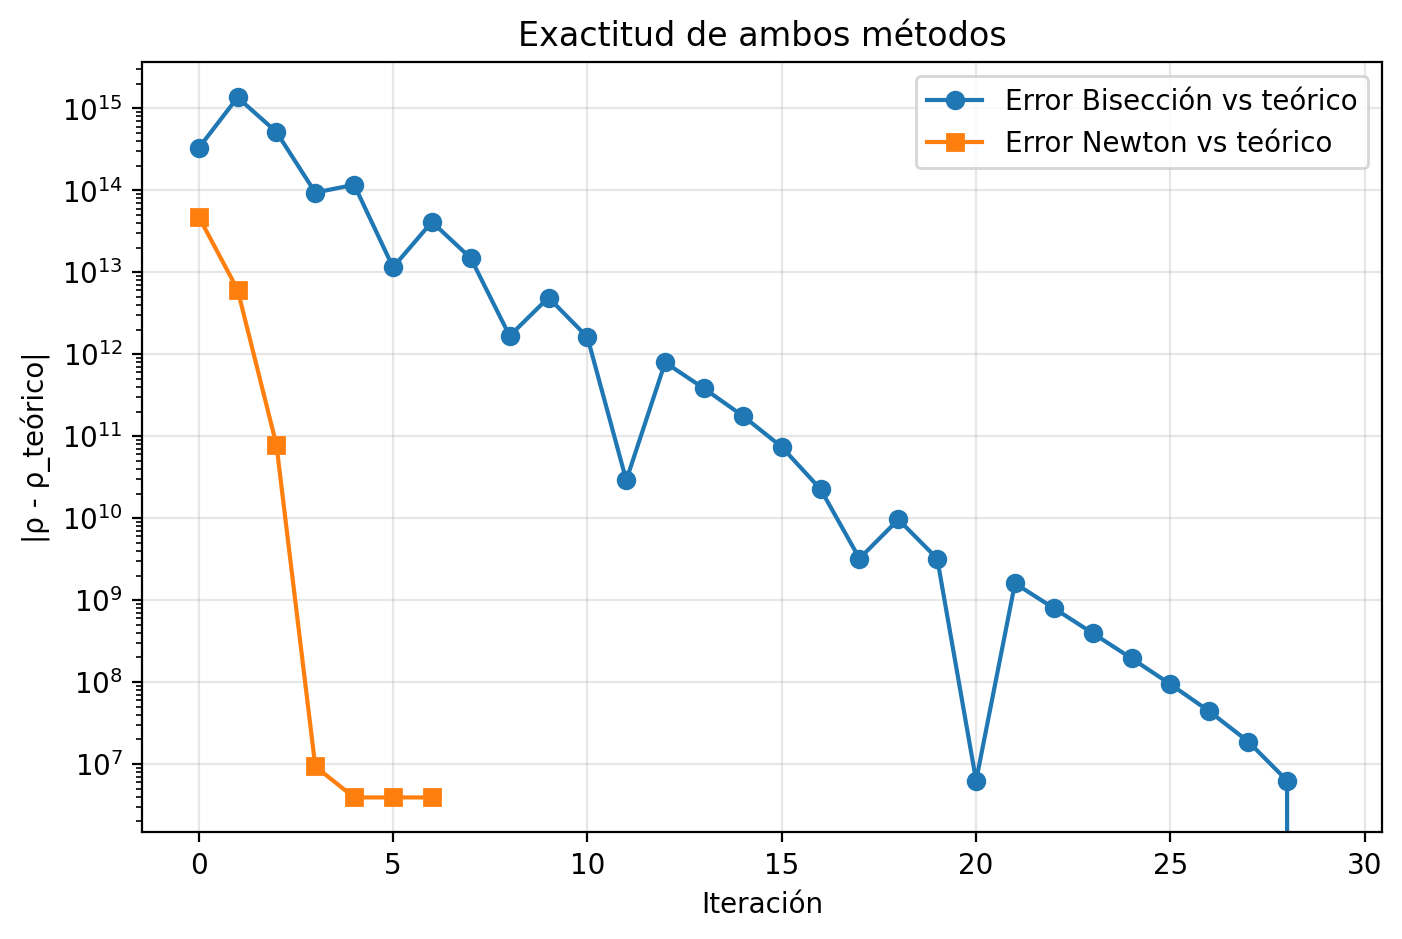

In [356]:
# --- Datos de ejemplo (reemplázalos por tus datos reales) ---
rho = np.array(x_0, float)
P = np.array(y_0, float)

# --- Interpolación e derivada ---
f_interp = PchipInterpolator(rho, P)
df_interp = f_interp.derivative()
d2f_interp = df_interp.derivative()

# --- Constante ---
c = 2.99792458e10
c2 = c**2

# --- Función objetivo ---
f = lambda r: df_interp(r) - c2
df = lambda r: d2f_interp(r)

# --- Método de Bisección ---
a, b = rho.min(), rho.max()
fa, fb = f(a), f(b)
if fa * fb > 0:
    raise ValueError("f(a) y f(b) tienen el mismo signo. Ajusta el intervalo.")

bisec_r, bisec_err = [], []
for _ in range(30):
    m = 0.5 * (a + b)
    fm = f(m)
    bisec_r.append(m)
    if fa * fm < 0:
        b, fb = m, fm
    else:
        a, fa = m, fm
    if len(bisec_r) > 1:
        bisec_err.append(abs(bisec_r[-1] - bisec_r[-2]))

rho_bisec = bisec_r[-1]

# --- Método de Newton-Raphson ---
x = (rho.min() + rho.max()) / 2  # punto inicial medio
newton_r, newton_err = [], []
for _ in range(30):
    fx, dfx = f(x), df(x)
    x_new = x - fx / dfx
    newton_r.append(x_new)
    if len(newton_r) > 1:
        newton_err.append(abs(newton_r[-1] - newton_r[-2]))
    if abs(x_new - x) < 1e-8:
        break
    x = x_new

rho_newton = newton_r[-1]

# --- Comparación de precisión ---
rho_true = rho_bisec  # asumimos bisección como valor "teórico"
err_bisec = [abs(r - rho_true) for r in bisec_r]
err_newton = [abs(r - rho_true) for r in newton_r]

# --- Puntos donde coinciden aproximadamente ---
for i in range(min(len(bisec_r), len(newton_r))):
    if abs(bisec_r[i] - newton_r[i]) < 1e-10:
        iter_similar = i + 1
        break
else:
    iter_similar = None

# --- Resultados ---
print(f"ρ_c (Bisección): {rho_bisec:.6e}")
print(f"ρ_c (Newton-Raphson): {rho_newton:.6e}")
if iter_similar:
    print(f"Ambos métodos son similares a partir de la iteración {iter_similar}")
else:
    print("No coinciden exactamente, pero convergen al mismo valor.")

# --- Gráfica de errores ---
plt.figure(figsize=(8,5))
plt.semilogy(range(1, len(bisec_err)+1), bisec_err, 'o-', label='Bisección')
plt.semilogy(range(1, len(newton_err)+1), newton_err, 's-', label='Newton-Raphson')
plt.xlabel("Iteración")
plt.ylabel("Error absoluto |ρₙ - ρₙ₋₁|")
plt.title("Comparación de convergencia entre métodos")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- Comparación con valor teórico ---
plt.figure(figsize=(8,5))
plt.semilogy(err_bisec, 'o-', label='Error Bisección vs teórico')
plt.semilogy(err_newton, 's-', label='Error Newton vs teórico')
plt.xlabel("Iteración")
plt.ylabel("|ρ - ρ_teórico|")
plt.title("Exactitud de ambos métodos")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

##Calculo de la Densidad de Energia usando integración numérica

/tmp/ipython-input-3087948858.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


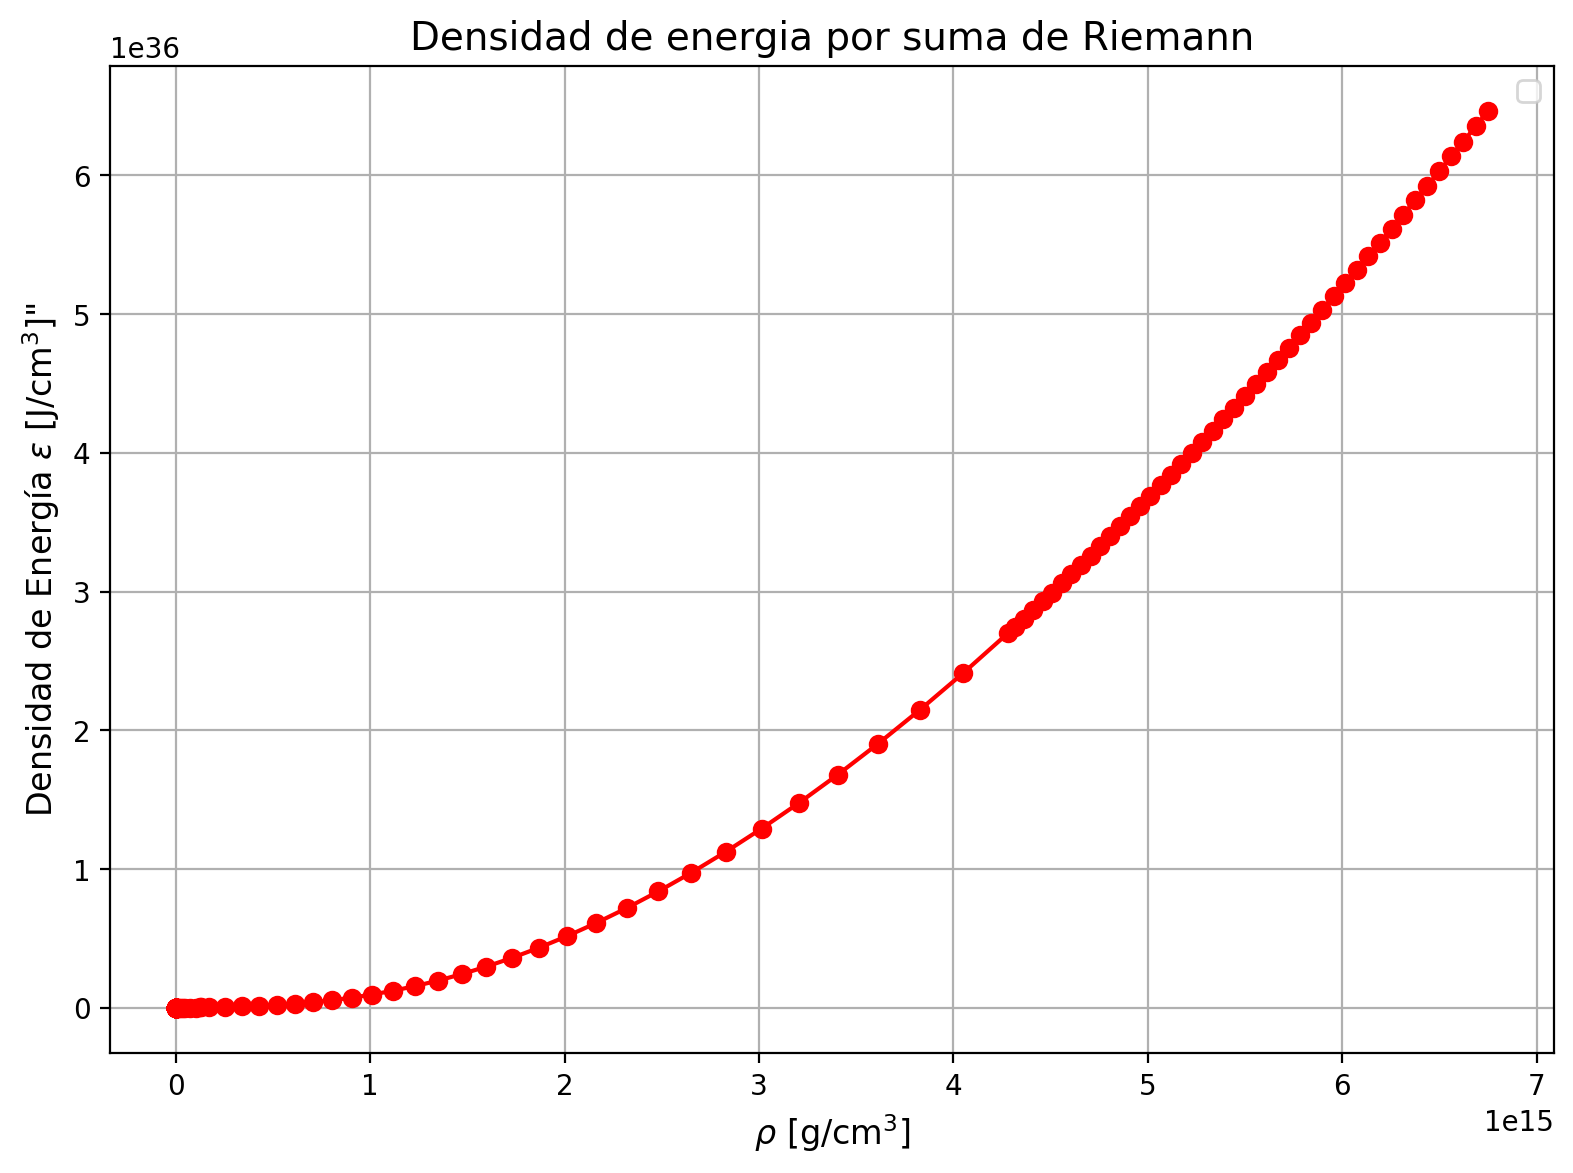

In [357]:
P = dataframe["P[dyn/cm^2]"].values
rho = dataframe["rho[g/cm^3]"].values

df_inte = pd.DataFrame({

    })

#Calculo de la Densidad de energia usando la suma de Riemann

integral = [0]

for i in range(1, len(rho)):
    delta_rho = rho[i] - rho[i-1]
    area = P[i-1]/(rho[i-1])**2 * delta_rho
    integral.append(integral[-1] + area)

df_inte["Integral_Riem"] = integral * rho + rho * (3 * 10**8)**2

# ---- Gráfica ----
plt.figure(figsize=(8,6))
plt.plot(rho, df_inte["Integral_Riem"], marker='o', linestyle='-', color='red')
plt.xlabel(r'$\rho\ [\mathrm{g/cm^3}]$', fontsize=12)
plt.ylabel(r'Densidad de Energía $\varepsilon$ [J/cm$^3$]"', fontsize=12)
plt.title("Densidad de energia por suma de Riemann", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

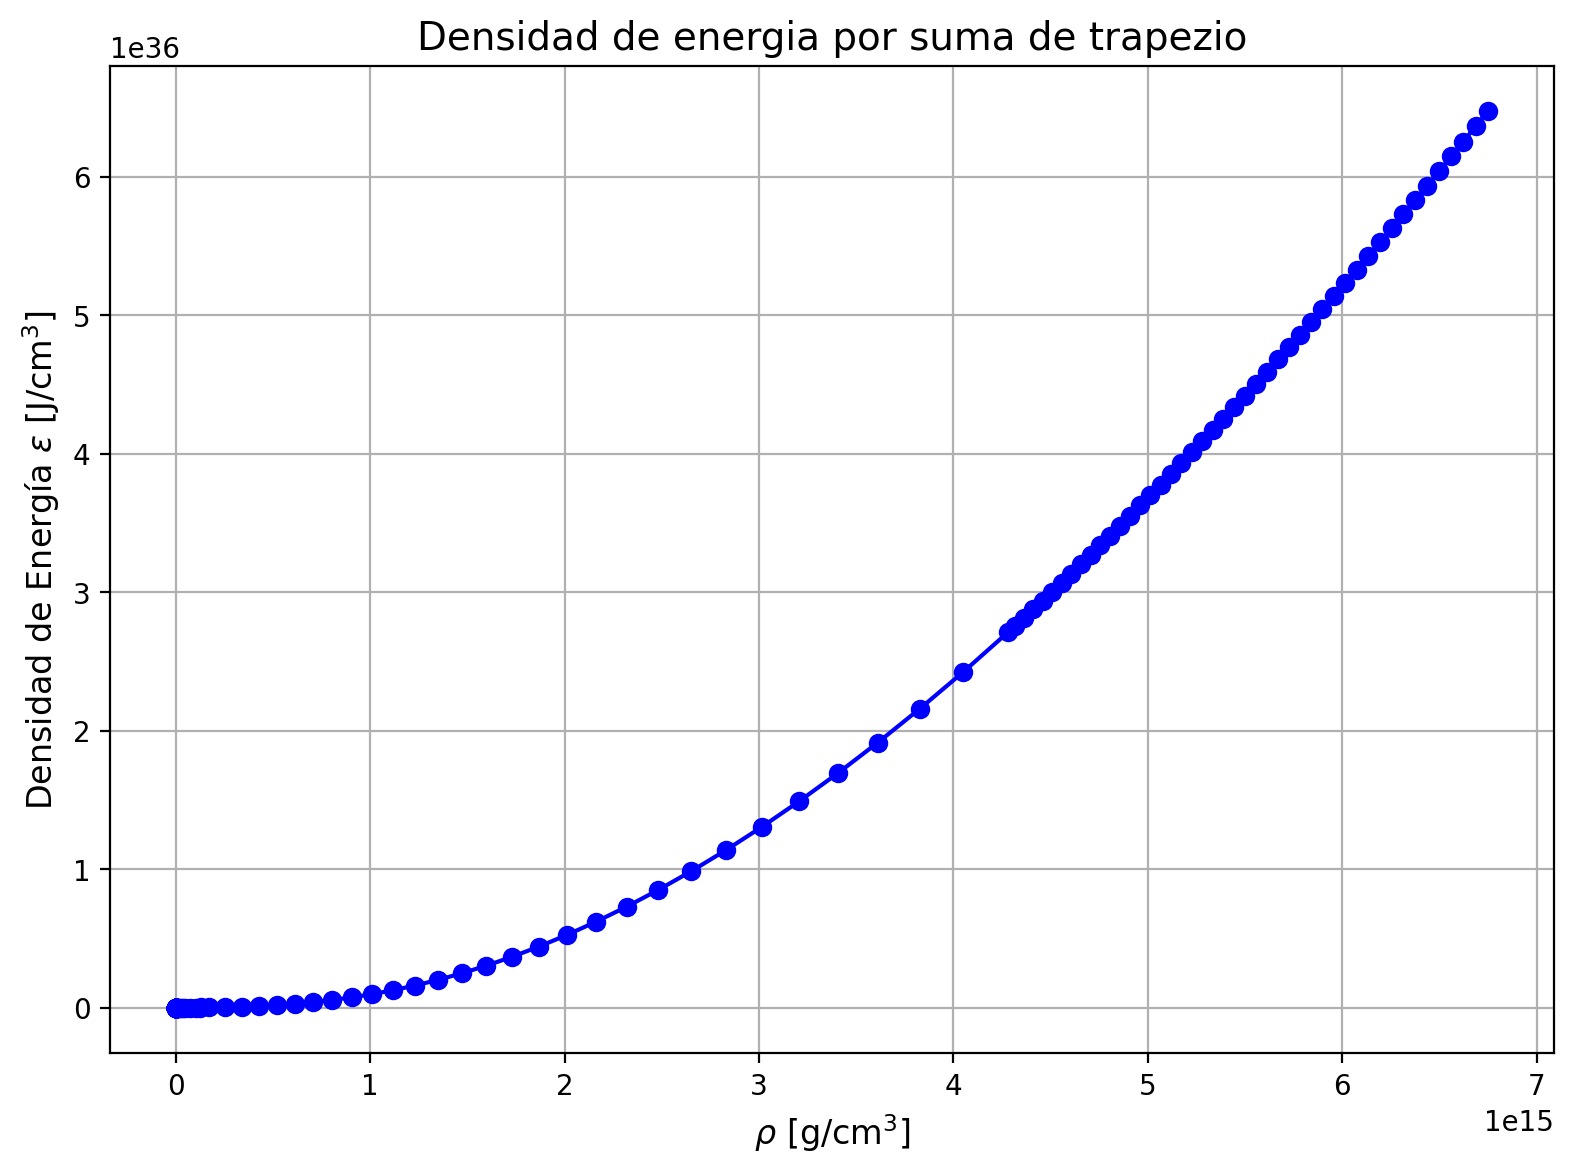

In [358]:
#Calculo de la Densidad de energia usando suma de trapezio

integrando = P / rho**2


integral = [trapezoid(integrando[:i+1], rho[:i+1]) for i in range(len(rho))]


df_inte["Integral_trape"] = integral*rho + rho*(3*10**8)**2


plt.figure(figsize=(8, 6))
plt.plot(rho, df_inte["Integral_trape"], marker='o', linestyle='-', color='b')

plt.title("Densidad de energia por suma de trapezio", fontsize=14)
plt.xlabel(r"$\rho\ [\mathrm{g/cm^3}]$", fontsize=12)
plt.ylabel(r"Densidad de Energía $\varepsilon$ [J/cm$^3$]", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

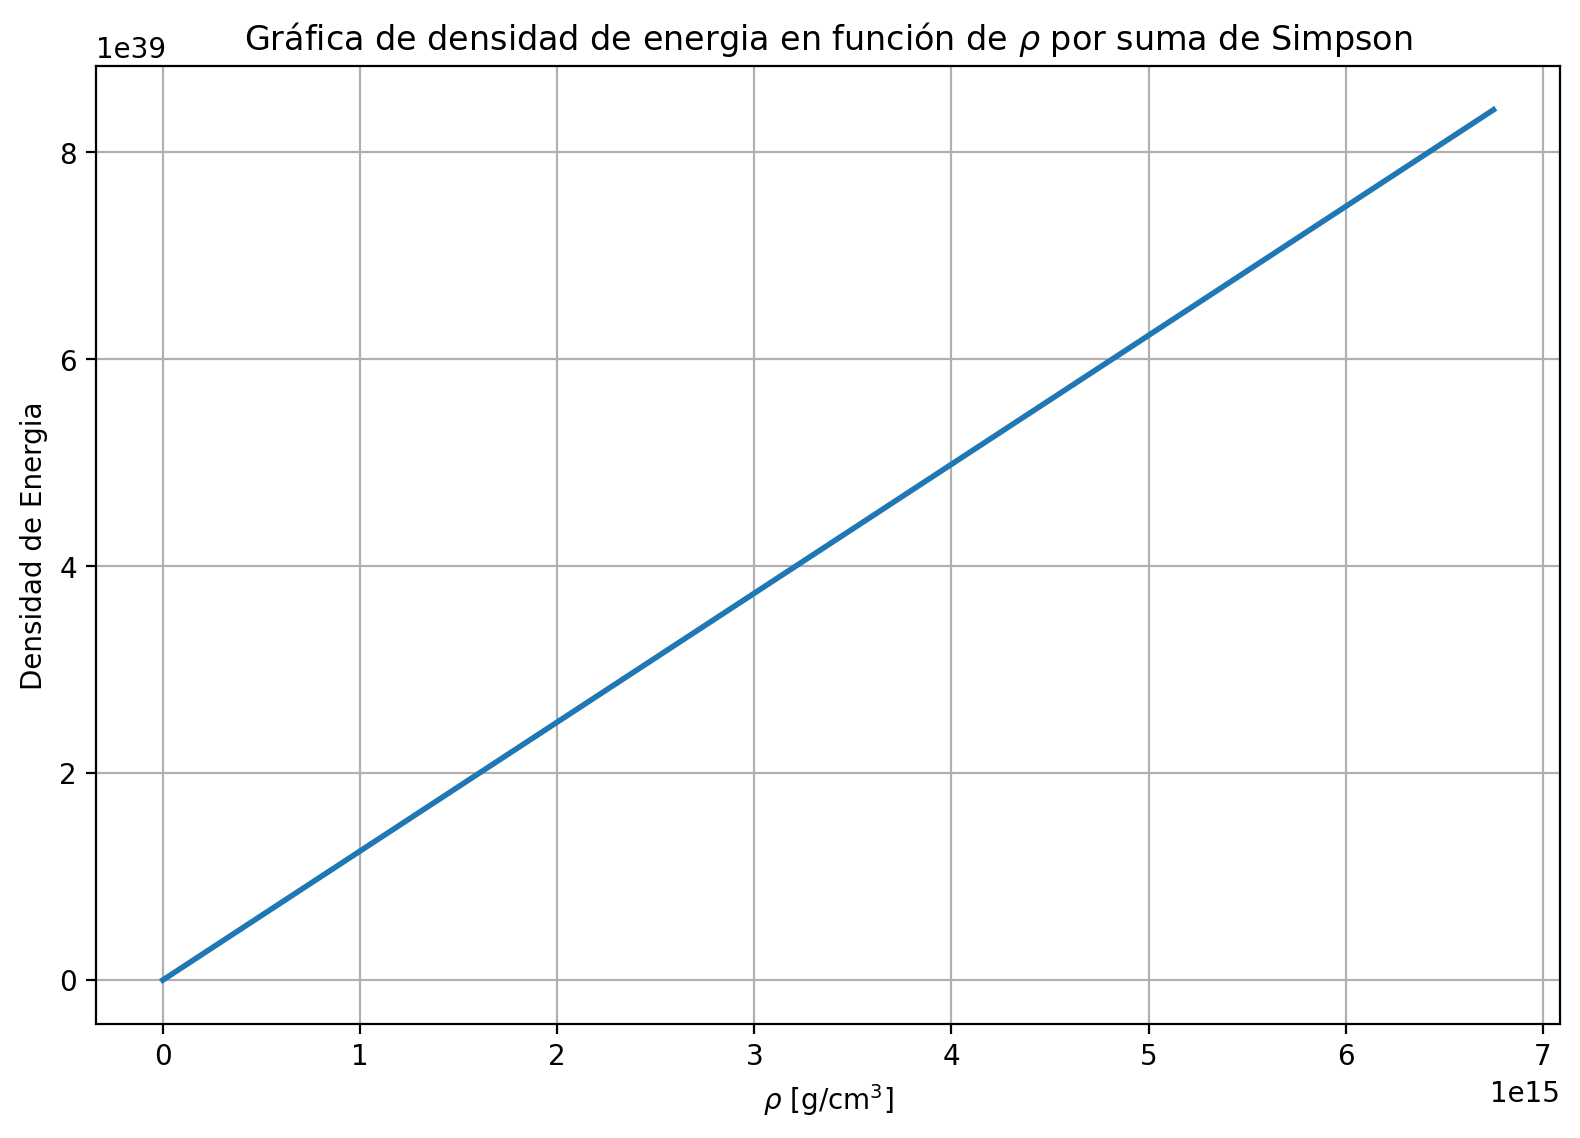

In [359]:
#Interpolar P y Rho para que sean igualmente espaciados y poder hacer suma por Simpson

rho_orig = dataframe["rho[g/cm^3]"].values
P_orig = dataframe["P[dyn/cm^2]"].values

num_puntos = len(rho_orig)
rho_uniforme = np.linspace(rho_orig.min(), rho_orig.max(), num_puntos)
pchip_interp = PchipInterpolator(rho_orig, P_orig)
P_uniforme = pchip_interp(rho_uniforme)

#Definir la funcion a integrar ahora que los puntos estan igualmente espaciados

f = P_uniforme / rho_uniforme**2
integral = simpson(f, rho_uniforme)
c = 3e8
DensidadEnergia = rho_uniforme * c**2 + rho_uniforme * integral
df_interpolado = pd.DataFrame({
    "rho_uniforme [g/cm^3]": rho_uniforme,
    "P_interpolado [dyn/cm^2]": P_uniforme,
    "Densidad de Energía (Simpson + PCHIP)": DensidadEnergia
})

plt.figure(figsize=(8, 6))
plt.plot(
    df_interpolado["rho_uniforme [g/cm^3]"],
    df_interpolado["Densidad de Energía (Simpson + PCHIP)"],
    '-', lw=2, label="Simpson + PCHIP"
)


plt.xlabel(r"$\rho\ [\mathrm{g/cm^3}]$")
plt.ylabel("Densidad de Energia")
plt.title(r"Gráfica de densidad de energia en función de $\rho$ por suma de Simpson")
plt.grid(True)
plt.tight_layout()
plt.show()

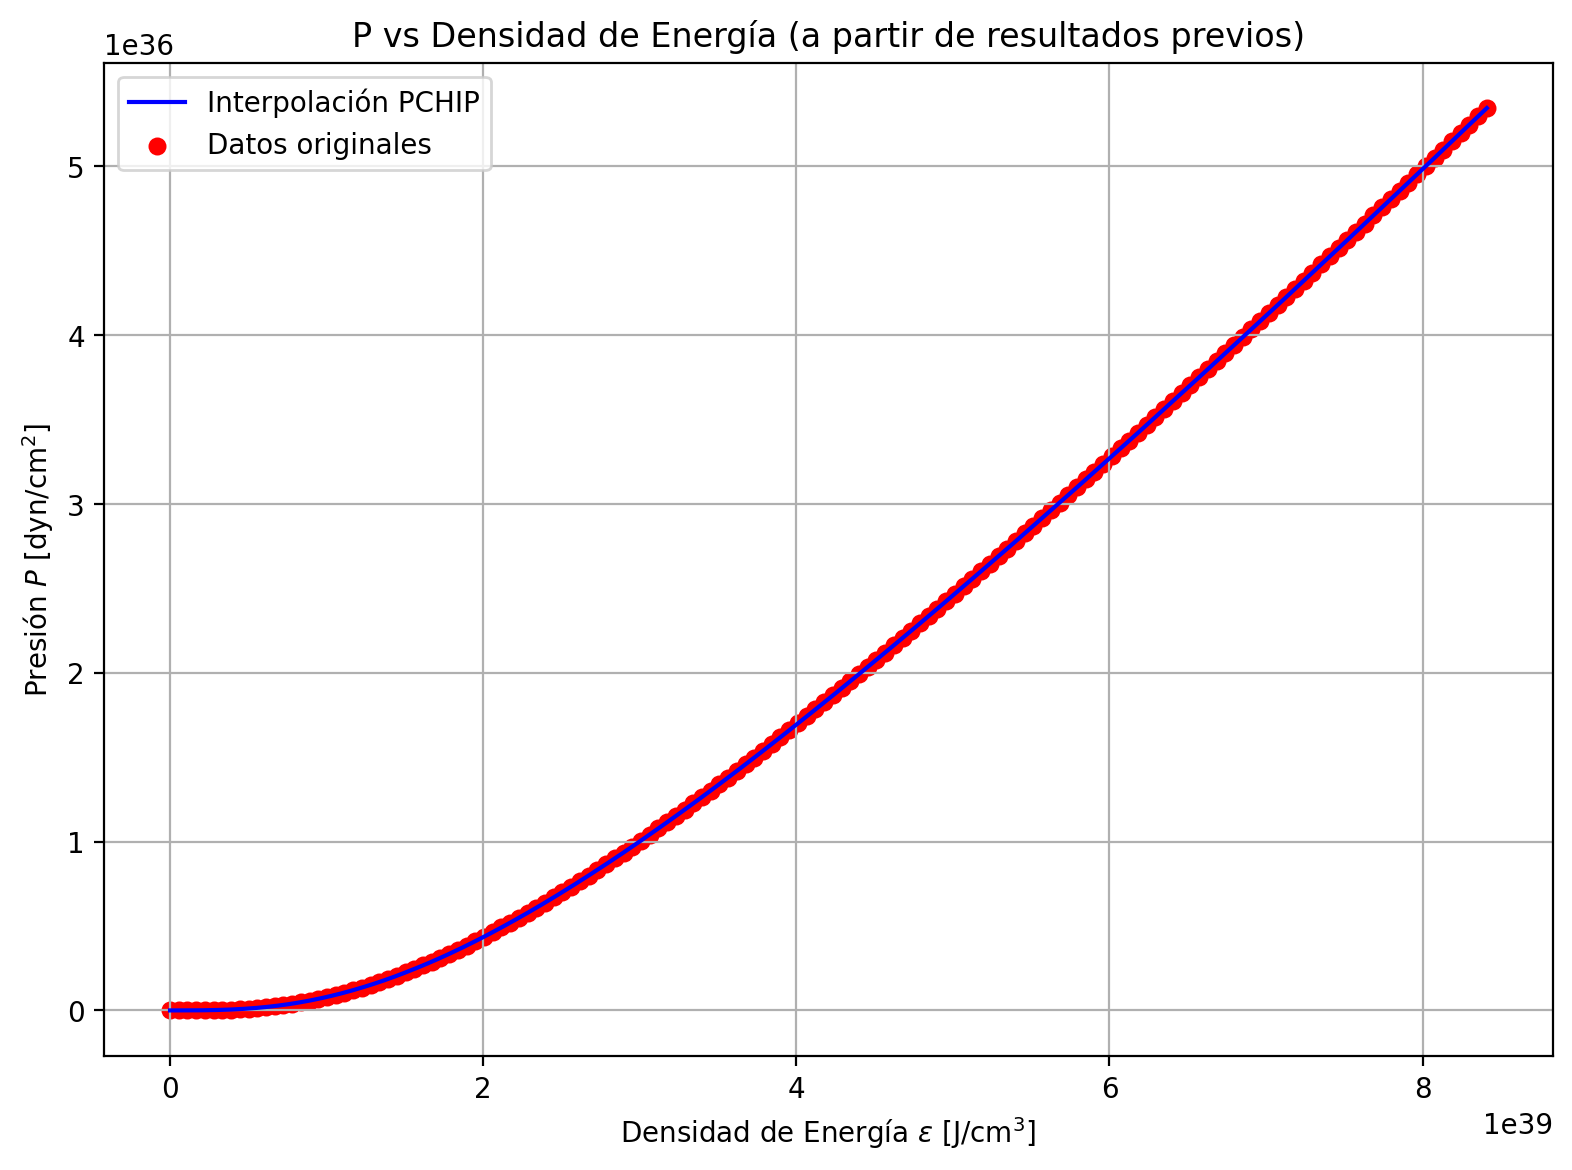

In [360]:
#Interpolar P y E
energia = df_interpolado["Densidad de Energía (Simpson + PCHIP)"].values
P_interp = df_interpolado["P_interpolado [dyn/cm^2]"].values

# --- Interpolación PCHIP de P en función de la densidad de energía ---
interp_PE = PchipInterpolator(energia, P_interp)

# Crear un eje más suave para graficar
energia_suave = np.linspace(energia.min(), energia.max(), 500)
P_suave = interp_PE(energia_suave)

# --- Gráfica ---
plt.figure(figsize=(8, 6))
plt.plot(energia_suave, P_suave, label="Interpolación PCHIP", color="blue")
plt.scatter(energia, P_interp, color="red", s=30, label="Datos originales")

plt.xlabel(r"Densidad de Energía $\varepsilon$ [J/cm$^3$]")
plt.ylabel(r"Presión $P$ [dyn/cm$^2$]")
plt.title("P vs Densidad de Energía (a partir de resultados previos)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

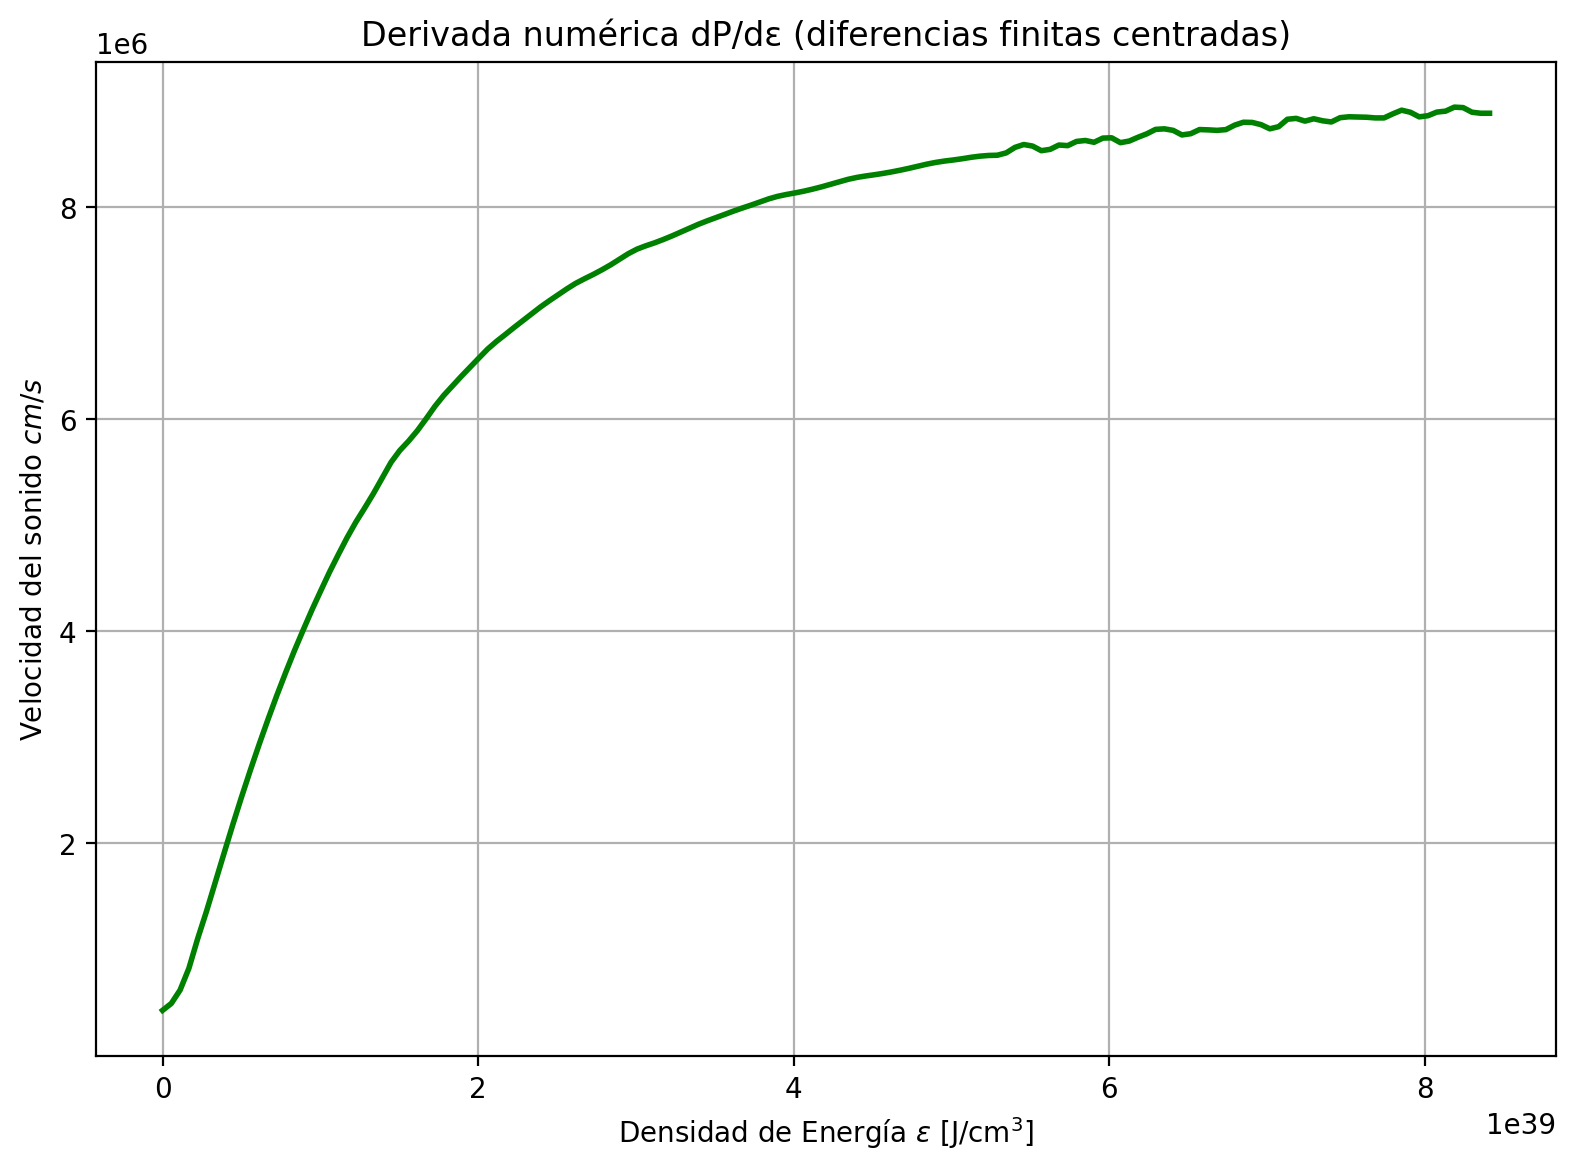

In [361]:
#Encontrar la derivada de la presion con respecto a la densidad de energia
energia = df_interpolado["Densidad de Energía (Simpson + PCHIP)"].values
P_interp = df_interpolado["P_interpolado [dyn/cm^2]"].values

# --- Calcular la derivada numérica dP/dE usando diferencias finitas centradas ---
dP_dE = np.zeros_like(P_interp)

for i in range(1, len(energia) - 1):
    dP_dE[i] = (P_interp[i + 1] - P_interp[i - 1]) / (energia[i + 1] - energia[i - 1])

# Derivadas en los extremos (forward/backward)
dP_dE[0] = (P_interp[1] - P_interp[0]) / (energia[1] - energia[0])
dP_dE[-1] = (P_interp[-1] - P_interp[-2]) / (energia[-1] - energia[-2])

#Usar la derivada para encontrar la velocidad del sonido en el medio

c=3*10**8
S = np.sqrt( dP_dE *c**2)
plt.figure(figsize=(8, 6))
plt.plot(energia, S, color='green', linewidth=2)
plt.xlabel(r"Densidad de Energía $\varepsilon$ [J/cm$^3$]")
plt.ylabel(r"Velocidad del sonido $cm/s$")
plt.title("Derivada numérica dP/dε (diferencias finitas centradas)")
plt.grid(True)
plt.tight_layout()
plt.show()